In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Astrometric fitting

In this tutorial we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements. For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data 
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract). 

In [3]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(
    dirname + "astro.txt", format="csv", fill_values=[(".", "0")]
)

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping
# the primary and secondary star
ind = (
    (astro_dates.value > 1975.0)
    & (astro_dates.value < 1999.73)
    & (~astro_data_full["rho"].mask)
    & (~astro_data_full["PA"].mask)
)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = "jd"
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01^{\prime\prime}$ in separation for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [4]:
import numpy as np

astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float)  # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi / 180.0
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float)
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg)  # radians

## Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit. 

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


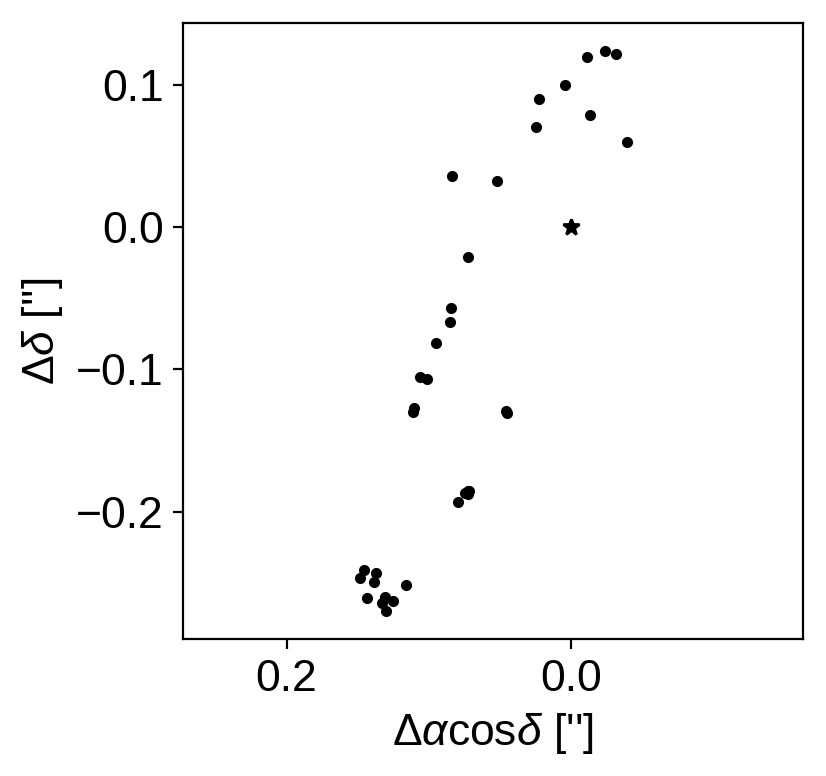

In [5]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

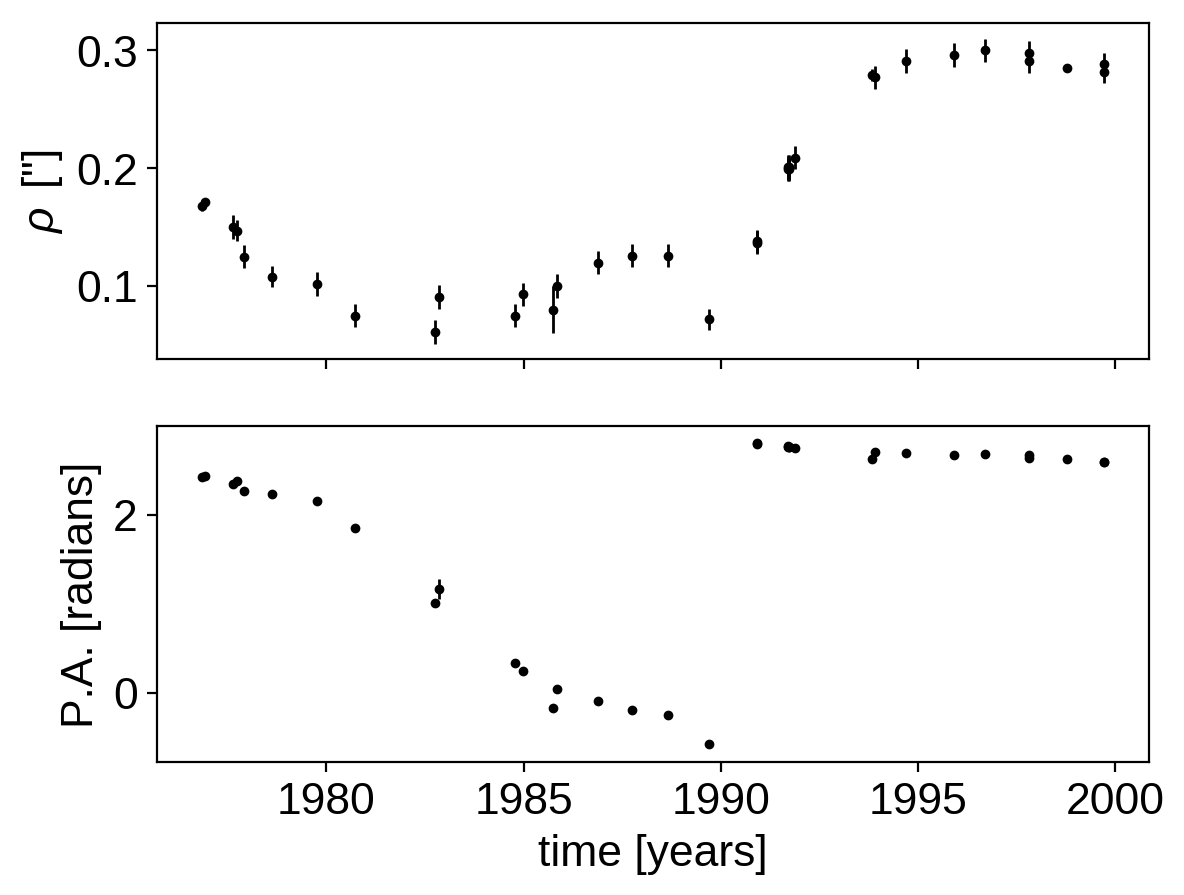

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r"P.A. [radians]")
ax[1].set_xlabel("time [years]");

## Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

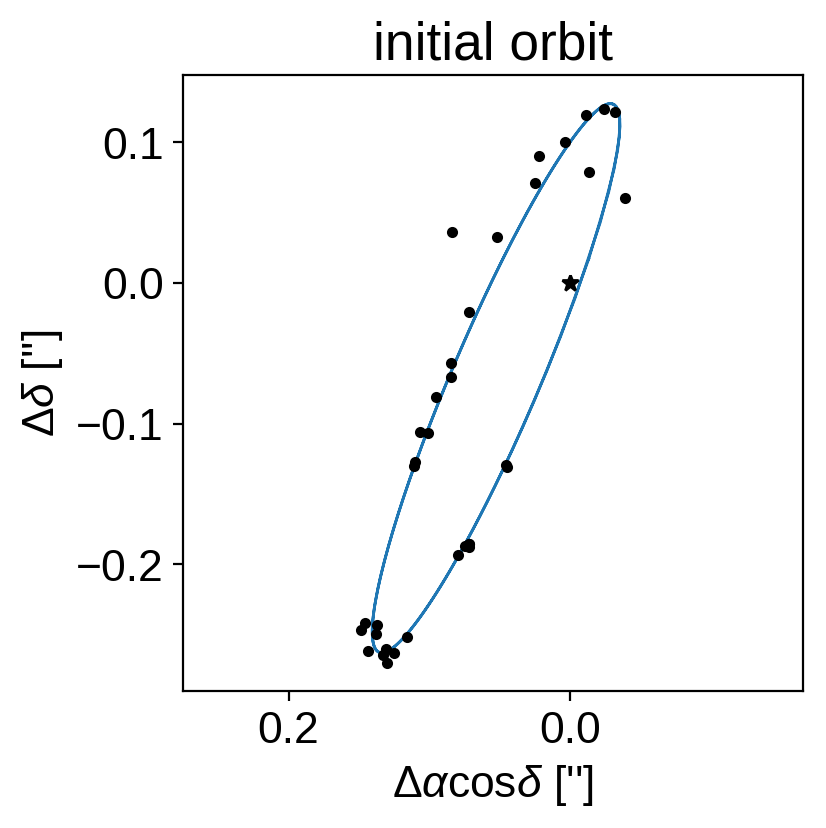

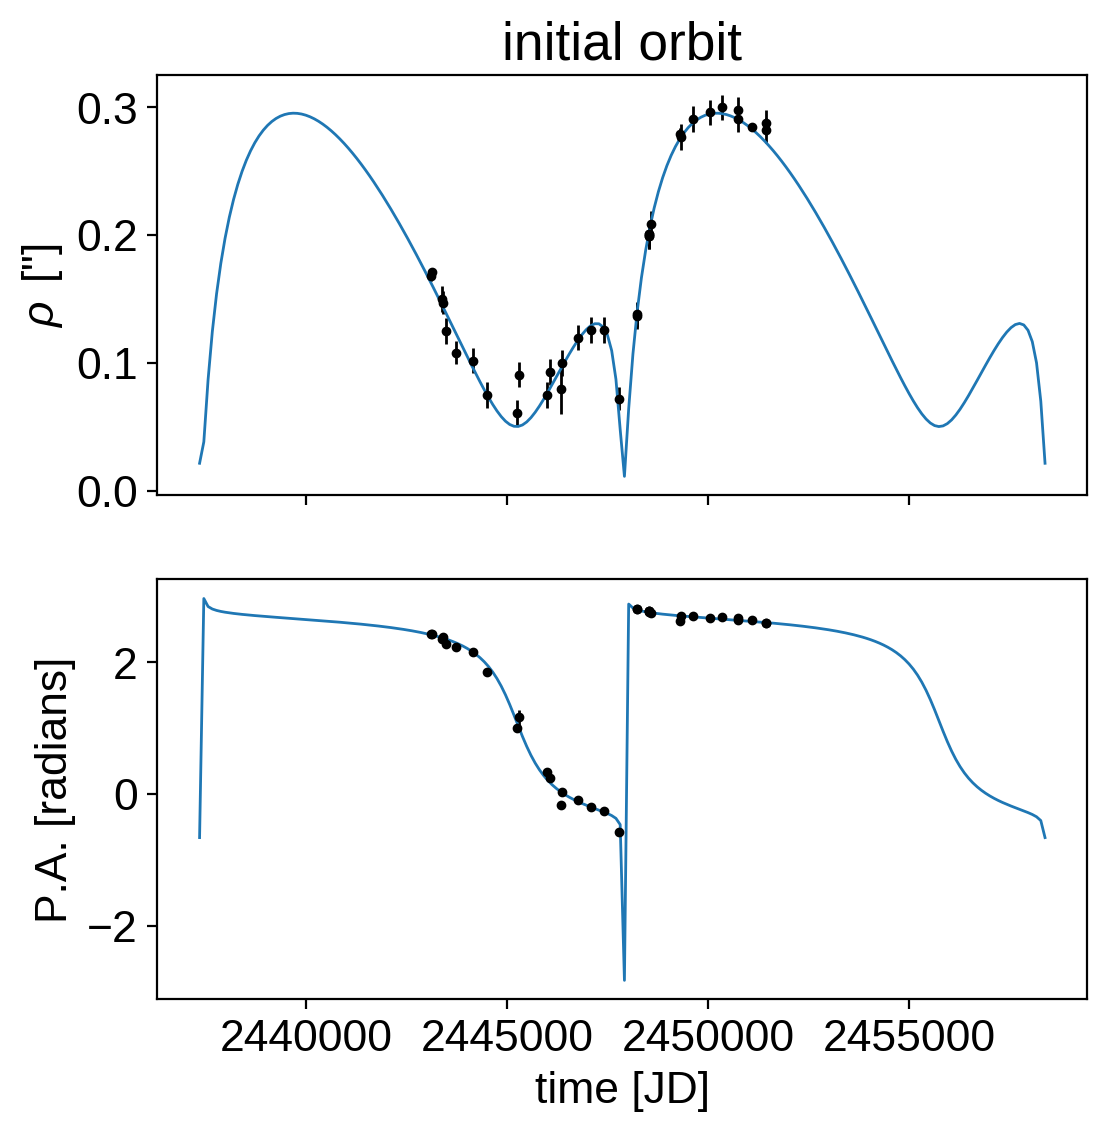

In [7]:
import pymc3 as pm
import theano
import theano.tensor as tt

import exoplanet as xo
from exoplanet.distributions import Angle

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324  # arcsec
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg  # [rad]
omega = 251.6 * deg - np.pi  # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg
P = 28.8 * 365.25  # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega
)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t = np.linspace(T0 - P, T0 + P, num=200)  # days
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit")

ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r"P.A. [radians]")
ax[1].set_xlabel("time [JD]");

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

In [8]:
yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)


def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)

        a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years,
        # so we'll set a broad prior on logP
        logP = pm.Normal("logP", mu=np.log(25 * yr), sd=10.0, testval=np.log(28.8 * yr))
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = 251.6 * deg - np.pi
        Omega0 = 159.6 * deg
        p = Angle("p", testval=0.5 * (Omega0 + omega0))
        m = Angle("m", testval=0.5 * (Omega0 - omega0))
        omega = pm.Deterministic("omega", p - m)
        Omega = pm.Deterministic("Omega", p + m)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2 * np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform("cos_incl", lower=-1, upper=1, testval=np.cos(96.0 * deg))
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.798)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun,
            t_periastron=tperi,
            period=P,
            incl=incl,
            ecc=ecc,
            omega=omega,
            Omega=Omega,
        )
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal("log_rho_s", mu=np.log(np.median(rho_err)), sd=5.0)
        log_theta_s = pm.Normal("log_theta_s", mu=np.log(np.median(theta_err)), sd=5.0)
        rho_tot_err = tt.sqrt(rho_err ** 2 + tt.exp(2 * log_rho_s))
        theta_tot_err = tt.sqrt(theta_err ** 2 + tt.exp(2 * log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(
            tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data)
        )
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = xo.optimize(map_soln, vars=[phase])
        map_soln = xo.optimize(map_soln, vars=[p, m, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)

    return model, map_soln


model, map_soln = get_model()

optimizing logp for variables: [log_theta_s, log_rho_s]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.048555e+02]

1it [00:00, 320.32it/s, logp=1.048555e+02]

2it [00:00, 471.83it/s, logp=1.048555e+02]

3it [00:00, 455.69it/s, logp=1.448865e+02]

4it [00:00, 488.89it/s, logp=1.056457e+02]

5it [00:00, 467.85it/s, logp=1.457994e+02]

6it [00:00, 476.91it/s, logp=1.469999e+02]

7it [00:00, 492.07it/s, logp=1.471434e+02]

8it [00:00, 511.47it/s, logp=1.471440e+02]

9it [00:00, 508.96it/s, logp=1.471440e+02]

10it [00:00, 519.97it/s, logp=1.471440e+02]

11it [00:04,  2.71it/s, logp=1.471440e+02] 


message: Optimization terminated successfully.
logp: 104.85554109304441 -> 147.14399186005338


optimizing logp for variables: [phase]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.471440e+02]

1it [00:00, 209.34it/s, logp=1.471440e+02]

2it [00:00, 300.87it/s, logp=1.471440e+02]

3it [00:00, 332.19it/s, logp=-1.185831e+04]

4it [00:00, 376.65it/s, logp=1.471671e+02] 

5it [00:00, 399.02it/s, logp=1.472136e+02]

6it [00:00, 418.53it/s, logp=1.473986e+02]

7it [00:00, 435.44it/s, logp=1.481189e+02]

8it [00:00, 448.10it/s, logp=1.507231e+02]

9it [00:00, 442.72it/s, logp=1.565965e+02]

10it [00:00, 446.07it/s, logp=1.634911e+02]

11it [00:00, 449.65it/s, logp=1.666396e+02]

12it [00:00, 452.18it/s, logp=1.675455e+02]

13it [00:00, 454.11it/s, logp=1.676215e+02]

14it [00:00, 455.75it/s, logp=1.676248e+02]

15it [00:00, 457.64it/s, logp=1.676282e+02]

16it [00:00, 456.36it/s, logp=1.676337e+02]

17it [00:00, 452.45it/s, logp=1.676403e+02]

18it [00:00, 452.61it/s, logp=1.676419e+02]

19it [00:00, 450.89it/s, logp=1.676422e+02]

20it [00:00, 448.90it/s, logp=1.676422e+02]

21it [00:00, 446.73it/s, logp=1.676422e+02]

22it [00:00, 444.86it/s, logp=1.676422e+02]

23it [00:00, 29.30it/s, logp=1.676422e+02] 


message: Optimization terminated successfully.
logp: 147.14399186005338 -> 167.64220598197195


optimizing logp for variables: [ecc, m, p]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.676422e+02]

1it [00:00, 245.11it/s, logp=1.676422e+02]

2it [00:00, 371.37it/s, logp=1.676422e+02]

3it [00:00, 429.74it/s, logp=-4.521021e+03]

4it [00:00, 470.07it/s, logp=1.682354e+02] 

5it [00:00, 478.21it/s, logp=1.667490e+02]

6it [00:00, 507.99it/s, logp=1.683674e+02]

7it [00:00, 509.64it/s, logp=1.686220e+02]

8it [00:00, 518.33it/s, logp=1.694033e+02]

9it [00:00, 512.86it/s, logp=1.714304e+02]

10it [00:00, 513.40it/s, logp=1.784310e+02]

11it [00:00, 510.27it/s, logp=1.921973e+02]

12it [00:00, 507.92it/s, logp=1.936845e+02]

13it [00:00, 498.30it/s, logp=1.964254e+02]

14it [00:00, 472.30it/s, logp=2.010939e+02]

15it [00:00, 462.28it/s, logp=2.074741e+02]

16it [00:00, 443.29it/s, logp=2.094264e+02]

17it [00:00, 432.38it/s, logp=2.098562e+02]

18it [00:00, 406.56it/s, logp=2.098999e+02]

19it [00:00, 401.95it/s, logp=2.099152e+02]

20it [00:00, 397.70it/s, logp=2.099416e+02]

21it [00:00, 395.06it/s, logp=2.099853e+02]

22it [00:00, 394.09it/s, logp=2.100398e+02]

23it [00:00, 392.46it/s, logp=2.100552e+02]

24it [00:00, 392.17it/s, logp=2.100609e+02]

25it [00:00, 392.07it/s, logp=2.100614e+02]

26it [00:00, 388.32it/s, logp=2.100617e+02]

27it [00:00, 388.63it/s, logp=2.100622e+02]

28it [00:00, 386.38it/s, logp=2.100629e+02]

29it [00:00, 385.44it/s, logp=2.100633e+02]

30it [00:00, 383.73it/s, logp=2.100634e+02]

31it [00:00, 384.52it/s, logp=2.100634e+02]

32it [00:00, 385.01it/s, logp=2.100634e+02]

33it [00:00, 384.25it/s, logp=2.100634e+02]

34it [00:00, 386.97it/s, logp=2.100634e+02]

35it [00:00, 48.51it/s, logp=2.100634e+02] 


message: Optimization terminated successfully.
logp: 167.64220598197198 -> 210.06340668297906


optimizing logp for variables: [phase, a_ang, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.100634e+02]

1it [00:00, 254.23it/s, logp=2.100634e+02]

2it [00:00, 360.47it/s, logp=2.100634e+02]

3it [00:00, 389.24it/s, logp=-4.378171e+03]

4it [00:00, 419.33it/s, logp=2.102114e+02] 

5it [00:00, 437.75it/s, logp=2.103607e+02]

6it [00:00, 445.61it/s, logp=2.104883e+02]

7it [00:00, 451.35it/s, logp=2.105011e+02]

8it [00:00, 466.38it/s, logp=2.105011e+02]

9it [00:00, 483.52it/s, logp=2.105014e+02]

10it [00:00, 436.50it/s, logp=2.105014e+02]

11it [00:00, 434.30it/s, logp=2.105014e+02]

12it [00:01, 11.83it/s, logp=2.105014e+02] 


message: Optimization terminated successfully.
logp: 210.0634066829791 -> 210.5013698914921


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.105014e+02]

1it [00:00, 254.29it/s, logp=2.105014e+02]

2it [00:00, 371.10it/s, logp=2.105014e+02]

3it [00:00, 407.83it/s, logp=-4.041226e+03]

4it [00:00, 430.16it/s, logp=2.124628e+02] 

5it [00:00, 447.11it/s, logp=1.648448e+02]

6it [00:00, 475.76it/s, logp=2.125361e+02]

7it [00:00, 489.84it/s, logp=2.126469e+02]

8it [00:00, 506.51it/s, logp=2.128268e+02]

9it [00:00, 520.36it/s, logp=2.130889e+02]

10it [00:00, 501.75it/s, logp=2.132127e+02]

11it [00:00, 498.44it/s, logp=2.131910e+02]

12it [00:00, 492.73it/s, logp=2.132712e+02]

13it [00:00, 471.28it/s, logp=2.133790e+02]

14it [00:00, 469.79it/s, logp=2.135772e+02]

15it [00:00, 469.93it/s, logp=2.139432e+02]

16it [00:00, 469.99it/s, logp=2.145105e+02]

17it [00:00, 466.46it/s, logp=2.146599e+02]

18it [00:00, 471.10it/s, logp=2.148474e+02]

19it [00:00, 470.54it/s, logp=2.149170e+02]

20it [00:00, 471.94it/s, logp=2.149377e+02]

21it [00:00, 474.32it/s, logp=2.149628e+02]

22it [00:00, 475.95it/s, logp=2.149864e+02]

23it [00:00, 476.77it/s, logp=2.150041e+02]

24it [00:00, 479.23it/s, logp=2.150108e+02]

25it [00:00, 480.50it/s, logp=2.150182e+02]

26it [00:00, 481.63it/s, logp=2.150205e+02]

27it [00:00, 480.38it/s, logp=2.150210e+02]

28it [00:00, 479.57it/s, logp=2.150212e+02]

29it [00:00, 479.77it/s, logp=2.150212e+02]

30it [00:00, 480.03it/s, logp=2.150212e+02]

31it [00:00, 480.42it/s, logp=2.150212e+02]

32it [00:00, 480.30it/s, logp=2.150212e+02]

33it [00:00, 480.29it/s, logp=2.150212e+02]

34it [00:00, 479.87it/s, logp=2.150212e+02]

35it [00:00, 479.57it/s, logp=2.150212e+02]

36it [00:00, 480.85it/s, logp=2.150212e+02]

37it [00:00, 477.85it/s, logp=2.150212e+02]

38it [00:00, 469.44it/s, logp=2.150212e+02]

39it [00:00, 462.31it/s, logp=2.150212e+02]

40it [00:00, 456.34it/s, logp=2.150212e+02]

41it [00:00, 449.90it/s, logp=2.150212e+02]

42it [00:00, 446.64it/s, logp=2.150212e+02]

43it [00:00, 446.55it/s, logp=2.150212e+02]

44it [00:00, 446.55it/s, logp=2.150212e+02]

45it [00:00, 446.26it/s, logp=2.150212e+02]

46it [00:00, 452.16it/s, logp=2.150212e+02]

46it [00:00, 452.16it/s, logp=2.150212e+02]

47it [00:00, 452.16it/s, logp=2.150212e+02]

48it [00:00, 452.16it/s, logp=2.150212e+02]

49it [00:00, 452.16it/s, logp=2.150212e+02]

50it [00:00, 452.16it/s, logp=2.150212e+02]

51it [00:00, 452.16it/s, logp=2.150212e+02]

52it [00:00, 452.16it/s, logp=2.150212e+02]

53it [00:00, 452.16it/s, logp=2.150212e+02]

54it [00:00, 452.16it/s, logp=2.150212e+02]

55it [00:00, 452.16it/s, logp=2.150212e+02]

56it [00:00, 452.16it/s, logp=2.150212e+02]

57it [00:00, 452.16it/s, logp=2.150212e+02]

58it [00:00, 452.16it/s, logp=2.150212e+02]

59it [00:00, 452.16it/s, logp=2.150212e+02]

60it [00:00, 452.16it/s, logp=2.150212e+02]

61it [00:00, 452.16it/s, logp=2.150212e+02]

62it [00:00, 452.16it/s, logp=2.150212e+02]

63it [00:00, 452.16it/s, logp=2.150212e+02]

64it [00:00, 452.16it/s, logp=2.150212e+02]

65it [00:00, 452.16it/s, logp=2.150212e+02]

66it [00:00, 452.16it/s, logp=2.150212e+02]

67it [00:00, 452.16it/s, logp=2.150212e+02]

68it [00:00, 452.16it/s, logp=2.150212e+02]

69it [00:00, 452.16it/s, logp=2.150212e+02]

70it [00:00, 452.16it/s, logp=2.150212e+02]

71it [00:00, 452.16it/s, logp=2.150212e+02]

72it [00:00, 452.16it/s, logp=2.150212e+02]

73it [00:00, 452.16it/s, logp=2.150212e+02]

74it [00:00, 452.16it/s, logp=2.150212e+02]

75it [00:00, 452.16it/s, logp=2.150212e+02]

76it [00:00, 452.16it/s, logp=2.150212e+02]

77it [00:00, 452.16it/s, logp=2.150212e+02]

78it [00:00, 452.16it/s, logp=2.150212e+02]

79it [00:00, 452.16it/s, logp=2.150212e+02]

80it [00:00, 452.16it/s, logp=2.150212e+02]

81it [00:00, 452.16it/s, logp=2.150212e+02]

82it [00:00, 452.16it/s, logp=2.150212e+02]

83it [00:00, 452.16it/s, logp=2.150212e+02]

84it [00:00, 452.16it/s, logp=2.150212e+02]

85it [00:00, 452.16it/s, logp=2.150212e+02]

86it [00:00, 452.16it/s, logp=2.150212e+02]

87it [00:00, 452.16it/s, logp=2.150212e+02]

88it [00:00, 452.16it/s, logp=2.150212e+02]

89it [00:00, 452.16it/s, logp=2.150212e+02]

90it [00:00, 452.16it/s, logp=2.150212e+02]

91it [00:00, 452.16it/s, logp=2.150212e+02]

92it [00:00, 452.16it/s, logp=2.150212e+02]

93it [00:00, 452.16it/s, logp=2.150212e+02]

94it [00:00, 452.16it/s, logp=2.150212e+02]

95it [00:00, 452.16it/s, logp=2.150212e+02]

96it [00:00, 452.16it/s, logp=2.150212e+02]

97it [00:00, 452.16it/s, logp=2.150212e+02]

98it [00:00, 452.16it/s, logp=2.150212e+02]

99it [00:00, 452.16it/s, logp=2.150212e+02]

100it [00:00, 452.16it/s, logp=2.150212e+02]

101it [00:00, 452.16it/s, logp=2.150212e+02]

102it [00:00, 452.16it/s, logp=2.150212e+02]

103it [00:01, 100.88it/s, logp=2.150212e+02]


message: Optimization terminated successfully.
logp: 210.5013698914921 -> 215.02117742211766


Now that we have a maximum a posteriori estimate of the parameters, let's take a look at the results to make sure that they seem reasonable.

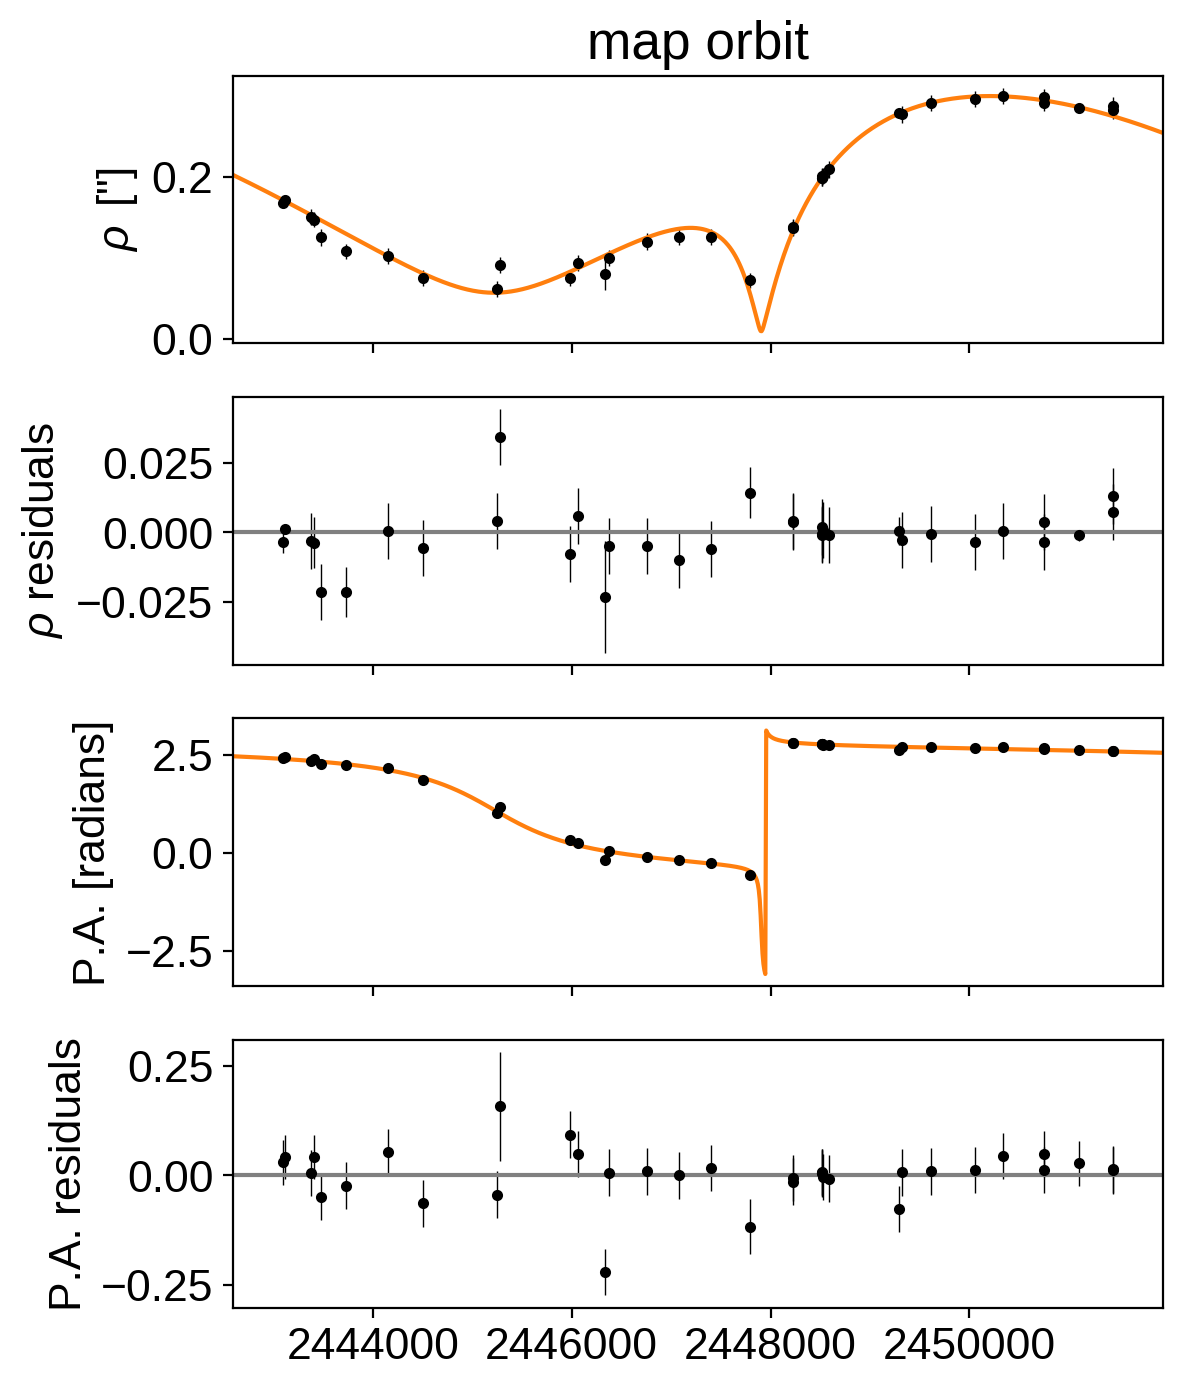

In [9]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(astro_jds, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    astro_jds, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
ax[0].set_title("map orbit");

Now let's sample the posterior.

In [10]:
np.random.seed(1234)
with model:
    trace = pm.sample(
        tune=5000,
        draws=4000,
        start=map_soln,
        step=xo.get_dense_nuts_step(target_accept=0.9, adaptation_window=201),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


Sampling 4 chains:   0%|          | 0/36000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 13/36000 [00:00<05:30, 108.87draws/s]

Sampling 4 chains:   0%|          | 19/36000 [00:00<07:33, 79.40draws/s] 

Sampling 4 chains:   0%|          | 23/36000 [00:00<11:05, 54.05draws/s]

Sampling 4 chains:   0%|          | 28/36000 [00:00<12:17, 48.79draws/s]

Sampling 4 chains:   0%|          | 32/36000 [00:00<13:08, 45.60draws/s]

Sampling 4 chains:   0%|          | 38/36000 [00:00<12:34, 47.65draws/s]

Sampling 4 chains:   0%|          | 43/36000 [00:00<12:40, 47.30draws/s]

Sampling 4 chains:   0%|          | 48/36000 [00:00<13:50, 43.27draws/s]

Sampling 4 chains:   0%|          | 53/36000 [00:01<13:47, 43.44draws/s]

Sampling 4 chains:   0%|          | 58/36000 [00:01<13:20, 44.90draws/s]

Sampling 4 chains:   0%|          | 63/36000 [00:01<13:26, 44.55draws/s]

Sampling 4 chains:   0%|          | 68/36000 [00:01<13:52, 43.17draws/s]

Sampling 4 chains:   0%|          | 74/36000 [00:01<14:32, 41.17draws/s]

Sampling 4 chains:   0%|          | 80/36000 [00:01<13:59, 42.78draws/s]

Sampling 4 chains:   0%|          | 86/36000 [00:01<13:54, 43.05draws/s]

Sampling 4 chains:   0%|          | 91/36000 [00:01<13:21, 44.81draws/s]

Sampling 4 chains:   0%|          | 97/36000 [00:02<14:09, 42.26draws/s]

Sampling 4 chains:   0%|          | 102/36000 [00:02<13:32, 44.20draws/s]

Sampling 4 chains:   0%|          | 108/36000 [00:02<12:35, 47.53draws/s]

Sampling 4 chains:   0%|          | 114/36000 [00:02<12:35, 47.49draws/s]

Sampling 4 chains:   0%|          | 122/36000 [00:02<12:10, 49.11draws/s]

Sampling 4 chains:   0%|          | 128/36000 [00:02<13:46, 43.43draws/s]

Sampling 4 chains:   0%|          | 133/36000 [00:02<13:47, 43.33draws/s]

Sampling 4 chains:   0%|          | 139/36000 [00:03<13:35, 43.98draws/s]

Sampling 4 chains:   0%|          | 145/36000 [00:03<12:50, 46.52draws/s]

Sampling 4 chains:   0%|          | 150/36000 [00:03<13:35, 43.94draws/s]

Sampling 4 chains:   0%|          | 156/36000 [00:03<13:14, 45.10draws/s]

Sampling 4 chains:   0%|          | 162/36000 [00:03<12:28, 47.87draws/s]

Sampling 4 chains:   0%|          | 168/36000 [00:03<12:39, 47.17draws/s]

Sampling 4 chains:   0%|          | 174/36000 [00:03<12:27, 47.94draws/s]

Sampling 4 chains:   0%|          | 179/36000 [00:03<12:57, 46.06draws/s]

Sampling 4 chains:   1%|          | 184/36000 [00:03<13:36, 43.86draws/s]

Sampling 4 chains:   1%|          | 190/36000 [00:04<12:53, 46.30draws/s]

Sampling 4 chains:   1%|          | 196/36000 [00:04<12:19, 48.42draws/s]

Sampling 4 chains:   1%|          | 204/36000 [00:04<11:05, 53.81draws/s]

Sampling 4 chains:   1%|          | 210/36000 [00:04<11:52, 50.23draws/s]

Sampling 4 chains:   1%|          | 216/36000 [00:04<11:39, 51.18draws/s]

Sampling 4 chains:   1%|          | 222/36000 [00:04<11:08, 53.51draws/s]

Sampling 4 chains:   1%|          | 228/36000 [00:04<11:36, 51.37draws/s]

Sampling 4 chains:   1%|          | 234/36000 [00:04<11:39, 51.14draws/s]

Sampling 4 chains:   1%|          | 240/36000 [00:05<12:02, 49.49draws/s]

Sampling 4 chains:   1%|          | 246/36000 [00:05<11:57, 49.83draws/s]

Sampling 4 chains:   1%|          | 252/36000 [00:05<12:00, 49.59draws/s]

Sampling 4 chains:   1%|          | 258/36000 [00:05<12:04, 49.30draws/s]

Sampling 4 chains:   1%|          | 263/36000 [00:05<12:36, 47.26draws/s]

Sampling 4 chains:   1%|          | 271/36000 [00:05<11:58, 49.71draws/s]

Sampling 4 chains:   1%|          | 277/36000 [00:05<12:13, 48.71draws/s]

Sampling 4 chains:   1%|          | 283/36000 [00:05<12:20, 48.20draws/s]

Sampling 4 chains:   1%|          | 289/36000 [00:06<12:09, 48.97draws/s]

Sampling 4 chains:   1%|          | 294/36000 [00:06<12:54, 46.10draws/s]

Sampling 4 chains:   1%|          | 302/36000 [00:06<11:54, 49.99draws/s]

Sampling 4 chains:   1%|          | 309/36000 [00:06<11:20, 52.46draws/s]

Sampling 4 chains:   1%|          | 318/36000 [00:06<10:17, 57.76draws/s]

Sampling 4 chains:   1%|          | 325/36000 [00:06<10:35, 56.12draws/s]

Sampling 4 chains:   1%|          | 333/36000 [00:06<09:45, 60.91draws/s]

Sampling 4 chains:   1%|          | 340/36000 [00:06<10:34, 56.19draws/s]

Sampling 4 chains:   1%|          | 346/36000 [00:07<10:29, 56.60draws/s]

Sampling 4 chains:   1%|          | 352/36000 [00:07<10:55, 54.42draws/s]

Sampling 4 chains:   1%|          | 358/36000 [00:07<11:12, 52.97draws/s]

Sampling 4 chains:   1%|          | 364/36000 [00:07<10:57, 54.16draws/s]

Sampling 4 chains:   1%|          | 370/36000 [00:07<11:48, 50.31draws/s]

Sampling 4 chains:   1%|          | 376/36000 [00:07<11:42, 50.72draws/s]

Sampling 4 chains:   1%|          | 382/36000 [00:07<11:38, 51.01draws/s]

Sampling 4 chains:   1%|          | 389/36000 [00:07<10:42, 55.46draws/s]

Sampling 4 chains:   1%|          | 395/36000 [00:07<10:58, 54.09draws/s]

Sampling 4 chains:   1%|          | 401/36000 [00:08<10:42, 55.41draws/s]

Sampling 4 chains:   1%|          | 407/36000 [00:08<11:38, 50.94draws/s]

Sampling 4 chains:   1%|          | 413/36000 [00:08<11:39, 50.87draws/s]

Sampling 4 chains:   1%|          | 419/36000 [00:08<12:41, 46.74draws/s]

Sampling 4 chains:   1%|          | 424/36000 [00:08<13:07, 45.18draws/s]

Sampling 4 chains:   1%|          | 429/36000 [00:08<13:25, 44.18draws/s]

Sampling 4 chains:   1%|          | 434/36000 [00:08<13:01, 45.50draws/s]

Sampling 4 chains:   1%|          | 440/36000 [00:08<12:17, 48.19draws/s]

Sampling 4 chains:   1%|          | 445/36000 [00:09<12:49, 46.20draws/s]

Sampling 4 chains:   1%|▏         | 450/36000 [00:09<13:30, 43.84draws/s]

Sampling 4 chains:   1%|▏         | 456/36000 [00:09<12:55, 45.86draws/s]

Sampling 4 chains:   1%|▏         | 463/36000 [00:09<12:20, 48.01draws/s]

Sampling 4 chains:   1%|▏         | 469/36000 [00:09<12:22, 47.84draws/s]

Sampling 4 chains:   1%|▏         | 476/36000 [00:09<11:19, 52.31draws/s]

Sampling 4 chains:   1%|▏         | 482/36000 [00:09<11:18, 52.37draws/s]

Sampling 4 chains:   1%|▏         | 488/36000 [00:09<13:04, 45.29draws/s]

Sampling 4 chains:   1%|▏         | 493/36000 [00:10<13:45, 43.01draws/s]

Sampling 4 chains:   1%|▏         | 499/36000 [00:10<13:33, 43.66draws/s]

Sampling 4 chains:   1%|▏         | 505/36000 [00:10<12:52, 45.92draws/s]

Sampling 4 chains:   1%|▏         | 511/36000 [00:10<13:01, 45.40draws/s]

Sampling 4 chains:   1%|▏         | 516/36000 [00:10<12:48, 46.16draws/s]

Sampling 4 chains:   1%|▏         | 521/36000 [00:10<13:36, 43.45draws/s]

Sampling 4 chains:   1%|▏         | 526/36000 [00:10<13:47, 42.89draws/s]

Sampling 4 chains:   1%|▏         | 531/36000 [00:10<13:16, 44.55draws/s]

Sampling 4 chains:   2%|▏         | 540/36000 [00:11<11:36, 50.91draws/s]

Sampling 4 chains:   2%|▏         | 546/36000 [00:11<12:20, 47.86draws/s]

Sampling 4 chains:   2%|▏         | 552/36000 [00:11<12:30, 47.26draws/s]

Sampling 4 chains:   2%|▏         | 557/36000 [00:11<12:58, 45.53draws/s]

Sampling 4 chains:   2%|▏         | 562/36000 [00:11<13:01, 45.32draws/s]

Sampling 4 chains:   2%|▏         | 568/36000 [00:11<12:12, 48.37draws/s]

Sampling 4 chains:   2%|▏         | 573/36000 [00:11<12:11, 48.45draws/s]

Sampling 4 chains:   2%|▏         | 578/36000 [00:11<12:15, 48.13draws/s]

Sampling 4 chains:   2%|▏         | 583/36000 [00:11<13:03, 45.21draws/s]

Sampling 4 chains:   2%|▏         | 588/36000 [00:12<13:11, 44.74draws/s]

Sampling 4 chains:   2%|▏         | 593/36000 [00:12<13:19, 44.26draws/s]

Sampling 4 chains:   2%|▏         | 598/36000 [00:12<12:52, 45.83draws/s]

Sampling 4 chains:   2%|▏         | 603/36000 [00:12<12:53, 45.75draws/s]

Sampling 4 chains:   2%|▏         | 609/36000 [00:12<13:05, 45.07draws/s]

Sampling 4 chains:   2%|▏         | 614/36000 [00:12<15:14, 38.70draws/s]

Sampling 4 chains:   2%|▏         | 622/36000 [00:12<12:59, 45.36draws/s]

Sampling 4 chains:   2%|▏         | 628/36000 [00:12<12:45, 46.24draws/s]

Sampling 4 chains:   2%|▏         | 635/36000 [00:13<11:42, 50.31draws/s]

Sampling 4 chains:   2%|▏         | 642/36000 [00:13<11:01, 53.42draws/s]

Sampling 4 chains:   2%|▏         | 648/36000 [00:13<12:57, 45.45draws/s]

Sampling 4 chains:   2%|▏         | 654/36000 [00:13<12:19, 47.82draws/s]

Sampling 4 chains:   2%|▏         | 660/36000 [00:13<11:58, 49.22draws/s]

Sampling 4 chains:   2%|▏         | 666/36000 [00:13<13:00, 45.24draws/s]

Sampling 4 chains:   2%|▏         | 672/36000 [00:13<12:18, 47.84draws/s]

Sampling 4 chains:   2%|▏         | 678/36000 [00:13<11:49, 49.81draws/s]

Sampling 4 chains:   2%|▏         | 684/36000 [00:14<11:53, 49.51draws/s]

Sampling 4 chains:   2%|▏         | 690/36000 [00:14<11:37, 50.66draws/s]

Sampling 4 chains:   2%|▏         | 696/36000 [00:14<11:31, 51.03draws/s]

Sampling 4 chains:   2%|▏         | 702/36000 [00:14<12:16, 47.93draws/s]

Sampling 4 chains:   2%|▏         | 708/36000 [00:14<12:23, 47.49draws/s]

Sampling 4 chains:   2%|▏         | 715/36000 [00:14<11:50, 49.68draws/s]

Sampling 4 chains:   2%|▏         | 722/36000 [00:14<10:53, 53.99draws/s]

Sampling 4 chains:   2%|▏         | 735/36000 [00:14<08:59, 65.35draws/s]

Sampling 4 chains:   2%|▏         | 753/36000 [00:14<07:17, 80.59draws/s]

Sampling 4 chains:   2%|▏         | 766/36000 [00:15<06:31, 90.06draws/s]

Sampling 4 chains:   2%|▏         | 778/36000 [00:15<06:07, 95.75draws/s]

Sampling 4 chains:   2%|▏         | 792/36000 [00:15<05:33, 105.53draws/s]

Sampling 4 chains:   2%|▏         | 807/36000 [00:15<05:05, 115.20draws/s]

Sampling 4 chains:   2%|▏         | 823/36000 [00:15<04:40, 125.57draws/s]

Sampling 4 chains:   2%|▏         | 838/36000 [00:15<04:32, 128.91draws/s]

Sampling 4 chains:   2%|▏         | 861/36000 [00:15<03:58, 147.21draws/s]

Sampling 4 chains:   2%|▏         | 881/36000 [00:15<03:41, 158.85draws/s]

Sampling 4 chains:   2%|▏         | 899/36000 [00:15<03:36, 161.97draws/s]

Sampling 4 chains:   3%|▎         | 917/36000 [00:16<03:56, 148.60draws/s]

Sampling 4 chains:   3%|▎         | 933/36000 [00:16<04:07, 141.52draws/s]

Sampling 4 chains:   3%|▎         | 948/36000 [00:16<04:07, 141.63draws/s]

Sampling 4 chains:   3%|▎         | 963/36000 [00:16<04:08, 141.20draws/s]

Sampling 4 chains:   3%|▎         | 979/36000 [00:16<04:01, 144.73draws/s]

Sampling 4 chains:   3%|▎         | 994/36000 [00:16<04:12, 138.40draws/s]

Sampling 4 chains:   3%|▎         | 1009/36000 [00:16<04:32, 128.36draws/s]

Sampling 4 chains:   3%|▎         | 1023/36000 [00:16<04:26, 131.13draws/s]

Sampling 4 chains:   3%|▎         | 1037/36000 [00:17<05:03, 115.39draws/s]

Sampling 4 chains:   3%|▎         | 1051/36000 [00:17<04:48, 121.12draws/s]

Sampling 4 chains:   3%|▎         | 1070/36000 [00:17<04:20, 134.21draws/s]

Sampling 4 chains:   3%|▎         | 1085/36000 [00:17<05:00, 116.31draws/s]

Sampling 4 chains:   3%|▎         | 1101/36000 [00:17<04:36, 126.23draws/s]

Sampling 4 chains:   3%|▎         | 1121/36000 [00:17<04:11, 138.82draws/s]

Sampling 4 chains:   3%|▎         | 1139/36000 [00:17<03:54, 148.61draws/s]

Sampling 4 chains:   3%|▎         | 1163/36000 [00:17<03:28, 167.10draws/s]

Sampling 4 chains:   3%|▎         | 1194/36000 [00:17<03:01, 191.43draws/s]

Sampling 4 chains:   3%|▎         | 1216/36000 [00:18<03:03, 189.41draws/s]

Sampling 4 chains:   3%|▎         | 1237/36000 [00:18<03:06, 186.84draws/s]

Sampling 4 chains:   3%|▎         | 1258/36000 [00:18<03:00, 192.70draws/s]

Sampling 4 chains:   4%|▎         | 1287/36000 [00:18<02:43, 211.89draws/s]

Sampling 4 chains:   4%|▎         | 1321/36000 [00:18<02:26, 236.42draws/s]

Sampling 4 chains:   4%|▍         | 1361/36000 [00:18<02:09, 267.87draws/s]

Sampling 4 chains:   4%|▍         | 1401/36000 [00:18<01:56, 297.11draws/s]

Sampling 4 chains:   4%|▍         | 1436/36000 [00:18<01:51, 310.74draws/s]

Sampling 4 chains:   4%|▍         | 1472/36000 [00:18<01:46, 322.97draws/s]

Sampling 4 chains:   4%|▍         | 1511/36000 [00:18<01:41, 339.50draws/s]

Sampling 4 chains:   4%|▍         | 1547/36000 [00:19<01:42, 336.77draws/s]

Sampling 4 chains:   4%|▍         | 1585/36000 [00:19<01:38, 348.01draws/s]

Sampling 4 chains:   5%|▍         | 1631/36000 [00:19<01:31, 375.35draws/s]

Sampling 4 chains:   5%|▍         | 1676/36000 [00:19<01:27, 394.06draws/s]

Sampling 4 chains:   5%|▍         | 1719/36000 [00:19<01:24, 404.11draws/s]

Sampling 4 chains:   5%|▍         | 1762/36000 [00:19<01:23, 409.00draws/s]

Sampling 4 chains:   5%|▌         | 1808/36000 [00:19<01:21, 418.84draws/s]

Sampling 4 chains:   5%|▌         | 1851/36000 [00:19<01:23, 409.82draws/s]

Sampling 4 chains:   5%|▌         | 1893/36000 [00:19<01:23, 409.82draws/s]

Sampling 4 chains:   5%|▌         | 1935/36000 [00:20<01:27, 388.00draws/s]

Sampling 4 chains:   5%|▌         | 1975/36000 [00:20<01:28, 383.99draws/s]

Sampling 4 chains:   6%|▌         | 2019/36000 [00:20<01:25, 395.88draws/s]

Sampling 4 chains:   6%|▌         | 2059/36000 [00:20<01:27, 389.97draws/s]

Sampling 4 chains:   6%|▌         | 2101/36000 [00:20<01:25, 397.54draws/s]

Sampling 4 chains:   6%|▌         | 2148/36000 [00:20<01:21, 415.85draws/s]

Sampling 4 chains:   6%|▌         | 2197/36000 [00:20<01:18, 430.94draws/s]

Sampling 4 chains:   6%|▌         | 2241/36000 [00:20<01:17, 433.38draws/s]

Sampling 4 chains:   6%|▋         | 2285/36000 [00:20<01:19, 426.40draws/s]

Sampling 4 chains:   6%|▋         | 2329/36000 [00:20<01:19, 425.63draws/s]

Sampling 4 chains:   7%|▋         | 2374/36000 [00:21<01:18, 428.51draws/s]

Sampling 4 chains:   7%|▋         | 2417/36000 [00:21<01:21, 413.92draws/s]

Sampling 4 chains:   7%|▋         | 2459/36000 [00:21<01:21, 409.52draws/s]

Sampling 4 chains:   7%|▋         | 2501/36000 [00:21<01:27, 381.86draws/s]

Sampling 4 chains:   7%|▋         | 2540/36000 [00:21<01:30, 371.63draws/s]

Sampling 4 chains:   7%|▋         | 2578/36000 [00:21<01:32, 361.02draws/s]

Sampling 4 chains:   7%|▋         | 2617/36000 [00:21<01:31, 366.72draws/s]

Sampling 4 chains:   7%|▋         | 2654/36000 [00:21<01:32, 360.41draws/s]

Sampling 4 chains:   7%|▋         | 2691/36000 [00:21<01:32, 360.86draws/s]

Sampling 4 chains:   8%|▊         | 2728/36000 [00:22<01:32, 360.34draws/s]

Sampling 4 chains:   8%|▊         | 2765/36000 [00:22<01:32, 359.18draws/s]

Sampling 4 chains:   8%|▊         | 2801/36000 [00:22<01:33, 354.06draws/s]

Sampling 4 chains:   8%|▊         | 2842/36000 [00:22<01:30, 367.95draws/s]

Sampling 4 chains:   8%|▊         | 2889/36000 [00:22<01:24, 393.39draws/s]

Sampling 4 chains:   8%|▊         | 2929/36000 [00:22<01:26, 381.26draws/s]

Sampling 4 chains:   8%|▊         | 2968/36000 [00:22<01:31, 361.76draws/s]

Sampling 4 chains:   8%|▊         | 3005/36000 [00:22<01:33, 351.36draws/s]

Sampling 4 chains:   8%|▊         | 3048/36000 [00:22<01:28, 371.44draws/s]

Sampling 4 chains:   9%|▊         | 3086/36000 [00:23<01:34, 348.55draws/s]

Sampling 4 chains:   9%|▊         | 3122/36000 [00:23<01:35, 342.50draws/s]

Sampling 4 chains:   9%|▉         | 3157/36000 [00:23<01:39, 330.40draws/s]

Sampling 4 chains:   9%|▉         | 3195/36000 [00:23<01:35, 343.32draws/s]

Sampling 4 chains:   9%|▉         | 3234/36000 [00:23<01:32, 354.22draws/s]

Sampling 4 chains:   9%|▉         | 3275/36000 [00:23<01:28, 369.22draws/s]

Sampling 4 chains:   9%|▉         | 3313/36000 [00:23<01:31, 358.67draws/s]

Sampling 4 chains:   9%|▉         | 3355/36000 [00:23<01:27, 374.32draws/s]

Sampling 4 chains:   9%|▉         | 3394/36000 [00:23<01:26, 377.35draws/s]

Sampling 4 chains:  10%|▉         | 3433/36000 [00:23<01:27, 371.03draws/s]

Sampling 4 chains:  10%|▉         | 3471/36000 [00:24<01:27, 371.24draws/s]

Sampling 4 chains:  10%|▉         | 3509/36000 [00:24<01:27, 370.52draws/s]

Sampling 4 chains:  10%|▉         | 3549/36000 [00:24<01:25, 378.65draws/s]

Sampling 4 chains:  10%|▉         | 3587/36000 [00:24<01:28, 368.09draws/s]

Sampling 4 chains:  10%|█         | 3624/36000 [00:24<01:28, 364.21draws/s]

Sampling 4 chains:  10%|█         | 3665/36000 [00:24<01:25, 376.72draws/s]

Sampling 4 chains:  10%|█         | 3703/36000 [00:24<01:26, 374.93draws/s]

Sampling 4 chains:  10%|█         | 3741/36000 [00:24<01:27, 368.10draws/s]

Sampling 4 chains:  11%|█         | 3781/36000 [00:24<01:25, 376.92draws/s]

Sampling 4 chains:  11%|█         | 3819/36000 [00:25<01:25, 375.01draws/s]

Sampling 4 chains:  11%|█         | 3857/36000 [00:25<01:25, 374.48draws/s]

Sampling 4 chains:  11%|█         | 3895/36000 [00:25<01:28, 362.61draws/s]

Sampling 4 chains:  11%|█         | 3932/36000 [00:25<01:29, 358.26draws/s]

Sampling 4 chains:  11%|█         | 3972/36000 [00:25<01:26, 368.86draws/s]

Sampling 4 chains:  11%|█         | 4012/36000 [00:25<01:26, 370.31draws/s]

Sampling 4 chains:  11%|█▏        | 4050/36000 [00:25<01:26, 367.97draws/s]

Sampling 4 chains:  11%|█▏        | 4093/36000 [00:25<01:23, 383.40draws/s]

Sampling 4 chains:  11%|█▏        | 4138/36000 [00:25<01:19, 400.05draws/s]

Sampling 4 chains:  12%|█▏        | 4179/36000 [00:25<01:20, 397.24draws/s]

Sampling 4 chains:  12%|█▏        | 4221/36000 [00:26<01:18, 402.67draws/s]

Sampling 4 chains:  12%|█▏        | 4262/36000 [00:26<01:22, 383.21draws/s]

Sampling 4 chains:  12%|█▏        | 4301/36000 [00:26<01:23, 379.89draws/s]

Sampling 4 chains:  12%|█▏        | 4347/36000 [00:26<01:19, 398.82draws/s]

Sampling 4 chains:  12%|█▏        | 4388/36000 [00:26<01:19, 397.51draws/s]

Sampling 4 chains:  12%|█▏        | 4430/36000 [00:26<01:18, 403.75draws/s]

Sampling 4 chains:  12%|█▏        | 4471/36000 [00:26<01:18, 401.76draws/s]

Sampling 4 chains:  13%|█▎        | 4512/36000 [00:26<01:24, 371.31draws/s]

Sampling 4 chains:  13%|█▎        | 4557/36000 [00:26<01:20, 391.25draws/s]

Sampling 4 chains:  13%|█▎        | 4597/36000 [00:27<01:22, 382.20draws/s]

Sampling 4 chains:  13%|█▎        | 4639/36000 [00:27<01:19, 392.71draws/s]

Sampling 4 chains:  13%|█▎        | 4679/36000 [00:27<01:20, 388.40draws/s]

Sampling 4 chains:  13%|█▎        | 4719/36000 [00:27<01:25, 366.66draws/s]

Sampling 4 chains:  13%|█▎        | 4757/36000 [00:27<01:28, 354.91draws/s]

Sampling 4 chains:  13%|█▎        | 4801/36000 [00:27<01:23, 373.84draws/s]

Sampling 4 chains:  13%|█▎        | 4843/36000 [00:27<01:21, 382.49draws/s]

Sampling 4 chains:  14%|█▎        | 4887/36000 [00:27<01:18, 396.27draws/s]

Sampling 4 chains:  14%|█▎        | 4928/36000 [00:27<01:22, 378.55draws/s]

Sampling 4 chains:  14%|█▍        | 4967/36000 [00:27<01:21, 378.80draws/s]

Sampling 4 chains:  14%|█▍        | 5006/36000 [00:28<01:23, 372.77draws/s]

Sampling 4 chains:  14%|█▍        | 5046/36000 [00:28<01:21, 377.72draws/s]

Sampling 4 chains:  14%|█▍        | 5087/36000 [00:28<01:20, 385.97draws/s]

Sampling 4 chains:  14%|█▍        | 5126/36000 [00:28<01:20, 381.59draws/s]

Sampling 4 chains:  14%|█▍        | 5168/36000 [00:28<01:19, 387.87draws/s]

Sampling 4 chains:  14%|█▍        | 5207/36000 [00:28<01:22, 375.50draws/s]

Sampling 4 chains:  15%|█▍        | 5248/36000 [00:28<01:20, 384.34draws/s]

Sampling 4 chains:  15%|█▍        | 5292/36000 [00:28<01:17, 396.58draws/s]

Sampling 4 chains:  15%|█▍        | 5332/36000 [00:28<01:23, 368.55draws/s]

Sampling 4 chains:  15%|█▍        | 5371/36000 [00:29<01:22, 370.76draws/s]

Sampling 4 chains:  15%|█▌        | 5409/36000 [00:29<01:22, 372.28draws/s]

Sampling 4 chains:  15%|█▌        | 5447/36000 [00:29<01:23, 367.49draws/s]

Sampling 4 chains:  15%|█▌        | 5486/36000 [00:29<01:22, 371.67draws/s]

Sampling 4 chains:  15%|█▌        | 5526/36000 [00:29<01:21, 374.55draws/s]

Sampling 4 chains:  15%|█▌        | 5567/36000 [00:29<01:19, 383.41draws/s]

Sampling 4 chains:  16%|█▌        | 5606/36000 [00:29<01:19, 382.46draws/s]

Sampling 4 chains:  16%|█▌        | 5645/36000 [00:29<01:20, 375.30draws/s]

Sampling 4 chains:  16%|█▌        | 5683/36000 [00:29<01:21, 371.46draws/s]

Sampling 4 chains:  16%|█▌        | 5729/36000 [00:29<01:17, 392.04draws/s]

Sampling 4 chains:  16%|█▌        | 5769/36000 [00:30<01:16, 393.62draws/s]

Sampling 4 chains:  16%|█▌        | 5809/36000 [00:30<01:16, 393.88draws/s]

Sampling 4 chains:  16%|█▌        | 5849/36000 [00:30<01:17, 389.80draws/s]

Sampling 4 chains:  16%|█▋        | 5889/36000 [00:30<01:16, 391.32draws/s]

Sampling 4 chains:  16%|█▋        | 5932/36000 [00:30<01:15, 400.34draws/s]

Sampling 4 chains:  17%|█▋        | 5973/36000 [00:30<01:16, 394.24draws/s]

Sampling 4 chains:  17%|█▋        | 6017/36000 [00:30<01:13, 405.18draws/s]

Sampling 4 chains:  17%|█▋        | 6058/36000 [00:30<01:16, 392.00draws/s]

Sampling 4 chains:  17%|█▋        | 6098/36000 [00:30<01:16, 391.85draws/s]

Sampling 4 chains:  17%|█▋        | 6139/36000 [00:31<01:16, 391.16draws/s]

Sampling 4 chains:  17%|█▋        | 6179/36000 [00:31<01:17, 384.39draws/s]

Sampling 4 chains:  17%|█▋        | 6218/36000 [00:31<01:17, 382.43draws/s]

Sampling 4 chains:  17%|█▋        | 6257/36000 [00:31<01:19, 372.28draws/s]

Sampling 4 chains:  17%|█▋        | 6298/36000 [00:31<01:18, 380.09draws/s]

Sampling 4 chains:  18%|█▊        | 6337/36000 [00:31<01:22, 361.26draws/s]

Sampling 4 chains:  18%|█▊        | 6374/36000 [00:31<01:22, 358.52draws/s]

Sampling 4 chains:  18%|█▊        | 6413/36000 [00:31<01:20, 367.03draws/s]

Sampling 4 chains:  18%|█▊        | 6457/36000 [00:31<01:16, 384.10draws/s]

Sampling 4 chains:  18%|█▊        | 6496/36000 [00:32<01:20, 367.75draws/s]

Sampling 4 chains:  18%|█▊        | 6534/36000 [00:32<01:19, 370.71draws/s]

Sampling 4 chains:  18%|█▊        | 6574/36000 [00:32<01:17, 378.31draws/s]

Sampling 4 chains:  18%|█▊        | 6613/36000 [00:32<01:20, 364.79draws/s]

Sampling 4 chains:  18%|█▊        | 6657/36000 [00:32<01:16, 383.55draws/s]

Sampling 4 chains:  19%|█▊        | 6696/36000 [00:32<01:19, 369.30draws/s]

Sampling 4 chains:  19%|█▊        | 6735/36000 [00:32<01:18, 373.04draws/s]

Sampling 4 chains:  19%|█▉        | 6773/36000 [00:32<01:20, 362.27draws/s]

Sampling 4 chains:  19%|█▉        | 6810/36000 [00:32<01:26, 337.19draws/s]

Sampling 4 chains:  19%|█▉        | 6845/36000 [00:32<01:27, 333.77draws/s]

Sampling 4 chains:  19%|█▉        | 6879/36000 [00:33<01:27, 333.86draws/s]

Sampling 4 chains:  19%|█▉        | 6913/36000 [00:33<01:28, 328.63draws/s]

Sampling 4 chains:  19%|█▉        | 6949/36000 [00:33<01:26, 337.32draws/s]

Sampling 4 chains:  19%|█▉        | 6986/36000 [00:33<01:24, 344.79draws/s]

Sampling 4 chains:  20%|█▉        | 7030/36000 [00:33<01:19, 366.36draws/s]

Sampling 4 chains:  20%|█▉        | 7076/36000 [00:33<01:14, 388.98draws/s]

Sampling 4 chains:  20%|█▉        | 7121/36000 [00:33<01:12, 400.72draws/s]

Sampling 4 chains:  20%|█▉        | 7162/36000 [00:33<01:14, 387.60draws/s]

Sampling 4 chains:  20%|██        | 7202/36000 [00:33<01:15, 379.23draws/s]

Sampling 4 chains:  20%|██        | 7241/36000 [00:34<01:18, 366.77draws/s]

Sampling 4 chains:  20%|██        | 7279/36000 [00:34<01:19, 361.02draws/s]

Sampling 4 chains:  20%|██        | 7316/36000 [00:34<01:24, 339.06draws/s]

Sampling 4 chains:  20%|██        | 7352/36000 [00:34<01:24, 340.04draws/s]

Sampling 4 chains:  21%|██        | 7387/36000 [00:34<01:25, 334.87draws/s]

Sampling 4 chains:  21%|██        | 7421/36000 [00:34<01:25, 332.39draws/s]

Sampling 4 chains:  21%|██        | 7460/36000 [00:34<01:22, 346.22draws/s]

Sampling 4 chains:  21%|██        | 7495/36000 [00:34<01:23, 341.01draws/s]

Sampling 4 chains:  21%|██        | 7536/36000 [00:34<01:19, 358.92draws/s]

Sampling 4 chains:  21%|██        | 7573/36000 [00:35<01:19, 358.60draws/s]

Sampling 4 chains:  21%|██        | 7610/36000 [00:35<01:21, 350.28draws/s]

Sampling 4 chains:  21%|██        | 7646/36000 [00:35<01:29, 318.19draws/s]

Sampling 4 chains:  21%|██▏       | 7683/36000 [00:35<01:25, 331.74draws/s]

Sampling 4 chains:  21%|██▏       | 7726/36000 [00:35<01:20, 352.67draws/s]

Sampling 4 chains:  22%|██▏       | 7767/36000 [00:35<01:16, 368.01draws/s]

Sampling 4 chains:  22%|██▏       | 7806/36000 [00:35<01:15, 373.70draws/s]

Sampling 4 chains:  22%|██▏       | 7844/36000 [00:35<01:15, 374.25draws/s]

Sampling 4 chains:  22%|██▏       | 7887/36000 [00:35<01:12, 388.46draws/s]

Sampling 4 chains:  22%|██▏       | 7928/36000 [00:35<01:11, 394.13draws/s]

Sampling 4 chains:  22%|██▏       | 7971/36000 [00:36<01:09, 401.22draws/s]

Sampling 4 chains:  22%|██▏       | 8012/36000 [00:36<01:16, 364.12draws/s]

Sampling 4 chains:  22%|██▏       | 8050/36000 [00:36<01:17, 361.36draws/s]

Sampling 4 chains:  22%|██▏       | 8089/36000 [00:36<01:15, 368.89draws/s]

Sampling 4 chains:  23%|██▎       | 8127/36000 [00:36<01:16, 363.92draws/s]

Sampling 4 chains:  23%|██▎       | 8164/36000 [00:36<01:17, 359.36draws/s]

Sampling 4 chains:  23%|██▎       | 8201/36000 [00:36<01:17, 358.39draws/s]

Sampling 4 chains:  23%|██▎       | 8238/36000 [00:36<01:23, 332.44draws/s]

Sampling 4 chains:  23%|██▎       | 8272/36000 [00:36<01:23, 330.33draws/s]

Sampling 4 chains:  23%|██▎       | 8309/36000 [00:37<01:21, 340.76draws/s]

Sampling 4 chains:  23%|██▎       | 8349/36000 [00:37<01:17, 355.50draws/s]

Sampling 4 chains:  23%|██▎       | 8385/36000 [00:37<01:18, 353.21draws/s]

Sampling 4 chains:  23%|██▎       | 8425/36000 [00:37<01:15, 363.66draws/s]

Sampling 4 chains:  24%|██▎       | 8466/36000 [00:37<01:13, 373.14draws/s]

Sampling 4 chains:  24%|██▎       | 8509/36000 [00:37<01:10, 387.38draws/s]

Sampling 4 chains:  24%|██▎       | 8549/36000 [00:37<01:10, 387.03draws/s]

Sampling 4 chains:  24%|██▍       | 8588/36000 [00:37<01:11, 384.33draws/s]

Sampling 4 chains:  24%|██▍       | 8627/36000 [00:37<01:11, 380.45draws/s]

Sampling 4 chains:  24%|██▍       | 8667/36000 [00:37<01:10, 385.19draws/s]

Sampling 4 chains:  24%|██▍       | 8706/36000 [00:38<01:12, 376.55draws/s]

Sampling 4 chains:  24%|██▍       | 8744/36000 [00:38<01:14, 367.31draws/s]

Sampling 4 chains:  24%|██▍       | 8791/36000 [00:38<01:09, 392.76draws/s]

Sampling 4 chains:  25%|██▍       | 8831/36000 [00:38<01:09, 392.01draws/s]

Sampling 4 chains:  25%|██▍       | 8871/36000 [00:38<01:09, 389.82draws/s]

Sampling 4 chains:  25%|██▍       | 8915/36000 [00:38<01:07, 402.80draws/s]

Sampling 4 chains:  25%|██▍       | 8956/36000 [00:38<01:09, 390.79draws/s]

Sampling 4 chains:  25%|██▍       | 8996/36000 [00:38<01:12, 371.42draws/s]

Sampling 4 chains:  25%|██▌       | 9034/36000 [00:38<01:14, 364.22draws/s]

Sampling 4 chains:  25%|██▌       | 9072/36000 [00:39<01:13, 368.81draws/s]

Sampling 4 chains:  25%|██▌       | 9111/36000 [00:39<01:12, 373.34draws/s]

Sampling 4 chains:  25%|██▌       | 9155/36000 [00:39<01:08, 389.66draws/s]

Sampling 4 chains:  26%|██▌       | 9196/36000 [00:39<01:08, 393.97draws/s]

Sampling 4 chains:  26%|██▌       | 9236/36000 [00:39<01:08, 388.43draws/s]

Sampling 4 chains:  26%|██▌       | 9276/36000 [00:39<01:10, 377.57draws/s]

Sampling 4 chains:  26%|██▌       | 9321/36000 [00:39<01:07, 396.05draws/s]

Sampling 4 chains:  26%|██▌       | 9367/36000 [00:39<01:04, 412.46draws/s]

Sampling 4 chains:  26%|██▌       | 9409/36000 [00:39<01:04, 410.68draws/s]

Sampling 4 chains:  26%|██▋       | 9451/36000 [00:39<01:06, 397.99draws/s]

Sampling 4 chains:  26%|██▋       | 9492/36000 [00:40<01:07, 390.49draws/s]

Sampling 4 chains:  26%|██▋       | 9534/36000 [00:40<01:06, 396.13draws/s]

Sampling 4 chains:  27%|██▋       | 9577/36000 [00:40<01:05, 405.45draws/s]

Sampling 4 chains:  27%|██▋       | 9623/36000 [00:40<01:03, 418.58draws/s]

Sampling 4 chains:  27%|██▋       | 9674/36000 [00:40<00:59, 440.88draws/s]

Sampling 4 chains:  27%|██▋       | 9719/36000 [00:40<01:04, 404.71draws/s]

Sampling 4 chains:  27%|██▋       | 9761/36000 [00:40<01:06, 393.98draws/s]

Sampling 4 chains:  27%|██▋       | 9802/36000 [00:40<01:07, 390.87draws/s]

Sampling 4 chains:  27%|██▋       | 9848/36000 [00:40<01:04, 406.19draws/s]

Sampling 4 chains:  27%|██▋       | 9897/36000 [00:41<01:01, 424.08draws/s]

Sampling 4 chains:  28%|██▊       | 9947/36000 [00:41<00:58, 443.94draws/s]

Sampling 4 chains:  28%|██▊       | 9993/36000 [00:41<00:59, 439.77draws/s]

Sampling 4 chains:  28%|██▊       | 10038/36000 [00:41<01:00, 427.33draws/s]

Sampling 4 chains:  28%|██▊       | 10082/36000 [00:41<01:03, 405.99draws/s]

Sampling 4 chains:  28%|██▊       | 10124/36000 [00:41<01:07, 384.45draws/s]

Sampling 4 chains:  28%|██▊       | 10164/36000 [00:41<01:08, 375.70draws/s]

Sampling 4 chains:  28%|██▊       | 10212/36000 [00:41<01:04, 401.16draws/s]

Sampling 4 chains:  28%|██▊       | 10253/36000 [00:41<01:06, 388.57draws/s]

Sampling 4 chains:  29%|██▊       | 10293/36000 [00:42<01:09, 372.26draws/s]

Sampling 4 chains:  29%|██▊       | 10331/36000 [00:42<01:11, 360.62draws/s]

Sampling 4 chains:  29%|██▉       | 10373/36000 [00:42<01:08, 373.43draws/s]

Sampling 4 chains:  29%|██▉       | 10411/36000 [00:42<01:09, 369.04draws/s]

Sampling 4 chains:  29%|██▉       | 10452/36000 [00:42<01:07, 379.44draws/s]

Sampling 4 chains:  29%|██▉       | 10495/36000 [00:42<01:04, 392.38draws/s]

Sampling 4 chains:  29%|██▉       | 10535/36000 [00:42<01:06, 381.94draws/s]

Sampling 4 chains:  29%|██▉       | 10574/36000 [00:42<01:06, 382.16draws/s]

Sampling 4 chains:  29%|██▉       | 10613/36000 [00:42<01:06, 379.94draws/s]

Sampling 4 chains:  30%|██▉       | 10653/36000 [00:43<01:05, 385.10draws/s]

Sampling 4 chains:  30%|██▉       | 10696/36000 [00:43<01:03, 397.41draws/s]

Sampling 4 chains:  30%|██▉       | 10737/36000 [00:43<01:03, 400.24draws/s]

Sampling 4 chains:  30%|██▉       | 10778/36000 [00:43<01:04, 390.78draws/s]

Sampling 4 chains:  30%|███       | 10818/36000 [00:43<01:04, 389.15draws/s]

Sampling 4 chains:  30%|███       | 10858/36000 [00:43<01:05, 385.51draws/s]

Sampling 4 chains:  30%|███       | 10897/36000 [00:43<01:08, 365.16draws/s]

Sampling 4 chains:  30%|███       | 10939/36000 [00:43<01:05, 379.98draws/s]

Sampling 4 chains:  30%|███       | 10978/36000 [00:43<01:05, 382.82draws/s]

Sampling 4 chains:  31%|███       | 11020/36000 [00:43<01:03, 392.38draws/s]

Sampling 4 chains:  31%|███       | 11060/36000 [00:44<01:06, 376.68draws/s]

Sampling 4 chains:  31%|███       | 11098/36000 [00:44<01:05, 377.50draws/s]

Sampling 4 chains:  31%|███       | 11140/36000 [00:44<01:04, 386.25draws/s]

Sampling 4 chains:  31%|███       | 11182/36000 [00:44<01:02, 394.75draws/s]

Sampling 4 chains:  31%|███       | 11222/36000 [00:44<01:06, 370.93draws/s]

Sampling 4 chains:  31%|███▏      | 11260/36000 [00:44<01:09, 356.48draws/s]

Sampling 4 chains:  31%|███▏      | 11302/36000 [00:44<01:06, 373.05draws/s]

Sampling 4 chains:  32%|███▏      | 11345/36000 [00:44<01:03, 387.08draws/s]

Sampling 4 chains:  32%|███▏      | 11388/36000 [00:44<01:02, 394.66draws/s]

Sampling 4 chains:  32%|███▏      | 11429/36000 [00:45<01:01, 396.80draws/s]

Sampling 4 chains:  32%|███▏      | 11469/36000 [00:45<01:03, 386.27draws/s]

Sampling 4 chains:  32%|███▏      | 11508/36000 [00:45<01:03, 382.87draws/s]

Sampling 4 chains:  32%|███▏      | 11554/36000 [00:45<01:00, 402.54draws/s]

Sampling 4 chains:  32%|███▏      | 11595/36000 [00:45<01:02, 388.93draws/s]

Sampling 4 chains:  32%|███▏      | 11635/36000 [00:45<01:04, 376.20draws/s]

Sampling 4 chains:  32%|███▏      | 11674/36000 [00:45<01:04, 374.80draws/s]

Sampling 4 chains:  33%|███▎      | 11720/36000 [00:45<01:01, 395.21draws/s]

Sampling 4 chains:  33%|███▎      | 11768/36000 [00:45<00:58, 415.44draws/s]

Sampling 4 chains:  33%|███▎      | 11816/36000 [00:45<00:56, 431.00draws/s]

Sampling 4 chains:  33%|███▎      | 11860/36000 [00:46<00:56, 426.24draws/s]

Sampling 4 chains:  33%|███▎      | 11905/36000 [00:46<00:55, 432.22draws/s]

Sampling 4 chains:  33%|███▎      | 11949/36000 [00:46<00:58, 409.50draws/s]

Sampling 4 chains:  33%|███▎      | 11991/36000 [00:46<01:00, 395.74draws/s]

Sampling 4 chains:  33%|███▎      | 12032/36000 [00:46<00:59, 399.84draws/s]

Sampling 4 chains:  34%|███▎      | 12073/36000 [00:46<01:00, 393.52draws/s]

Sampling 4 chains:  34%|███▎      | 12114/36000 [00:46<01:00, 396.48draws/s]

Sampling 4 chains:  34%|███▍      | 12154/36000 [00:46<01:02, 384.15draws/s]

Sampling 4 chains:  34%|███▍      | 12194/36000 [00:46<01:01, 387.49draws/s]

Sampling 4 chains:  34%|███▍      | 12236/36000 [00:47<01:00, 394.06draws/s]

Sampling 4 chains:  34%|███▍      | 12276/36000 [00:47<01:05, 363.50draws/s]

Sampling 4 chains:  34%|███▍      | 12313/36000 [00:47<01:05, 359.07draws/s]

Sampling 4 chains:  34%|███▍      | 12359/36000 [00:47<01:01, 383.71draws/s]

Sampling 4 chains:  34%|███▍      | 12404/36000 [00:47<00:58, 400.42draws/s]

Sampling 4 chains:  35%|███▍      | 12450/36000 [00:47<00:56, 414.22draws/s]

Sampling 4 chains:  35%|███▍      | 12493/36000 [00:47<01:03, 371.62draws/s]

Sampling 4 chains:  35%|███▍      | 12532/36000 [00:47<01:03, 367.81draws/s]

Sampling 4 chains:  35%|███▍      | 12570/36000 [00:47<01:03, 369.43draws/s]

Sampling 4 chains:  35%|███▌      | 12609/36000 [00:48<01:02, 375.10draws/s]

Sampling 4 chains:  35%|███▌      | 12651/36000 [00:48<01:00, 385.63draws/s]

Sampling 4 chains:  35%|███▌      | 12691/36000 [00:48<00:59, 389.64draws/s]

Sampling 4 chains:  35%|███▌      | 12731/36000 [00:48<01:02, 370.66draws/s]

Sampling 4 chains:  35%|███▌      | 12769/36000 [00:48<01:05, 355.92draws/s]

Sampling 4 chains:  36%|███▌      | 12808/36000 [00:48<01:03, 363.53draws/s]

Sampling 4 chains:  36%|███▌      | 12853/36000 [00:48<01:00, 383.17draws/s]

Sampling 4 chains:  36%|███▌      | 12892/36000 [00:48<01:00, 384.55draws/s]

Sampling 4 chains:  36%|███▌      | 12931/36000 [00:48<01:02, 368.36draws/s]

Sampling 4 chains:  36%|███▌      | 12969/36000 [00:49<01:06, 348.29draws/s]

Sampling 4 chains:  36%|███▌      | 13005/36000 [00:49<01:05, 350.57draws/s]

Sampling 4 chains:  36%|███▋      | 13051/36000 [00:49<01:01, 374.95draws/s]

Sampling 4 chains:  36%|███▋      | 13093/36000 [00:49<00:59, 384.31draws/s]

Sampling 4 chains:  36%|███▋      | 13134/36000 [00:49<00:58, 390.33draws/s]

Sampling 4 chains:  37%|███▋      | 13176/36000 [00:49<00:57, 396.98draws/s]

Sampling 4 chains:  37%|███▋      | 13220/36000 [00:49<00:55, 408.83draws/s]

Sampling 4 chains:  37%|███▋      | 13265/36000 [00:49<00:54, 415.25draws/s]

Sampling 4 chains:  37%|███▋      | 13307/36000 [00:49<00:57, 398.05draws/s]

Sampling 4 chains:  37%|███▋      | 13348/36000 [00:49<00:58, 387.38draws/s]

Sampling 4 chains:  37%|███▋      | 13389/36000 [00:50<00:57, 391.48draws/s]

Sampling 4 chains:  37%|███▋      | 13438/36000 [00:50<00:54, 413.23draws/s]

Sampling 4 chains:  37%|███▋      | 13481/36000 [00:50<00:54, 416.24draws/s]

Sampling 4 chains:  38%|███▊      | 13523/36000 [00:50<00:55, 407.49draws/s]

Sampling 4 chains:  38%|███▊      | 13565/36000 [00:50<00:57, 388.90draws/s]

Sampling 4 chains:  38%|███▊      | 13605/36000 [00:50<00:58, 385.82draws/s]

Sampling 4 chains:  38%|███▊      | 13644/36000 [00:50<00:58, 381.87draws/s]

Sampling 4 chains:  38%|███▊      | 13683/36000 [00:50<01:03, 350.53draws/s]

Sampling 4 chains:  38%|███▊      | 13719/36000 [00:50<01:07, 327.93draws/s]

Sampling 4 chains:  38%|███▊      | 13753/36000 [00:51<01:13, 301.70draws/s]

Sampling 4 chains:  38%|███▊      | 13786/36000 [00:51<01:12, 306.87draws/s]

Sampling 4 chains:  38%|███▊      | 13821/36000 [00:51<01:10, 315.33draws/s]

Sampling 4 chains:  39%|███▊      | 13861/36000 [00:51<01:05, 336.44draws/s]

Sampling 4 chains:  39%|███▊      | 13901/36000 [00:51<01:02, 351.88draws/s]

Sampling 4 chains:  39%|███▊      | 13940/36000 [00:51<01:01, 361.50draws/s]

Sampling 4 chains:  39%|███▉      | 13983/36000 [00:51<00:58, 376.39draws/s]

Sampling 4 chains:  39%|███▉      | 14029/36000 [00:51<00:55, 394.78draws/s]

Sampling 4 chains:  39%|███▉      | 14070/36000 [00:51<00:55, 394.47draws/s]

Sampling 4 chains:  39%|███▉      | 14110/36000 [00:52<00:58, 374.77draws/s]

Sampling 4 chains:  39%|███▉      | 14148/36000 [00:52<00:58, 373.67draws/s]

Sampling 4 chains:  39%|███▉      | 14186/36000 [00:52<00:58, 369.87draws/s]

Sampling 4 chains:  40%|███▉      | 14229/36000 [00:52<00:56, 385.69draws/s]

Sampling 4 chains:  40%|███▉      | 14274/36000 [00:52<00:53, 402.69draws/s]

Sampling 4 chains:  40%|███▉      | 14315/36000 [00:52<00:54, 394.42draws/s]

Sampling 4 chains:  40%|███▉      | 14355/36000 [00:52<00:54, 394.49draws/s]

Sampling 4 chains:  40%|███▉      | 14398/36000 [00:52<00:53, 403.01draws/s]

Sampling 4 chains:  40%|████      | 14439/36000 [00:52<00:57, 377.47draws/s]

Sampling 4 chains:  40%|████      | 14478/36000 [00:53<01:00, 354.14draws/s]

Sampling 4 chains:  40%|████      | 14517/36000 [00:53<00:59, 361.17draws/s]

Sampling 4 chains:  40%|████      | 14554/36000 [00:53<01:00, 356.27draws/s]

Sampling 4 chains:  41%|████      | 14590/36000 [00:53<01:01, 348.18draws/s]

Sampling 4 chains:  41%|████      | 14626/36000 [00:53<01:01, 345.89draws/s]

Sampling 4 chains:  41%|████      | 14664/36000 [00:53<01:00, 354.13draws/s]

Sampling 4 chains:  41%|████      | 14700/36000 [00:53<01:02, 341.40draws/s]

Sampling 4 chains:  41%|████      | 14735/36000 [00:53<01:01, 343.35draws/s]

Sampling 4 chains:  41%|████      | 14774/36000 [00:53<00:59, 355.17draws/s]

Sampling 4 chains:  41%|████      | 14810/36000 [00:53<01:00, 350.09draws/s]

Sampling 4 chains:  41%|████▏     | 14860/36000 [00:54<00:55, 383.32draws/s]

Sampling 4 chains:  41%|████▏     | 14901/36000 [00:54<00:54, 389.51draws/s]

Sampling 4 chains:  42%|████▏     | 14943/36000 [00:54<00:53, 395.89draws/s]

Sampling 4 chains:  42%|████▏     | 14990/36000 [00:54<00:50, 413.40draws/s]

Sampling 4 chains:  42%|████▏     | 15032/36000 [00:54<00:52, 396.39draws/s]

Sampling 4 chains:  42%|████▏     | 15073/36000 [00:54<00:55, 376.17draws/s]

Sampling 4 chains:  42%|████▏     | 15112/36000 [00:54<00:59, 351.43draws/s]

Sampling 4 chains:  42%|████▏     | 15148/36000 [00:54<01:01, 339.93draws/s]

Sampling 4 chains:  42%|████▏     | 15183/36000 [00:54<01:02, 335.10draws/s]

Sampling 4 chains:  42%|████▏     | 15220/36000 [00:55<01:00, 341.04draws/s]

Sampling 4 chains:  42%|████▏     | 15259/36000 [00:55<00:59, 350.07draws/s]

Sampling 4 chains:  42%|████▏     | 15295/36000 [00:55<00:58, 351.61draws/s]

Sampling 4 chains:  43%|████▎     | 15331/36000 [00:55<01:00, 342.86draws/s]

Sampling 4 chains:  43%|████▎     | 15369/36000 [00:55<00:58, 352.30draws/s]

Sampling 4 chains:  43%|████▎     | 15407/36000 [00:55<00:57, 355.70draws/s]

Sampling 4 chains:  43%|████▎     | 15446/36000 [00:55<00:56, 364.70draws/s]

Sampling 4 chains:  43%|████▎     | 15486/36000 [00:55<00:56, 365.40draws/s]

Sampling 4 chains:  43%|████▎     | 15527/36000 [00:55<00:54, 373.54draws/s]

Sampling 4 chains:  43%|████▎     | 15565/36000 [00:56<00:56, 359.79draws/s]

Sampling 4 chains:  43%|████▎     | 15602/36000 [00:56<00:58, 347.72draws/s]

Sampling 4 chains:  43%|████▎     | 15637/36000 [00:56<01:02, 323.71draws/s]

Sampling 4 chains:  44%|████▎     | 15677/36000 [00:56<00:59, 341.62draws/s]

Sampling 4 chains:  44%|████▎     | 15714/36000 [00:56<00:58, 349.65draws/s]

Sampling 4 chains:  44%|████▍     | 15750/36000 [00:56<01:00, 333.12draws/s]

Sampling 4 chains:  44%|████▍     | 15785/36000 [00:56<01:00, 336.14draws/s]

Sampling 4 chains:  44%|████▍     | 15826/36000 [00:56<00:57, 353.43draws/s]

Sampling 4 chains:  44%|████▍     | 15870/36000 [00:56<00:54, 370.74draws/s]

Sampling 4 chains:  44%|████▍     | 15908/36000 [00:56<00:54, 370.66draws/s]

Sampling 4 chains:  44%|████▍     | 15946/36000 [00:57<00:54, 368.78draws/s]

Sampling 4 chains:  44%|████▍     | 15984/36000 [00:57<00:56, 352.24draws/s]

Sampling 4 chains:  45%|████▍     | 16021/36000 [00:57<00:56, 355.51draws/s]

Sampling 4 chains:  45%|████▍     | 16060/36000 [00:57<00:54, 364.12draws/s]

Sampling 4 chains:  45%|████▍     | 16098/36000 [00:57<00:54, 368.23draws/s]

Sampling 4 chains:  45%|████▍     | 16137/36000 [00:57<00:53, 374.18draws/s]

Sampling 4 chains:  45%|████▍     | 16175/36000 [00:57<00:54, 365.77draws/s]

Sampling 4 chains:  45%|████▌     | 16212/36000 [00:57<00:55, 355.55draws/s]

Sampling 4 chains:  45%|████▌     | 16248/36000 [00:57<00:55, 355.90draws/s]

Sampling 4 chains:  45%|████▌     | 16291/36000 [00:58<00:52, 374.77draws/s]

Sampling 4 chains:  45%|████▌     | 16334/36000 [00:58<00:50, 388.29draws/s]

Sampling 4 chains:  45%|████▌     | 16375/36000 [00:58<00:50, 387.61draws/s]

Sampling 4 chains:  46%|████▌     | 16420/36000 [00:58<00:48, 400.16draws/s]

Sampling 4 chains:  46%|████▌     | 16471/36000 [00:58<00:45, 427.31draws/s]

Sampling 4 chains:  46%|████▌     | 16515/36000 [00:58<00:45, 429.01draws/s]

Sampling 4 chains:  46%|████▌     | 16559/36000 [00:58<00:45, 425.85draws/s]

Sampling 4 chains:  46%|████▌     | 16602/36000 [00:58<00:46, 417.48draws/s]

Sampling 4 chains:  46%|████▌     | 16648/36000 [00:58<00:45, 426.13draws/s]

Sampling 4 chains:  46%|████▋     | 16692/36000 [00:58<00:45, 424.02draws/s]

Sampling 4 chains:  46%|████▋     | 16735/36000 [00:59<00:48, 400.36draws/s]

Sampling 4 chains:  47%|████▋     | 16776/36000 [00:59<00:47, 401.85draws/s]

Sampling 4 chains:  47%|████▋     | 16822/36000 [00:59<00:46, 415.57draws/s]

Sampling 4 chains:  47%|████▋     | 16864/36000 [00:59<00:46, 415.18draws/s]

Sampling 4 chains:  47%|████▋     | 16906/36000 [00:59<00:46, 413.27draws/s]

Sampling 4 chains:  47%|████▋     | 16950/36000 [00:59<00:45, 419.76draws/s]

Sampling 4 chains:  47%|████▋     | 16994/36000 [00:59<00:44, 423.30draws/s]

Sampling 4 chains:  47%|████▋     | 17041/36000 [00:59<00:43, 435.00draws/s]

Sampling 4 chains:  47%|████▋     | 17087/36000 [00:59<00:42, 441.49draws/s]

Sampling 4 chains:  48%|████▊     | 17132/36000 [01:00<00:42, 439.40draws/s]

Sampling 4 chains:  48%|████▊     | 17177/36000 [01:00<00:45, 416.44draws/s]

Sampling 4 chains:  48%|████▊     | 17219/36000 [01:00<00:48, 384.71draws/s]

Sampling 4 chains:  48%|████▊     | 17260/36000 [01:00<00:48, 390.11draws/s]

Sampling 4 chains:  48%|████▊     | 17303/36000 [01:00<00:46, 399.62draws/s]

Sampling 4 chains:  48%|████▊     | 17344/36000 [01:00<00:47, 396.23draws/s]

Sampling 4 chains:  48%|████▊     | 17384/36000 [01:00<00:47, 393.14draws/s]

Sampling 4 chains:  48%|████▊     | 17424/36000 [01:00<00:48, 385.71draws/s]

Sampling 4 chains:  49%|████▊     | 17466/36000 [01:00<00:47, 393.75draws/s]

Sampling 4 chains:  49%|████▊     | 17507/36000 [01:00<00:46, 395.13draws/s]

Sampling 4 chains:  49%|████▊     | 17547/36000 [01:01<00:49, 373.14draws/s]

Sampling 4 chains:  49%|████▉     | 17585/36000 [01:01<00:49, 370.99draws/s]

Sampling 4 chains:  49%|████▉     | 17623/36000 [01:01<00:50, 360.78draws/s]

Sampling 4 chains:  49%|████▉     | 17660/36000 [01:01<00:50, 360.32draws/s]

Sampling 4 chains:  49%|████▉     | 17707/36000 [01:01<00:47, 384.57draws/s]

Sampling 4 chains:  49%|████▉     | 17752/36000 [01:01<00:45, 401.06draws/s]

Sampling 4 chains:  49%|████▉     | 17793/36000 [01:01<00:46, 391.55draws/s]

Sampling 4 chains:  50%|████▉     | 17835/36000 [01:01<00:45, 397.27draws/s]

Sampling 4 chains:  50%|████▉     | 17876/36000 [01:01<00:45, 395.34draws/s]

Sampling 4 chains:  50%|████▉     | 17918/36000 [01:02<00:45, 396.17draws/s]

Sampling 4 chains:  50%|████▉     | 17958/36000 [01:02<00:45, 392.67draws/s]

Sampling 4 chains:  50%|████▉     | 17998/36000 [01:02<00:48, 371.86draws/s]

Sampling 4 chains:  50%|█████     | 18036/36000 [01:02<00:49, 362.30draws/s]

Sampling 4 chains:  50%|█████     | 18073/36000 [01:02<00:53, 334.84draws/s]

Sampling 4 chains:  50%|█████     | 18111/36000 [01:02<00:51, 345.40draws/s]

Sampling 4 chains:  50%|█████     | 18154/36000 [01:02<00:48, 364.79draws/s]

Sampling 4 chains:  51%|█████     | 18197/36000 [01:02<00:46, 381.78draws/s]

Sampling 4 chains:  51%|█████     | 18236/36000 [01:02<00:46, 378.40draws/s]

Sampling 4 chains:  51%|█████     | 18275/36000 [01:03<00:51, 343.15draws/s]

Sampling 4 chains:  51%|█████     | 18311/36000 [01:03<00:51, 344.44draws/s]

Sampling 4 chains:  51%|█████     | 18356/36000 [01:03<00:47, 368.50draws/s]

Sampling 4 chains:  51%|█████     | 18394/36000 [01:03<00:48, 363.16draws/s]

Sampling 4 chains:  51%|█████     | 18439/36000 [01:03<00:46, 381.39draws/s]

Sampling 4 chains:  51%|█████▏    | 18480/36000 [01:03<00:45, 386.83draws/s]

Sampling 4 chains:  51%|█████▏    | 18521/36000 [01:03<00:44, 391.08draws/s]

Sampling 4 chains:  52%|█████▏    | 18561/36000 [01:03<00:46, 377.11draws/s]

Sampling 4 chains:  52%|█████▏    | 18601/36000 [01:03<00:45, 382.66draws/s]

Sampling 4 chains:  52%|█████▏    | 18640/36000 [01:04<00:46, 373.78draws/s]

Sampling 4 chains:  52%|█████▏    | 18678/36000 [01:04<00:46, 368.98draws/s]

Sampling 4 chains:  52%|█████▏    | 18716/36000 [01:04<00:46, 372.07draws/s]

Sampling 4 chains:  52%|█████▏    | 18757/36000 [01:04<00:45, 377.65draws/s]

Sampling 4 chains:  52%|█████▏    | 18795/36000 [01:04<00:46, 373.11draws/s]

Sampling 4 chains:  52%|█████▏    | 18838/36000 [01:04<00:44, 387.13draws/s]

Sampling 4 chains:  52%|█████▏    | 18877/36000 [01:04<00:45, 373.53draws/s]

Sampling 4 chains:  53%|█████▎    | 18915/36000 [01:04<00:48, 351.56draws/s]

Sampling 4 chains:  53%|█████▎    | 18953/36000 [01:04<00:47, 357.49draws/s]

Sampling 4 chains:  53%|█████▎    | 18990/36000 [01:04<00:48, 349.67draws/s]

Sampling 4 chains:  53%|█████▎    | 19026/36000 [01:05<00:51, 332.78draws/s]

Sampling 4 chains:  53%|█████▎    | 19060/36000 [01:05<00:52, 321.26draws/s]

Sampling 4 chains:  53%|█████▎    | 19099/36000 [01:05<00:49, 338.32draws/s]

Sampling 4 chains:  53%|█████▎    | 19142/36000 [01:05<00:46, 359.61draws/s]

Sampling 4 chains:  53%|█████▎    | 19179/36000 [01:05<00:48, 343.45draws/s]

Sampling 4 chains:  53%|█████▎    | 19214/36000 [01:05<00:49, 339.35draws/s]

Sampling 4 chains:  54%|█████▎    | 19262/36000 [01:05<00:45, 370.35draws/s]

Sampling 4 chains:  54%|█████▎    | 19308/36000 [01:05<00:42, 392.61draws/s]

Sampling 4 chains:  54%|█████▍    | 19352/36000 [01:05<00:41, 405.02draws/s]

Sampling 4 chains:  54%|█████▍    | 19395/36000 [01:06<00:40, 409.27draws/s]

Sampling 4 chains:  54%|█████▍    | 19437/36000 [01:06<00:40, 411.09draws/s]

Sampling 4 chains:  54%|█████▍    | 19479/36000 [01:06<00:41, 400.32draws/s]

Sampling 4 chains:  54%|█████▍    | 19520/36000 [01:06<00:43, 382.45draws/s]

Sampling 4 chains:  54%|█████▍    | 19559/36000 [01:06<00:44, 370.64draws/s]

Sampling 4 chains:  54%|█████▍    | 19598/36000 [01:06<00:43, 373.52draws/s]

Sampling 4 chains:  55%|█████▍    | 19636/36000 [01:06<00:45, 361.39draws/s]

Sampling 4 chains:  55%|█████▍    | 19673/36000 [01:06<00:46, 351.14draws/s]

Sampling 4 chains:  55%|█████▍    | 19709/36000 [01:06<00:48, 336.88draws/s]

Sampling 4 chains:  55%|█████▍    | 19745/36000 [01:07<00:47, 343.01draws/s]

Sampling 4 chains:  55%|█████▍    | 19780/36000 [01:07<00:48, 335.97draws/s]

Sampling 4 chains:  55%|█████▌    | 19815/36000 [01:07<00:47, 337.20draws/s]

Sampling 4 chains:  55%|█████▌    | 19858/36000 [01:07<00:44, 359.70draws/s]

Sampling 4 chains:  55%|█████▌    | 19901/36000 [01:07<00:42, 377.27draws/s]

Sampling 4 chains:  55%|█████▌    | 19940/36000 [01:07<00:43, 371.25draws/s]

Sampling 4 chains:  55%|█████▌    | 19978/36000 [01:07<00:44, 361.99draws/s]

Sampling 4 chains:  56%|█████▌    | 20016/36000 [01:07<00:44, 362.66draws/s]

Sampling 4 chains:  56%|█████▌    | 20053/36000 [01:07<00:45, 351.41draws/s]

Sampling 4 chains:  56%|█████▌    | 20093/36000 [01:07<00:43, 363.97draws/s]

Sampling 4 chains:  56%|█████▌    | 20134/36000 [01:08<00:42, 374.53draws/s]

Sampling 4 chains:  56%|█████▌    | 20178/36000 [01:08<00:40, 387.99draws/s]

Sampling 4 chains:  56%|█████▌    | 20218/36000 [01:08<00:40, 389.54draws/s]

Sampling 4 chains:  56%|█████▋    | 20260/36000 [01:08<00:40, 392.55draws/s]

Sampling 4 chains:  56%|█████▋    | 20300/36000 [01:08<00:41, 378.88draws/s]

Sampling 4 chains:  56%|█████▋    | 20339/36000 [01:08<00:42, 368.17draws/s]

Sampling 4 chains:  57%|█████▋    | 20377/36000 [01:08<00:43, 360.51draws/s]

Sampling 4 chains:  57%|█████▋    | 20415/36000 [01:08<00:43, 361.01draws/s]

Sampling 4 chains:  57%|█████▋    | 20453/36000 [01:08<00:42, 364.72draws/s]

Sampling 4 chains:  57%|█████▋    | 20490/36000 [01:09<00:44, 345.42draws/s]

Sampling 4 chains:  57%|█████▋    | 20533/36000 [01:09<00:42, 365.53draws/s]

Sampling 4 chains:  57%|█████▋    | 20574/36000 [01:09<00:41, 373.68draws/s]

Sampling 4 chains:  57%|█████▋    | 20615/36000 [01:09<00:40, 382.26draws/s]

Sampling 4 chains:  57%|█████▋    | 20655/36000 [01:09<00:39, 384.44draws/s]

Sampling 4 chains:  57%|█████▋    | 20694/36000 [01:09<00:40, 380.59draws/s]

Sampling 4 chains:  58%|█████▊    | 20733/36000 [01:09<00:41, 370.69draws/s]

Sampling 4 chains:  58%|█████▊    | 20774/36000 [01:09<00:40, 373.54draws/s]

Sampling 4 chains:  58%|█████▊    | 20812/36000 [01:09<00:42, 357.49draws/s]

Sampling 4 chains:  58%|█████▊    | 20848/36000 [01:10<00:43, 346.12draws/s]

Sampling 4 chains:  58%|█████▊    | 20883/36000 [01:10<00:43, 345.14draws/s]

Sampling 4 chains:  58%|█████▊    | 20922/36000 [01:10<00:42, 356.72draws/s]

Sampling 4 chains:  58%|█████▊    | 20958/36000 [01:10<00:42, 353.27draws/s]

Sampling 4 chains:  58%|█████▊    | 20994/36000 [01:10<00:42, 353.34draws/s]

Sampling 4 chains:  58%|█████▊    | 21034/36000 [01:10<00:41, 364.17draws/s]

Sampling 4 chains:  59%|█████▊    | 21072/36000 [01:10<00:41, 363.88draws/s]

Sampling 4 chains:  59%|█████▊    | 21109/36000 [01:10<00:41, 360.01draws/s]

Sampling 4 chains:  59%|█████▊    | 21146/36000 [01:10<00:41, 359.71draws/s]

Sampling 4 chains:  59%|█████▉    | 21189/36000 [01:10<00:39, 377.58draws/s]

Sampling 4 chains:  59%|█████▉    | 21230/36000 [01:11<00:38, 385.84draws/s]

Sampling 4 chains:  59%|█████▉    | 21273/36000 [01:11<00:37, 397.40draws/s]

Sampling 4 chains:  59%|█████▉    | 21313/36000 [01:11<00:38, 385.71draws/s]

Sampling 4 chains:  59%|█████▉    | 21353/36000 [01:11<00:37, 388.36draws/s]

Sampling 4 chains:  59%|█████▉    | 21393/36000 [01:11<00:37, 390.41draws/s]

Sampling 4 chains:  60%|█████▉    | 21433/36000 [01:11<00:37, 388.35draws/s]

Sampling 4 chains:  60%|█████▉    | 21472/36000 [01:11<00:37, 387.95draws/s]

Sampling 4 chains:  60%|█████▉    | 21511/36000 [01:11<00:37, 387.29draws/s]

Sampling 4 chains:  60%|█████▉    | 21550/36000 [01:11<00:37, 383.15draws/s]

Sampling 4 chains:  60%|█████▉    | 21589/36000 [01:11<00:38, 378.92draws/s]

Sampling 4 chains:  60%|██████    | 21629/36000 [01:12<00:37, 384.47draws/s]

Sampling 4 chains:  60%|██████    | 21673/36000 [01:12<00:35, 398.62draws/s]

Sampling 4 chains:  60%|██████    | 21716/36000 [01:12<00:35, 405.21draws/s]

Sampling 4 chains:  60%|██████    | 21758/36000 [01:12<00:35, 406.49draws/s]

Sampling 4 chains:  61%|██████    | 21801/36000 [01:12<00:34, 410.42draws/s]

Sampling 4 chains:  61%|██████    | 21843/36000 [01:12<00:34, 407.20draws/s]

Sampling 4 chains:  61%|██████    | 21884/36000 [01:12<00:35, 395.22draws/s]

Sampling 4 chains:  61%|██████    | 21928/36000 [01:12<00:34, 407.52draws/s]

Sampling 4 chains:  61%|██████    | 21976/36000 [01:12<00:33, 423.47draws/s]

Sampling 4 chains:  61%|██████    | 22021/36000 [01:13<00:32, 430.25draws/s]

Sampling 4 chains:  61%|██████▏   | 22065/36000 [01:13<00:32, 427.67draws/s]

Sampling 4 chains:  61%|██████▏   | 22108/36000 [01:13<00:32, 422.10draws/s]

Sampling 4 chains:  62%|██████▏   | 22151/36000 [01:13<00:33, 410.25draws/s]

Sampling 4 chains:  62%|██████▏   | 22195/36000 [01:13<00:33, 416.60draws/s]

Sampling 4 chains:  62%|██████▏   | 22237/36000 [01:13<00:34, 401.41draws/s]

Sampling 4 chains:  62%|██████▏   | 22278/36000 [01:13<00:34, 392.62draws/s]

Sampling 4 chains:  62%|██████▏   | 22318/36000 [01:13<00:35, 386.88draws/s]

Sampling 4 chains:  62%|██████▏   | 22361/36000 [01:13<00:34, 395.42draws/s]

Sampling 4 chains:  62%|██████▏   | 22406/36000 [01:13<00:33, 410.09draws/s]

Sampling 4 chains:  62%|██████▏   | 22448/36000 [01:14<00:33, 403.45draws/s]

Sampling 4 chains:  62%|██████▏   | 22489/36000 [01:14<00:33, 400.11draws/s]

Sampling 4 chains:  63%|██████▎   | 22530/36000 [01:14<00:33, 400.75draws/s]

Sampling 4 chains:  63%|██████▎   | 22571/36000 [01:14<00:35, 383.27draws/s]

Sampling 4 chains:  63%|██████▎   | 22613/36000 [01:14<00:34, 389.95draws/s]

Sampling 4 chains:  63%|██████▎   | 22653/36000 [01:14<00:35, 380.03draws/s]

Sampling 4 chains:  63%|██████▎   | 22692/36000 [01:14<00:34, 380.79draws/s]

Sampling 4 chains:  63%|██████▎   | 22731/36000 [01:14<00:35, 373.73draws/s]

Sampling 4 chains:  63%|██████▎   | 22769/36000 [01:14<00:35, 370.99draws/s]

Sampling 4 chains:  63%|██████▎   | 22812/36000 [01:15<00:34, 385.99draws/s]

Sampling 4 chains:  63%|██████▎   | 22851/36000 [01:15<00:33, 386.79draws/s]

Sampling 4 chains:  64%|██████▎   | 22890/36000 [01:15<00:35, 373.36draws/s]

Sampling 4 chains:  64%|██████▎   | 22928/36000 [01:15<00:35, 369.44draws/s]

Sampling 4 chains:  64%|██████▍   | 22966/36000 [01:15<00:36, 357.45draws/s]

Sampling 4 chains:  64%|██████▍   | 23004/36000 [01:15<00:35, 362.73draws/s]

Sampling 4 chains:  64%|██████▍   | 23043/36000 [01:15<00:35, 369.83draws/s]

Sampling 4 chains:  64%|██████▍   | 23082/36000 [01:15<00:34, 373.54draws/s]

Sampling 4 chains:  64%|██████▍   | 23120/36000 [01:15<00:34, 368.76draws/s]

Sampling 4 chains:  64%|██████▍   | 23158/36000 [01:15<00:35, 366.63draws/s]

Sampling 4 chains:  64%|██████▍   | 23198/36000 [01:16<00:34, 371.86draws/s]

Sampling 4 chains:  65%|██████▍   | 23236/36000 [01:16<00:34, 366.89draws/s]

Sampling 4 chains:  65%|██████▍   | 23276/36000 [01:16<00:33, 374.61draws/s]

Sampling 4 chains:  65%|██████▍   | 23316/36000 [01:16<00:33, 379.76draws/s]

Sampling 4 chains:  65%|██████▍   | 23355/36000 [01:16<00:33, 372.35draws/s]

Sampling 4 chains:  65%|██████▍   | 23394/36000 [01:16<00:33, 375.47draws/s]

Sampling 4 chains:  65%|██████▌   | 23437/36000 [01:16<00:32, 385.74draws/s]

Sampling 4 chains:  65%|██████▌   | 23479/36000 [01:16<00:32, 388.77draws/s]

Sampling 4 chains:  65%|██████▌   | 23521/36000 [01:16<00:31, 397.16draws/s]

Sampling 4 chains:  65%|██████▌   | 23565/36000 [01:17<00:30, 408.47draws/s]

Sampling 4 chains:  66%|██████▌   | 23611/36000 [01:17<00:29, 420.91draws/s]

Sampling 4 chains:  66%|██████▌   | 23654/36000 [01:17<00:30, 407.91draws/s]

Sampling 4 chains:  66%|██████▌   | 23696/36000 [01:17<00:30, 405.61draws/s]

Sampling 4 chains:  66%|██████▌   | 23737/36000 [01:17<00:30, 402.59draws/s]

Sampling 4 chains:  66%|██████▌   | 23778/36000 [01:17<00:31, 387.54draws/s]

Sampling 4 chains:  66%|██████▌   | 23819/36000 [01:17<00:30, 393.18draws/s]

Sampling 4 chains:  66%|██████▋   | 23861/36000 [01:17<00:30, 397.30draws/s]

Sampling 4 chains:  66%|██████▋   | 23901/36000 [01:17<00:31, 383.43draws/s]

Sampling 4 chains:  66%|██████▋   | 23940/36000 [01:17<00:32, 366.60draws/s]

Sampling 4 chains:  67%|██████▋   | 23977/36000 [01:18<00:32, 366.90draws/s]

Sampling 4 chains:  67%|██████▋   | 24019/36000 [01:18<00:31, 379.06draws/s]

Sampling 4 chains:  67%|██████▋   | 24058/36000 [01:18<00:31, 373.88draws/s]

Sampling 4 chains:  67%|██████▋   | 24103/36000 [01:18<00:30, 393.14draws/s]

Sampling 4 chains:  67%|██████▋   | 24143/36000 [01:18<00:30, 388.66draws/s]

Sampling 4 chains:  67%|██████▋   | 24183/36000 [01:18<00:30, 385.67draws/s]

Sampling 4 chains:  67%|██████▋   | 24228/36000 [01:18<00:29, 396.08draws/s]

Sampling 4 chains:  67%|██████▋   | 24271/36000 [01:18<00:29, 402.25draws/s]

Sampling 4 chains:  68%|██████▊   | 24312/36000 [01:18<00:29, 392.56draws/s]

Sampling 4 chains:  68%|██████▊   | 24352/36000 [01:19<00:31, 367.93draws/s]

Sampling 4 chains:  68%|██████▊   | 24390/36000 [01:19<00:32, 360.96draws/s]

Sampling 4 chains:  68%|██████▊   | 24427/36000 [01:19<00:33, 342.44draws/s]

Sampling 4 chains:  68%|██████▊   | 24462/36000 [01:19<00:35, 326.17draws/s]

Sampling 4 chains:  68%|██████▊   | 24501/36000 [01:19<00:33, 340.40draws/s]

Sampling 4 chains:  68%|██████▊   | 24541/36000 [01:19<00:32, 354.45draws/s]

Sampling 4 chains:  68%|██████▊   | 24579/36000 [01:19<00:31, 359.44draws/s]

Sampling 4 chains:  68%|██████▊   | 24619/36000 [01:19<00:31, 362.84draws/s]

Sampling 4 chains:  69%|██████▊   | 24661/36000 [01:19<00:30, 375.19draws/s]

Sampling 4 chains:  69%|██████▊   | 24699/36000 [01:20<00:30, 366.14draws/s]

Sampling 4 chains:  69%|██████▊   | 24736/36000 [01:20<00:30, 365.90draws/s]

Sampling 4 chains:  69%|██████▉   | 24773/36000 [01:20<00:31, 353.17draws/s]

Sampling 4 chains:  69%|██████▉   | 24813/36000 [01:20<00:30, 363.39draws/s]

Sampling 4 chains:  69%|██████▉   | 24850/36000 [01:20<00:32, 346.43draws/s]

Sampling 4 chains:  69%|██████▉   | 24885/36000 [01:20<00:32, 342.24draws/s]

Sampling 4 chains:  69%|██████▉   | 24920/36000 [01:20<00:32, 340.18draws/s]

Sampling 4 chains:  69%|██████▉   | 24958/36000 [01:20<00:31, 346.22draws/s]

Sampling 4 chains:  69%|██████▉   | 24996/36000 [01:20<00:31, 354.76draws/s]

Sampling 4 chains:  70%|██████▉   | 25036/36000 [01:20<00:29, 365.81draws/s]

Sampling 4 chains:  70%|██████▉   | 25073/36000 [01:21<00:30, 359.40draws/s]

Sampling 4 chains:  70%|██████▉   | 25110/36000 [01:21<00:30, 360.87draws/s]

Sampling 4 chains:  70%|██████▉   | 25148/36000 [01:21<00:29, 366.12draws/s]

Sampling 4 chains:  70%|██████▉   | 25189/36000 [01:21<00:28, 377.66draws/s]

Sampling 4 chains:  70%|███████   | 25227/36000 [01:21<00:29, 364.15draws/s]

Sampling 4 chains:  70%|███████   | 25269/36000 [01:21<00:28, 376.29draws/s]

Sampling 4 chains:  70%|███████   | 25307/36000 [01:21<00:28, 369.10draws/s]

Sampling 4 chains:  70%|███████   | 25348/36000 [01:21<00:28, 378.71draws/s]

Sampling 4 chains:  71%|███████   | 25387/36000 [01:21<00:29, 362.54draws/s]

Sampling 4 chains:  71%|███████   | 25427/36000 [01:22<00:28, 367.40draws/s]

Sampling 4 chains:  71%|███████   | 25464/36000 [01:22<00:29, 362.71draws/s]

Sampling 4 chains:  71%|███████   | 25501/36000 [01:22<00:28, 362.79draws/s]

Sampling 4 chains:  71%|███████   | 25538/36000 [01:22<00:29, 356.49draws/s]

Sampling 4 chains:  71%|███████   | 25576/36000 [01:22<00:29, 356.43draws/s]

Sampling 4 chains:  71%|███████   | 25612/36000 [01:22<00:29, 346.58draws/s]

Sampling 4 chains:  71%|███████   | 25647/36000 [01:22<00:30, 335.77draws/s]

Sampling 4 chains:  71%|███████▏  | 25681/36000 [01:22<00:31, 324.21draws/s]

Sampling 4 chains:  71%|███████▏  | 25718/36000 [01:22<00:30, 335.13draws/s]

Sampling 4 chains:  72%|███████▏  | 25752/36000 [01:23<00:31, 329.72draws/s]

Sampling 4 chains:  72%|███████▏  | 25789/36000 [01:23<00:30, 340.18draws/s]

Sampling 4 chains:  72%|███████▏  | 25830/36000 [01:23<00:28, 354.07draws/s]

Sampling 4 chains:  72%|███████▏  | 25868/36000 [01:23<00:28, 355.12draws/s]

Sampling 4 chains:  72%|███████▏  | 25909/36000 [01:23<00:27, 361.92draws/s]

Sampling 4 chains:  72%|███████▏  | 25952/36000 [01:23<00:26, 378.77draws/s]

Sampling 4 chains:  72%|███████▏  | 26002/36000 [01:23<00:24, 406.72draws/s]

Sampling 4 chains:  72%|███████▏  | 26044/36000 [01:23<00:24, 408.59draws/s]

Sampling 4 chains:  72%|███████▏  | 26092/36000 [01:23<00:23, 426.59draws/s]

Sampling 4 chains:  73%|███████▎  | 26136/36000 [01:23<00:23, 422.44draws/s]

Sampling 4 chains:  73%|███████▎  | 26179/36000 [01:24<00:23, 417.58draws/s]

Sampling 4 chains:  73%|███████▎  | 26222/36000 [01:24<00:24, 395.14draws/s]

Sampling 4 chains:  73%|███████▎  | 26263/36000 [01:24<00:24, 399.41draws/s]

Sampling 4 chains:  73%|███████▎  | 26304/36000 [01:24<00:24, 401.55draws/s]

Sampling 4 chains:  73%|███████▎  | 26345/36000 [01:24<00:25, 382.51draws/s]

Sampling 4 chains:  73%|███████▎  | 26384/36000 [01:24<00:25, 378.93draws/s]

Sampling 4 chains:  73%|███████▎  | 26430/36000 [01:24<00:23, 399.54draws/s]

Sampling 4 chains:  74%|███████▎  | 26471/36000 [01:24<00:25, 380.19draws/s]

Sampling 4 chains:  74%|███████▎  | 26510/36000 [01:24<00:24, 380.91draws/s]

Sampling 4 chains:  74%|███████▎  | 26549/36000 [01:25<00:24, 383.57draws/s]

Sampling 4 chains:  74%|███████▍  | 26588/36000 [01:25<00:24, 379.68draws/s]

Sampling 4 chains:  74%|███████▍  | 26627/36000 [01:25<00:26, 360.19draws/s]

Sampling 4 chains:  74%|███████▍  | 26664/36000 [01:25<00:27, 344.21draws/s]

Sampling 4 chains:  74%|███████▍  | 26704/36000 [01:25<00:25, 358.68draws/s]

Sampling 4 chains:  74%|███████▍  | 26741/36000 [01:25<00:26, 353.31draws/s]

Sampling 4 chains:  74%|███████▍  | 26777/36000 [01:25<00:26, 345.20draws/s]

Sampling 4 chains:  74%|███████▍  | 26812/36000 [01:25<00:26, 346.37draws/s]

Sampling 4 chains:  75%|███████▍  | 26847/36000 [01:25<00:26, 343.82draws/s]

Sampling 4 chains:  75%|███████▍  | 26882/36000 [01:25<00:26, 345.46draws/s]

Sampling 4 chains:  75%|███████▍  | 26917/36000 [01:26<00:26, 345.40draws/s]

Sampling 4 chains:  75%|███████▍  | 26952/36000 [01:26<00:26, 343.98draws/s]

Sampling 4 chains:  75%|███████▍  | 26987/36000 [01:26<00:26, 340.79draws/s]

Sampling 4 chains:  75%|███████▌  | 27023/36000 [01:26<00:25, 346.19draws/s]

Sampling 4 chains:  75%|███████▌  | 27058/36000 [01:26<00:26, 339.22draws/s]

Sampling 4 chains:  75%|███████▌  | 27092/36000 [01:26<00:26, 338.42draws/s]

Sampling 4 chains:  75%|███████▌  | 27126/36000 [01:26<00:26, 333.89draws/s]

Sampling 4 chains:  75%|███████▌  | 27160/36000 [01:26<00:26, 334.95draws/s]

Sampling 4 chains:  76%|███████▌  | 27194/36000 [01:26<00:26, 329.04draws/s]

Sampling 4 chains:  76%|███████▌  | 27227/36000 [01:27<00:26, 325.56draws/s]

Sampling 4 chains:  76%|███████▌  | 27260/36000 [01:27<00:26, 325.18draws/s]

Sampling 4 chains:  76%|███████▌  | 27295/36000 [01:27<00:26, 331.27draws/s]

Sampling 4 chains:  76%|███████▌  | 27333/36000 [01:27<00:25, 344.00draws/s]

Sampling 4 chains:  76%|███████▌  | 27372/36000 [01:27<00:24, 354.30draws/s]

Sampling 4 chains:  76%|███████▌  | 27408/36000 [01:27<00:24, 345.11draws/s]

Sampling 4 chains:  76%|███████▌  | 27445/36000 [01:27<00:24, 351.48draws/s]

Sampling 4 chains:  76%|███████▋  | 27481/36000 [01:27<00:24, 345.24draws/s]

Sampling 4 chains:  76%|███████▋  | 27523/36000 [01:27<00:23, 359.62draws/s]

Sampling 4 chains:  77%|███████▋  | 27564/36000 [01:27<00:22, 370.79draws/s]

Sampling 4 chains:  77%|███████▋  | 27607/36000 [01:28<00:21, 384.41draws/s]

Sampling 4 chains:  77%|███████▋  | 27651/36000 [01:28<00:21, 394.45draws/s]

Sampling 4 chains:  77%|███████▋  | 27691/36000 [01:28<00:21, 383.59draws/s]

Sampling 4 chains:  77%|███████▋  | 27732/36000 [01:28<00:21, 386.70draws/s]

Sampling 4 chains:  77%|███████▋  | 27773/36000 [01:28<00:21, 388.98draws/s]

Sampling 4 chains:  77%|███████▋  | 27813/36000 [01:28<00:21, 378.84draws/s]

Sampling 4 chains:  77%|███████▋  | 27855/36000 [01:28<00:20, 390.22draws/s]

Sampling 4 chains:  77%|███████▋  | 27895/36000 [01:28<00:21, 375.42draws/s]

Sampling 4 chains:  78%|███████▊  | 27934/36000 [01:28<00:21, 373.11draws/s]

Sampling 4 chains:  78%|███████▊  | 27974/36000 [01:29<00:21, 378.68draws/s]

Sampling 4 chains:  78%|███████▊  | 28013/36000 [01:29<00:20, 381.21draws/s]

Sampling 4 chains:  78%|███████▊  | 28052/36000 [01:29<00:21, 374.02draws/s]

Sampling 4 chains:  78%|███████▊  | 28090/36000 [01:29<00:21, 369.67draws/s]

Sampling 4 chains:  78%|███████▊  | 28129/36000 [01:29<00:21, 374.28draws/s]

Sampling 4 chains:  78%|███████▊  | 28171/36000 [01:29<00:20, 386.71draws/s]

Sampling 4 chains:  78%|███████▊  | 28212/36000 [01:29<00:19, 391.55draws/s]

Sampling 4 chains:  78%|███████▊  | 28253/36000 [01:29<00:19, 395.06draws/s]

Sampling 4 chains:  79%|███████▊  | 28296/36000 [01:29<00:19, 402.38draws/s]

Sampling 4 chains:  79%|███████▊  | 28341/36000 [01:29<00:18, 412.79draws/s]

Sampling 4 chains:  79%|███████▉  | 28383/36000 [01:30<00:19, 396.75draws/s]

Sampling 4 chains:  79%|███████▉  | 28423/36000 [01:30<00:19, 383.94draws/s]

Sampling 4 chains:  79%|███████▉  | 28470/36000 [01:30<00:18, 403.09draws/s]

Sampling 4 chains:  79%|███████▉  | 28511/36000 [01:30<00:18, 399.76draws/s]

Sampling 4 chains:  79%|███████▉  | 28552/36000 [01:30<00:18, 397.51draws/s]

Sampling 4 chains:  79%|███████▉  | 28592/36000 [01:30<00:19, 384.47draws/s]

Sampling 4 chains:  80%|███████▉  | 28631/36000 [01:30<00:20, 362.50draws/s]

Sampling 4 chains:  80%|███████▉  | 28668/36000 [01:30<00:20, 352.20draws/s]

Sampling 4 chains:  80%|███████▉  | 28708/36000 [01:30<00:20, 364.42draws/s]

Sampling 4 chains:  80%|███████▉  | 28745/36000 [01:31<00:21, 344.93draws/s]

Sampling 4 chains:  80%|███████▉  | 28780/36000 [01:31<00:20, 344.90draws/s]

Sampling 4 chains:  80%|████████  | 28816/36000 [01:31<00:20, 347.77draws/s]

Sampling 4 chains:  80%|████████  | 28852/36000 [01:31<00:21, 336.36draws/s]

Sampling 4 chains:  80%|████████  | 28891/36000 [01:31<00:20, 348.34draws/s]

Sampling 4 chains:  80%|████████  | 28931/36000 [01:31<00:19, 360.08draws/s]

Sampling 4 chains:  80%|████████  | 28971/36000 [01:31<00:18, 370.74draws/s]

Sampling 4 chains:  81%|████████  | 29015/36000 [01:31<00:18, 387.73draws/s]

Sampling 4 chains:  81%|████████  | 29057/36000 [01:31<00:17, 394.99draws/s]

Sampling 4 chains:  81%|████████  | 29100/36000 [01:31<00:17, 399.52draws/s]

Sampling 4 chains:  81%|████████  | 29142/36000 [01:32<00:17, 402.92draws/s]

Sampling 4 chains:  81%|████████  | 29183/36000 [01:32<00:17, 389.05draws/s]

Sampling 4 chains:  81%|████████  | 29223/36000 [01:32<00:17, 387.05draws/s]

Sampling 4 chains:  81%|████████▏ | 29263/36000 [01:32<00:17, 383.66draws/s]

Sampling 4 chains:  81%|████████▏ | 29310/36000 [01:32<00:16, 401.87draws/s]

Sampling 4 chains:  82%|████████▏ | 29351/36000 [01:32<00:16, 397.27draws/s]

Sampling 4 chains:  82%|████████▏ | 29391/36000 [01:32<00:17, 384.66draws/s]

Sampling 4 chains:  82%|████████▏ | 29438/36000 [01:32<00:16, 404.45draws/s]

Sampling 4 chains:  82%|████████▏ | 29479/36000 [01:32<00:16, 405.25draws/s]

Sampling 4 chains:  82%|████████▏ | 29520/36000 [01:33<00:16, 404.60draws/s]

Sampling 4 chains:  82%|████████▏ | 29561/36000 [01:33<00:15, 403.32draws/s]

Sampling 4 chains:  82%|████████▏ | 29605/36000 [01:33<00:15, 410.42draws/s]

Sampling 4 chains:  82%|████████▏ | 29647/36000 [01:33<00:15, 411.68draws/s]

Sampling 4 chains:  82%|████████▏ | 29690/36000 [01:33<00:15, 412.07draws/s]

Sampling 4 chains:  83%|████████▎ | 29732/36000 [01:33<00:15, 408.71draws/s]

Sampling 4 chains:  83%|████████▎ | 29773/36000 [01:33<00:15, 395.14draws/s]

Sampling 4 chains:  83%|████████▎ | 29813/36000 [01:33<00:15, 389.63draws/s]

Sampling 4 chains:  83%|████████▎ | 29853/36000 [01:33<00:15, 386.44draws/s]

Sampling 4 chains:  83%|████████▎ | 29892/36000 [01:33<00:16, 380.91draws/s]

Sampling 4 chains:  83%|████████▎ | 29931/36000 [01:34<00:15, 379.68draws/s]

Sampling 4 chains:  83%|████████▎ | 29970/36000 [01:34<00:16, 354.98draws/s]

Sampling 4 chains:  83%|████████▎ | 30011/36000 [01:34<00:16, 367.29draws/s]

Sampling 4 chains:  83%|████████▎ | 30052/36000 [01:34<00:15, 375.85draws/s]

Sampling 4 chains:  84%|████████▎ | 30092/36000 [01:34<00:15, 381.25draws/s]

Sampling 4 chains:  84%|████████▎ | 30133/36000 [01:34<00:15, 389.32draws/s]

Sampling 4 chains:  84%|████████▍ | 30173/36000 [01:34<00:15, 373.53draws/s]

Sampling 4 chains:  84%|████████▍ | 30211/36000 [01:34<00:15, 375.03draws/s]

Sampling 4 chains:  84%|████████▍ | 30250/36000 [01:34<00:15, 370.94draws/s]

Sampling 4 chains:  84%|████████▍ | 30293/36000 [01:35<00:14, 386.01draws/s]

Sampling 4 chains:  84%|████████▍ | 30332/36000 [01:35<00:14, 381.05draws/s]

Sampling 4 chains:  84%|████████▍ | 30372/36000 [01:35<00:14, 386.28draws/s]

Sampling 4 chains:  84%|████████▍ | 30412/36000 [01:35<00:14, 389.76draws/s]

Sampling 4 chains:  85%|████████▍ | 30452/36000 [01:35<00:14, 371.10draws/s]

Sampling 4 chains:  85%|████████▍ | 30493/36000 [01:35<00:14, 381.21draws/s]

Sampling 4 chains:  85%|████████▍ | 30537/36000 [01:35<00:13, 395.92draws/s]

Sampling 4 chains:  85%|████████▍ | 30578/36000 [01:35<00:13, 399.74draws/s]

Sampling 4 chains:  85%|████████▌ | 30623/36000 [01:35<00:13, 412.62draws/s]

Sampling 4 chains:  85%|████████▌ | 30665/36000 [01:35<00:13, 395.23draws/s]

Sampling 4 chains:  85%|████████▌ | 30705/36000 [01:36<00:13, 381.87draws/s]

Sampling 4 chains:  85%|████████▌ | 30744/36000 [01:36<00:13, 379.82draws/s]

Sampling 4 chains:  86%|████████▌ | 30783/36000 [01:36<00:13, 379.45draws/s]

Sampling 4 chains:  86%|████████▌ | 30822/36000 [01:36<00:13, 370.62draws/s]

Sampling 4 chains:  86%|████████▌ | 30865/36000 [01:36<00:13, 381.27draws/s]

Sampling 4 chains:  86%|████████▌ | 30906/36000 [01:36<00:13, 388.49draws/s]

Sampling 4 chains:  86%|████████▌ | 30946/36000 [01:36<00:13, 386.95draws/s]

Sampling 4 chains:  86%|████████▌ | 30985/36000 [01:36<00:13, 379.12draws/s]

Sampling 4 chains:  86%|████████▌ | 31028/36000 [01:36<00:12, 383.65draws/s]

Sampling 4 chains:  86%|████████▋ | 31076/36000 [01:37<00:12, 406.15draws/s]

Sampling 4 chains:  86%|████████▋ | 31121/36000 [01:37<00:11, 416.31draws/s]

Sampling 4 chains:  87%|████████▋ | 31164/36000 [01:37<00:11, 417.32draws/s]

Sampling 4 chains:  87%|████████▋ | 31208/36000 [01:37<00:11, 420.41draws/s]

Sampling 4 chains:  87%|████████▋ | 31251/36000 [01:37<00:11, 414.08draws/s]

Sampling 4 chains:  87%|████████▋ | 31299/36000 [01:37<00:11, 426.97draws/s]

Sampling 4 chains:  87%|████████▋ | 31342/36000 [01:37<00:11, 414.10draws/s]

Sampling 4 chains:  87%|████████▋ | 31385/36000 [01:37<00:11, 416.23draws/s]

Sampling 4 chains:  87%|████████▋ | 31427/36000 [01:37<00:11, 409.54draws/s]

Sampling 4 chains:  87%|████████▋ | 31469/36000 [01:37<00:11, 403.75draws/s]

Sampling 4 chains:  88%|████████▊ | 31510/36000 [01:38<00:11, 380.66draws/s]

Sampling 4 chains:  88%|████████▊ | 31549/36000 [01:38<00:11, 381.22draws/s]

Sampling 4 chains:  88%|████████▊ | 31588/36000 [01:38<00:11, 376.21draws/s]

Sampling 4 chains:  88%|████████▊ | 31628/36000 [01:38<00:11, 380.76draws/s]

Sampling 4 chains:  88%|████████▊ | 31669/36000 [01:38<00:11, 385.35draws/s]

Sampling 4 chains:  88%|████████▊ | 31709/36000 [01:38<00:11, 388.12draws/s]

Sampling 4 chains:  88%|████████▊ | 31748/36000 [01:38<00:11, 384.74draws/s]

Sampling 4 chains:  88%|████████▊ | 31787/36000 [01:38<00:11, 369.27draws/s]

Sampling 4 chains:  88%|████████▊ | 31830/36000 [01:38<00:10, 385.24draws/s]

Sampling 4 chains:  89%|████████▊ | 31870/36000 [01:39<00:10, 386.98draws/s]

Sampling 4 chains:  89%|████████▊ | 31911/36000 [01:39<00:10, 392.44draws/s]

Sampling 4 chains:  89%|████████▉ | 31951/36000 [01:39<00:10, 390.36draws/s]

Sampling 4 chains:  89%|████████▉ | 31991/36000 [01:39<00:10, 390.75draws/s]

Sampling 4 chains:  89%|████████▉ | 32031/36000 [01:39<00:10, 392.52draws/s]

Sampling 4 chains:  89%|████████▉ | 32072/36000 [01:39<00:09, 397.53draws/s]

Sampling 4 chains:  89%|████████▉ | 32120/36000 [01:39<00:09, 412.83draws/s]

Sampling 4 chains:  89%|████████▉ | 32166/36000 [01:39<00:09, 424.54draws/s]

Sampling 4 chains:  89%|████████▉ | 32209/36000 [01:39<00:09, 418.56draws/s]

Sampling 4 chains:  90%|████████▉ | 32252/36000 [01:39<00:09, 409.32draws/s]

Sampling 4 chains:  90%|████████▉ | 32294/36000 [01:40<00:09, 402.71draws/s]

Sampling 4 chains:  90%|████████▉ | 32337/36000 [01:40<00:08, 410.14draws/s]

Sampling 4 chains:  90%|████████▉ | 32379/36000 [01:40<00:08, 412.45draws/s]

Sampling 4 chains:  90%|█████████ | 32421/36000 [01:40<00:08, 403.75draws/s]

Sampling 4 chains:  90%|█████████ | 32463/36000 [01:40<00:08, 406.76draws/s]

Sampling 4 chains:  90%|█████████ | 32504/36000 [01:40<00:08, 391.69draws/s]

Sampling 4 chains:  90%|█████████ | 32544/36000 [01:40<00:08, 390.82draws/s]

Sampling 4 chains:  91%|█████████ | 32589/36000 [01:40<00:08, 405.29draws/s]

Sampling 4 chains:  91%|█████████ | 32631/36000 [01:40<00:08, 406.29draws/s]

Sampling 4 chains:  91%|█████████ | 32675/36000 [01:41<00:08, 414.74draws/s]

Sampling 4 chains:  91%|█████████ | 32719/36000 [01:41<00:07, 418.31draws/s]

Sampling 4 chains:  91%|█████████ | 32767/36000 [01:41<00:07, 431.80draws/s]

Sampling 4 chains:  91%|█████████ | 32811/36000 [01:41<00:07, 432.21draws/s]

Sampling 4 chains:  91%|█████████▏| 32855/36000 [01:41<00:07, 425.04draws/s]

Sampling 4 chains:  91%|█████████▏| 32900/36000 [01:41<00:07, 431.32draws/s]

Sampling 4 chains:  92%|█████████▏| 32944/36000 [01:41<00:07, 394.71draws/s]

Sampling 4 chains:  92%|█████████▏| 32985/36000 [01:41<00:07, 383.21draws/s]

Sampling 4 chains:  92%|█████████▏| 33024/36000 [01:41<00:07, 374.05draws/s]

Sampling 4 chains:  92%|█████████▏| 33062/36000 [01:42<00:08, 365.57draws/s]

Sampling 4 chains:  92%|█████████▏| 33099/36000 [01:42<00:07, 362.65draws/s]

Sampling 4 chains:  92%|█████████▏| 33138/36000 [01:42<00:07, 366.81draws/s]

Sampling 4 chains:  92%|█████████▏| 33175/36000 [01:42<00:08, 339.93draws/s]

Sampling 4 chains:  92%|█████████▏| 33210/36000 [01:42<00:08, 315.84draws/s]

Sampling 4 chains:  92%|█████████▏| 33244/36000 [01:42<00:08, 320.44draws/s]

Sampling 4 chains:  92%|█████████▏| 33281/36000 [01:42<00:08, 332.90draws/s]

Sampling 4 chains:  93%|█████████▎| 33315/36000 [01:42<00:08, 331.12draws/s]

Sampling 4 chains:  93%|█████████▎| 33354/36000 [01:42<00:07, 342.70draws/s]

Sampling 4 chains:  93%|█████████▎| 33389/36000 [01:42<00:07, 340.08draws/s]

Sampling 4 chains:  93%|█████████▎| 33424/36000 [01:43<00:07, 324.89draws/s]

Sampling 4 chains:  93%|█████████▎| 33459/36000 [01:43<00:07, 330.79draws/s]

Sampling 4 chains:  93%|█████████▎| 33493/36000 [01:43<00:07, 323.17draws/s]

Sampling 4 chains:  93%|█████████▎| 33526/36000 [01:43<00:07, 321.09draws/s]

Sampling 4 chains:  93%|█████████▎| 33559/36000 [01:43<00:07, 319.70draws/s]

Sampling 4 chains:  93%|█████████▎| 33596/36000 [01:43<00:07, 330.85draws/s]

Sampling 4 chains:  93%|█████████▎| 33633/36000 [01:43<00:06, 340.92draws/s]

Sampling 4 chains:  94%|█████████▎| 33670/36000 [01:43<00:06, 348.46draws/s]

Sampling 4 chains:  94%|█████████▎| 33707/36000 [01:43<00:06, 353.86draws/s]

Sampling 4 chains:  94%|█████████▎| 33745/36000 [01:44<00:06, 358.16draws/s]

Sampling 4 chains:  94%|█████████▍| 33781/36000 [01:44<00:06, 357.26draws/s]

Sampling 4 chains:  94%|█████████▍| 33817/36000 [01:44<00:06, 348.39draws/s]

Sampling 4 chains:  94%|█████████▍| 33855/36000 [01:44<00:06, 353.54draws/s]

Sampling 4 chains:  94%|█████████▍| 33894/36000 [01:44<00:05, 361.19draws/s]

Sampling 4 chains:  94%|█████████▍| 33933/36000 [01:44<00:05, 368.24draws/s]

Sampling 4 chains:  94%|█████████▍| 33971/36000 [01:44<00:05, 364.40draws/s]

Sampling 4 chains:  94%|█████████▍| 34008/36000 [01:44<00:05, 354.41draws/s]

Sampling 4 chains:  95%|█████████▍| 34046/36000 [01:44<00:05, 359.41draws/s]

Sampling 4 chains:  95%|█████████▍| 34083/36000 [01:44<00:05, 350.78draws/s]

Sampling 4 chains:  95%|█████████▍| 34122/36000 [01:45<00:05, 357.81draws/s]

Sampling 4 chains:  95%|█████████▍| 34158/36000 [01:45<00:05, 355.47draws/s]

Sampling 4 chains:  95%|█████████▍| 34197/36000 [01:45<00:04, 364.58draws/s]

Sampling 4 chains:  95%|█████████▌| 34235/36000 [01:45<00:04, 368.98draws/s]

Sampling 4 chains:  95%|█████████▌| 34275/36000 [01:45<00:04, 377.51draws/s]

Sampling 4 chains:  95%|█████████▌| 34314/36000 [01:45<00:04, 380.97draws/s]

Sampling 4 chains:  95%|█████████▌| 34353/36000 [01:45<00:04, 368.15draws/s]

Sampling 4 chains:  96%|█████████▌| 34390/36000 [01:45<00:04, 352.91draws/s]

Sampling 4 chains:  96%|█████████▌| 34426/36000 [01:45<00:04, 342.06draws/s]

Sampling 4 chains:  96%|█████████▌| 34461/36000 [01:46<00:04, 329.23draws/s]

Sampling 4 chains:  96%|█████████▌| 34499/36000 [01:46<00:04, 342.44draws/s]

Sampling 4 chains:  96%|█████████▌| 34534/36000 [01:46<00:04, 339.23draws/s]

Sampling 4 chains:  96%|█████████▌| 34571/36000 [01:46<00:04, 346.30draws/s]

Sampling 4 chains:  96%|█████████▌| 34606/36000 [01:46<00:04, 338.91draws/s]

Sampling 4 chains:  96%|█████████▌| 34641/36000 [01:46<00:04, 317.16draws/s]

Sampling 4 chains:  96%|█████████▋| 34674/36000 [01:46<00:04, 308.20draws/s]

Sampling 4 chains:  96%|█████████▋| 34708/36000 [01:46<00:04, 314.64draws/s]

Sampling 4 chains:  96%|█████████▋| 34740/36000 [01:46<00:04, 311.80draws/s]

Sampling 4 chains:  97%|█████████▋| 34779/36000 [01:47<00:03, 330.53draws/s]

Sampling 4 chains:  97%|█████████▋| 34813/36000 [01:47<00:03, 317.44draws/s]

Sampling 4 chains:  97%|█████████▋| 34846/36000 [01:47<00:03, 320.08draws/s]

Sampling 4 chains:  97%|█████████▋| 34879/36000 [01:47<00:03, 317.59draws/s]

Sampling 4 chains:  97%|█████████▋| 34915/36000 [01:47<00:03, 328.67draws/s]

Sampling 4 chains:  97%|█████████▋| 34956/36000 [01:47<00:03, 346.86draws/s]

Sampling 4 chains:  97%|█████████▋| 34994/36000 [01:47<00:02, 354.24draws/s]

Sampling 4 chains:  97%|█████████▋| 35033/36000 [01:47<00:02, 363.93draws/s]

Sampling 4 chains:  97%|█████████▋| 35070/36000 [01:47<00:02, 361.67draws/s]

Sampling 4 chains:  98%|█████████▊| 35107/36000 [01:47<00:02, 327.06draws/s]

Sampling 4 chains:  98%|█████████▊| 35141/36000 [01:48<00:03, 285.12draws/s]

Sampling 4 chains:  98%|█████████▊| 35172/36000 [01:48<00:02, 283.45draws/s]

Sampling 4 chains:  98%|█████████▊| 35202/36000 [01:48<00:02, 276.96draws/s]

Sampling 4 chains:  98%|█████████▊| 35231/36000 [01:48<00:02, 258.41draws/s]

Sampling 4 chains:  98%|█████████▊| 35258/36000 [01:48<00:02, 259.65draws/s]

Sampling 4 chains:  98%|█████████▊| 35285/36000 [01:48<00:02, 262.17draws/s]

Sampling 4 chains:  98%|█████████▊| 35314/36000 [01:48<00:02, 268.20draws/s]

Sampling 4 chains:  98%|█████████▊| 35342/36000 [01:48<00:02, 268.22draws/s]

Sampling 4 chains:  98%|█████████▊| 35370/36000 [01:49<00:02, 269.68draws/s]

Sampling 4 chains:  98%|█████████▊| 35399/36000 [01:49<00:02, 271.45draws/s]

Sampling 4 chains:  98%|█████████▊| 35427/36000 [01:49<00:02, 265.00draws/s]

Sampling 4 chains:  98%|█████████▊| 35454/36000 [01:49<00:02, 262.77draws/s]

Sampling 4 chains:  99%|█████████▊| 35481/36000 [01:49<00:02, 258.86draws/s]

Sampling 4 chains:  99%|█████████▊| 35507/36000 [01:49<00:02, 232.14draws/s]

Sampling 4 chains:  99%|█████████▊| 35531/36000 [01:49<00:02, 175.01draws/s]

Sampling 4 chains:  99%|█████████▉| 35551/36000 [01:49<00:02, 153.41draws/s]

Sampling 4 chains:  99%|█████████▉| 35569/36000 [01:50<00:03, 138.06draws/s]

Sampling 4 chains:  99%|█████████▉| 35585/36000 [01:50<00:03, 131.20draws/s]

Sampling 4 chains:  99%|█████████▉| 35600/36000 [01:50<00:03, 124.28draws/s]

Sampling 4 chains:  99%|█████████▉| 35614/36000 [01:50<00:03, 117.07draws/s]

Sampling 4 chains:  99%|█████████▉| 35627/36000 [01:50<00:03, 118.21draws/s]

Sampling 4 chains:  99%|█████████▉| 35640/36000 [01:50<00:03, 117.47draws/s]

Sampling 4 chains:  99%|█████████▉| 35653/36000 [01:50<00:02, 116.45draws/s]

Sampling 4 chains:  99%|█████████▉| 35665/36000 [01:50<00:03, 111.35draws/s]

Sampling 4 chains:  99%|█████████▉| 35677/36000 [01:51<00:02, 113.80draws/s]

Sampling 4 chains:  99%|█████████▉| 35689/36000 [01:51<00:02, 111.68draws/s]

Sampling 4 chains:  99%|█████████▉| 35701/36000 [01:51<00:02, 111.50draws/s]

Sampling 4 chains:  99%|█████████▉| 35713/36000 [01:51<00:02, 113.25draws/s]

Sampling 4 chains:  99%|█████████▉| 35725/36000 [01:51<00:02, 113.49draws/s]

Sampling 4 chains:  99%|█████████▉| 35737/36000 [01:51<00:02, 112.38draws/s]

Sampling 4 chains:  99%|█████████▉| 35749/36000 [01:51<00:02, 104.66draws/s]

Sampling 4 chains:  99%|█████████▉| 35760/36000 [01:51<00:02, 104.43draws/s]

Sampling 4 chains:  99%|█████████▉| 35771/36000 [01:51<00:02, 105.75draws/s]

Sampling 4 chains:  99%|█████████▉| 35782/36000 [01:52<00:02, 106.10draws/s]

Sampling 4 chains:  99%|█████████▉| 35793/36000 [01:52<00:01, 106.05draws/s]

Sampling 4 chains:  99%|█████████▉| 35805/36000 [01:52<00:01, 108.55draws/s]

Sampling 4 chains:  99%|█████████▉| 35816/36000 [01:52<00:01, 107.12draws/s]

Sampling 4 chains: 100%|█████████▉| 35827/36000 [01:52<00:01, 107.48draws/s]

Sampling 4 chains: 100%|█████████▉| 35838/36000 [01:52<00:01, 107.41draws/s]

Sampling 4 chains: 100%|█████████▉| 35849/36000 [01:52<00:01, 102.55draws/s]

Sampling 4 chains: 100%|█████████▉| 35861/36000 [01:52<00:01, 105.96draws/s]

Sampling 4 chains: 100%|█████████▉| 35872/36000 [01:52<00:01, 106.49draws/s]

Sampling 4 chains: 100%|█████████▉| 35883/36000 [01:53<00:01, 105.60draws/s]

Sampling 4 chains: 100%|█████████▉| 35896/36000 [01:53<00:00, 111.14draws/s]

Sampling 4 chains: 100%|█████████▉| 35911/36000 [01:53<00:00, 118.79draws/s]

Sampling 4 chains: 100%|█████████▉| 35924/36000 [01:53<00:00, 116.29draws/s]

Sampling 4 chains: 100%|█████████▉| 35936/36000 [01:53<00:00, 113.77draws/s]

Sampling 4 chains: 100%|█████████▉| 35948/36000 [01:53<00:00, 112.10draws/s]

Sampling 4 chains: 100%|█████████▉| 35960/36000 [01:53<00:00, 105.80draws/s]

Sampling 4 chains: 100%|█████████▉| 35971/36000 [01:53<00:00, 105.79draws/s]

Sampling 4 chains: 100%|█████████▉| 35982/36000 [01:53<00:00, 103.95draws/s]

Sampling 4 chains: 100%|█████████▉| 35996/36000 [01:54<00:00, 110.48draws/s]

Sampling 4 chains: 100%|██████████| 36000/36000 [01:54<00:00, 315.59draws/s]

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


First we can check the convergence for some of the key parameters.

In [11]:
pm.summary(trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"])

mean          sd  mc_error       hpd_2.5      hpd_97.5  \
P      1.038560e+04  130.596061  2.568042  1.017395e+04  1.066222e+04   
tperi  2.447861e+06   19.851352  0.214848  2.447824e+06  2.447902e+06   
a_ang  3.176604e-01    0.007585  0.000086  3.032541e-01  3.325282e-01   
omega  1.234878e+00    0.013461  0.000147  1.209089e+00  1.260878e+00   
Omega  2.786880e+00    0.011519  0.000106  2.764110e+00  2.809586e+00   
incl   1.691413e+00    0.006185  0.000080  1.678347e+00  1.703006e+00   
ecc    7.757083e-01    0.011919  0.000142  7.519233e-01  7.988892e-01   

              n_eff      Rhat  
P       2240.618353  1.000838  
tperi   9555.402376  1.000071  
a_ang   7520.206198  0.999966  
omega   8752.570217  0.999960  
Omega  10264.979227  1.000034  
incl    6343.849650  1.000109  
ecc     5257.964087  1.000226

That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

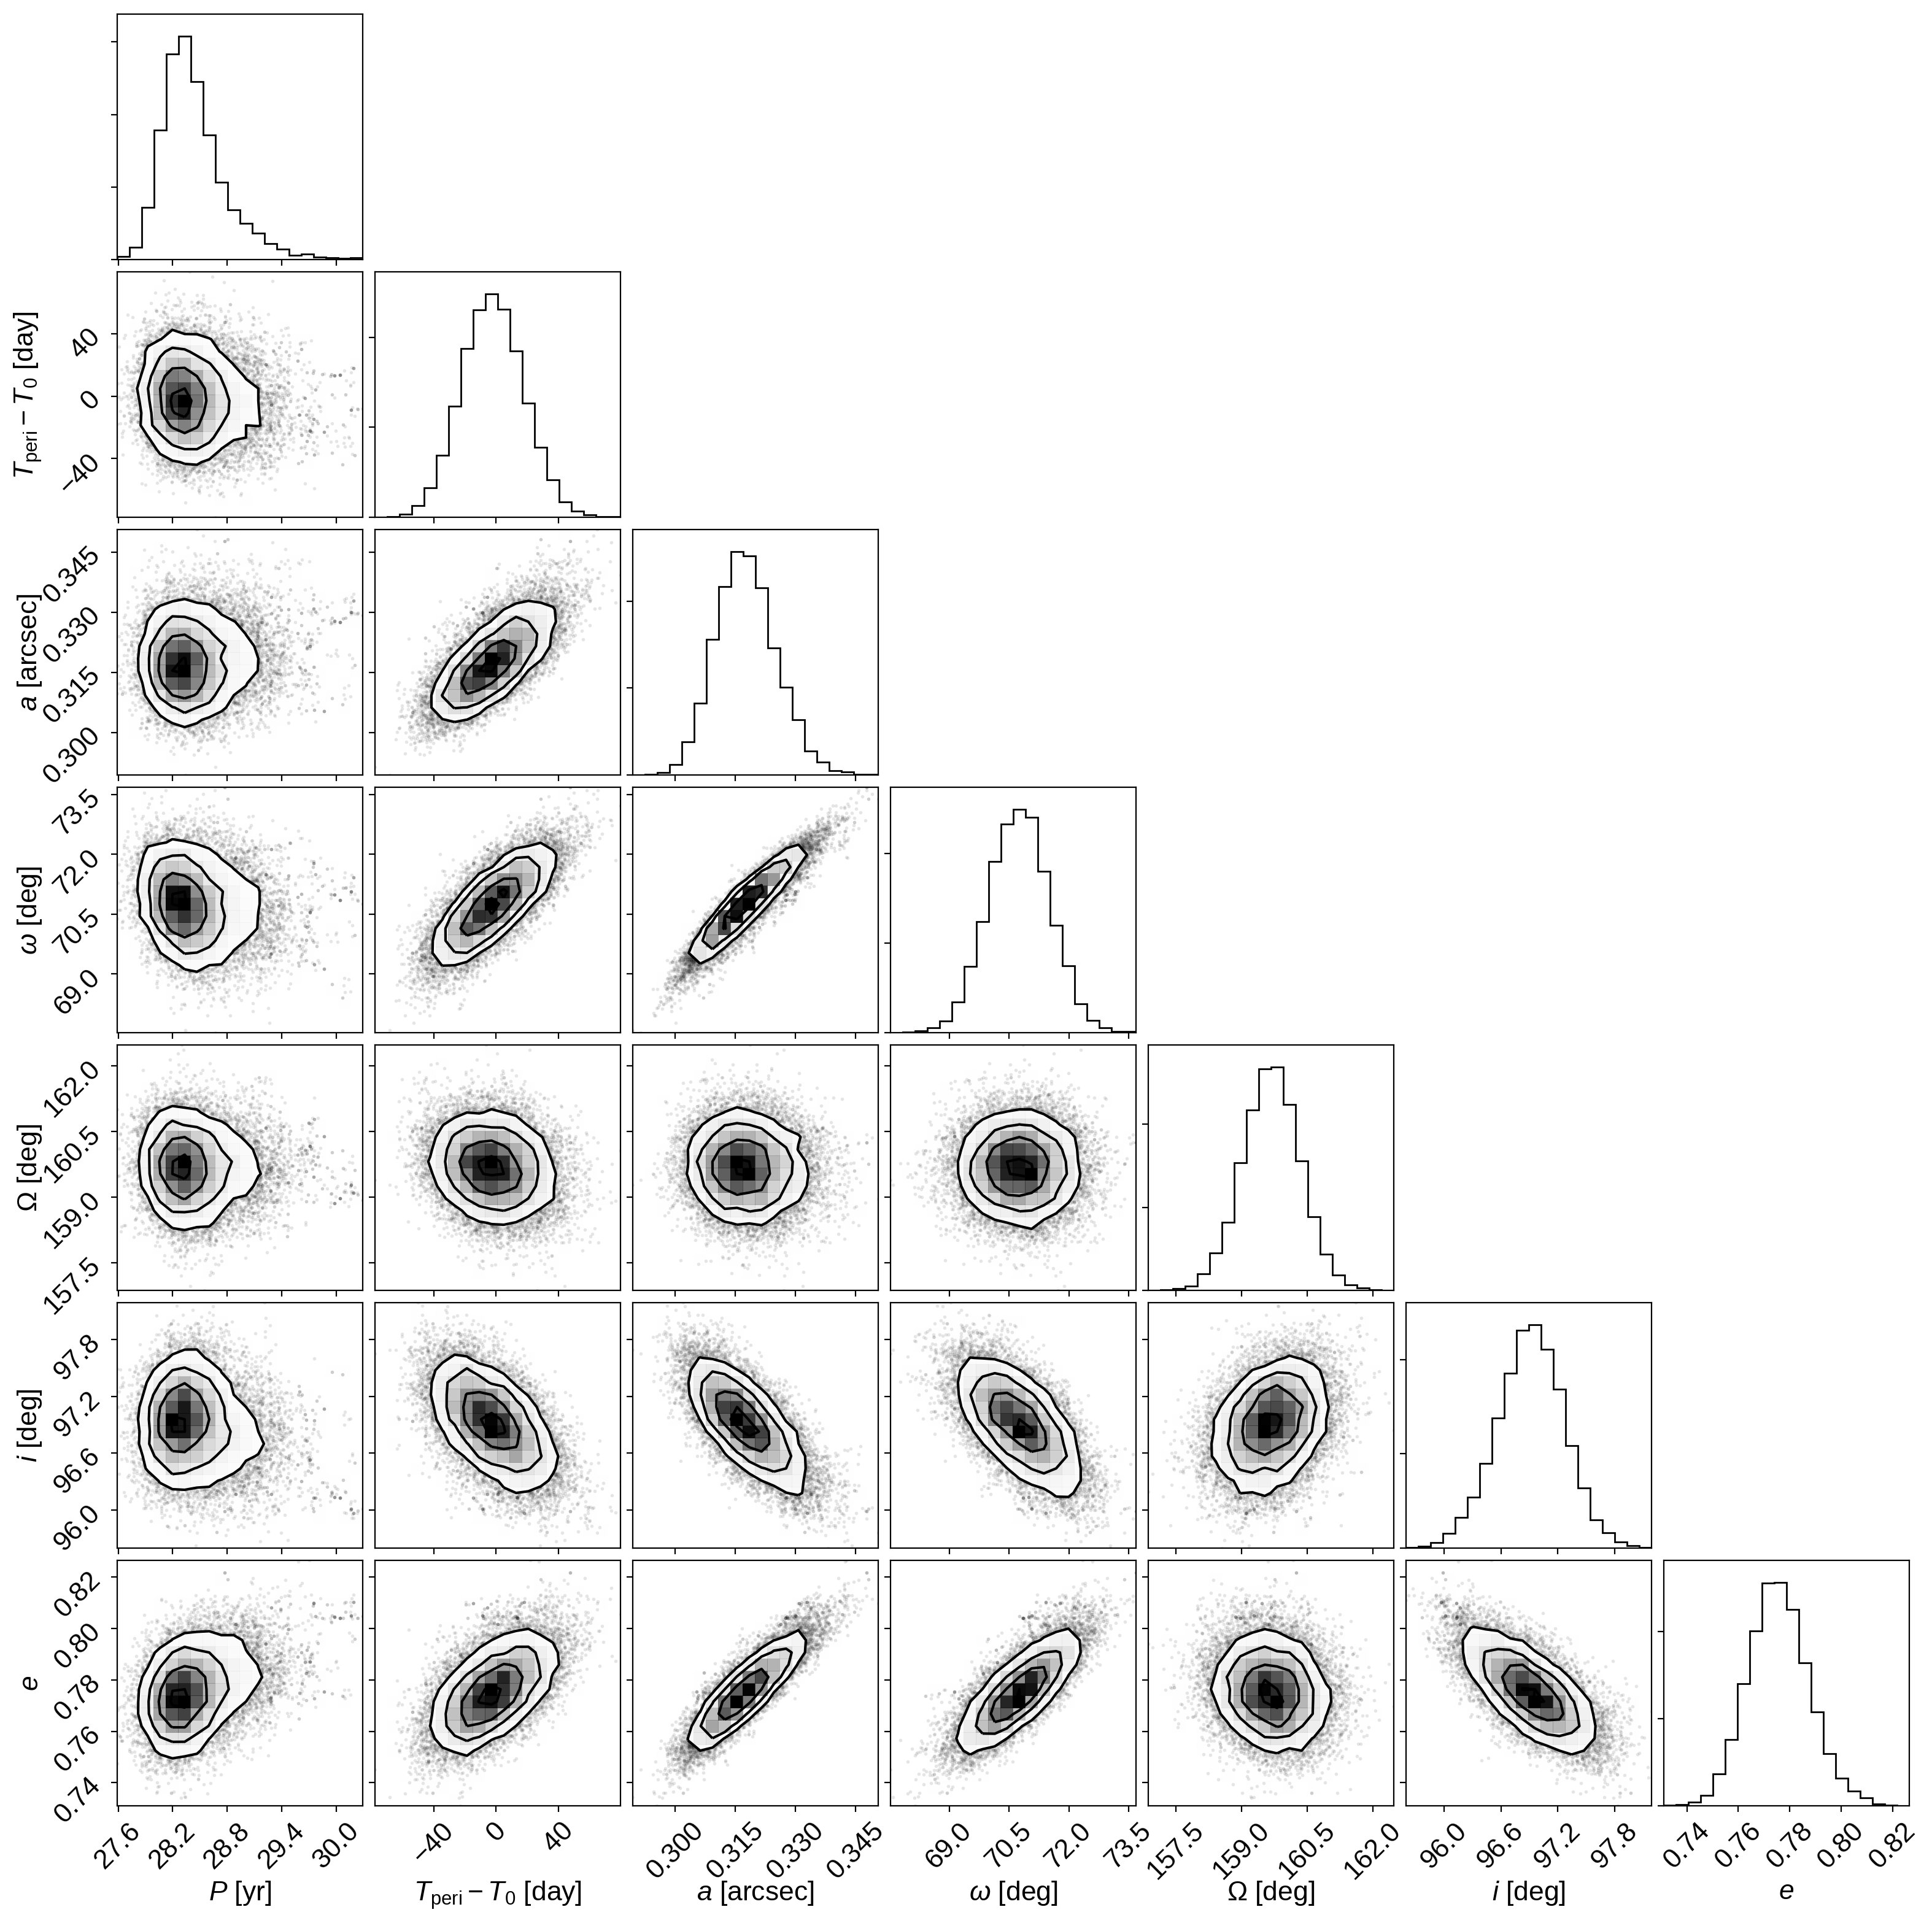

In [12]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["ecc"])
samples["$P$ [yr]"] = trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = trace["tperi"] - T0
samples["$a$ [arcsec]"] = trace["a_ang"]
samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
samples["$e$"] = samples["ecc"]
del samples["ecc"]
corner.corner(samples);

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

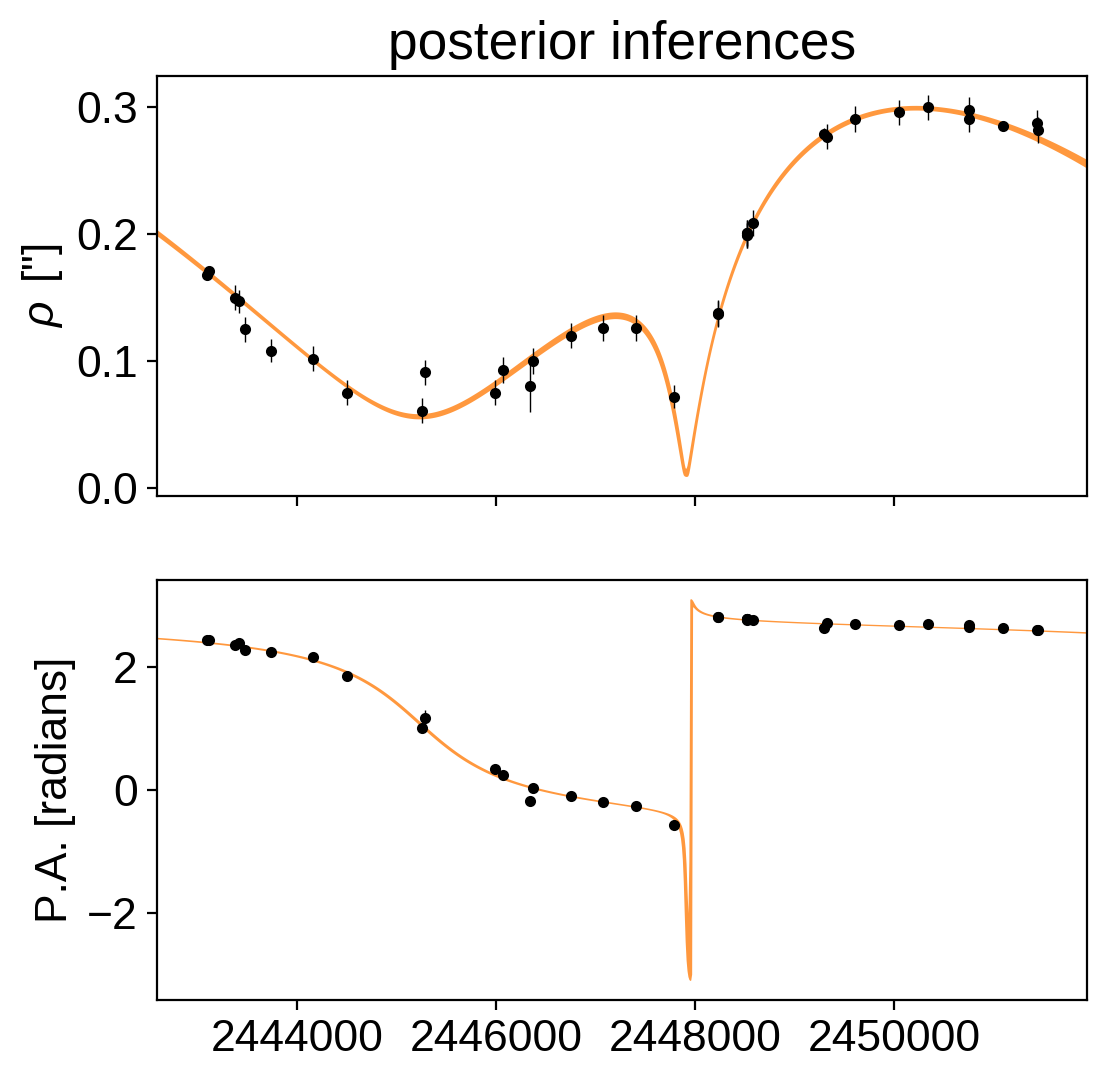

In [13]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"P.A. [radians]")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * np.median(trace["log_rho_s"], axis=0)))
tot_theta_err = np.sqrt(
    theta_err ** 2 + np.exp(2 * np.median(trace["log_theta_s"], axis=0))
)

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace["rho_save"], [16, 84], axis=0)
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace["theta_save"], [16, 84], axis=0)
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
ax[0].set_title("posterior inferences");

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry.
We also see two outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit.
It's likely the uncertainties were not estimated correctly for these, and the simlplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points.

## Including parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truely intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem. 

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.

We can use exactly the same model as above with only an added parallax constraint:

In [14]:
plx_model, plx_map_soln = get_model(parallax=[24.05, 0.45])

optimizing logp for variables: [log_theta_s, log_rho_s]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.076402e+02]

1it [00:00, 516.41it/s, logp=1.076402e+02]

2it [00:00, 670.82it/s, logp=1.076402e+02]

3it [00:00, 718.04it/s, logp=1.476711e+02]

4it [00:00, 742.85it/s, logp=1.084303e+02]

5it [00:00, 786.16it/s, logp=1.485840e+02]

6it [00:00, 799.17it/s, logp=1.497845e+02]

7it [00:00, 807.88it/s, logp=1.499280e+02]

8it [00:00, 563.80it/s, logp=1.499286e+02]

9it [00:00, 552.73it/s, logp=1.499286e+02]

10it [00:00, 568.98it/s, logp=1.499286e+02]

11it [00:01,  6.20it/s, logp=1.499286e+02] 


message: Optimization terminated successfully.
logp: 107.64015029566296 -> 149.92860106267193


optimizing logp for variables: [phase]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.499286e+02]

1it [00:00, 260.68it/s, logp=1.499286e+02]

2it [00:00, 345.14it/s, logp=1.499286e+02]

3it [00:00, 355.72it/s, logp=-1.185553e+04]

4it [00:00, 396.01it/s, logp=1.499517e+02] 

5it [00:00, 405.64it/s, logp=1.499982e+02]

6it [00:00, 426.81it/s, logp=1.501832e+02]

7it [00:00, 433.69it/s, logp=1.509035e+02]

8it [00:00, 449.36it/s, logp=1.535077e+02]

9it [00:00, 444.17it/s, logp=1.593811e+02]

10it [00:00, 459.72it/s, logp=1.662757e+02]

11it [00:00, 472.79it/s, logp=1.694242e+02]

12it [00:00, 484.67it/s, logp=1.703302e+02]

13it [00:00, 496.18it/s, logp=1.704061e+02]

14it [00:00, 508.55it/s, logp=1.704094e+02]

15it [00:00, 519.05it/s, logp=1.704128e+02]

16it [00:00, 524.51it/s, logp=1.704184e+02]

17it [00:00, 533.14it/s, logp=1.704249e+02]

18it [00:00, 533.03it/s, logp=1.704265e+02]

19it [00:00, 525.84it/s, logp=1.704268e+02]

20it [00:00, 516.85it/s, logp=1.704268e+02]

21it [00:00, 510.74it/s, logp=1.704268e+02]

22it [00:00, 509.30it/s, logp=1.704268e+02]

23it [00:01, 16.15it/s, logp=1.704268e+02] 


message: Optimization terminated successfully.
logp: 149.92860106267193 -> 170.4268151845905


optimizing logp for variables: [ecc, m, p]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.704268e+02]

1it [00:00, 231.59it/s, logp=1.704268e+02]

2it [00:00, 322.55it/s, logp=1.704268e+02]

3it [00:00, 338.95it/s, logp=-4.518236e+03]

4it [00:00, 357.18it/s, logp=1.710200e+02] 

5it [00:00, 371.20it/s, logp=1.695336e+02]

6it [00:00, 384.01it/s, logp=1.711520e+02]

7it [00:00, 387.15it/s, logp=1.714066e+02]

8it [00:00, 403.15it/s, logp=1.721879e+02]

9it [00:00, 400.78it/s, logp=1.742150e+02]

10it [00:00, 409.41it/s, logp=1.812157e+02]

11it [00:00, 409.03it/s, logp=1.949820e+02]

12it [00:00, 399.95it/s, logp=1.964691e+02]

13it [00:00, 405.85it/s, logp=1.992100e+02]

14it [00:00, 411.95it/s, logp=2.038785e+02]

15it [00:00, 413.55it/s, logp=2.102587e+02]

16it [00:00, 418.72it/s, logp=2.122110e+02]

17it [00:00, 423.04it/s, logp=2.126408e+02]

18it [00:00, 417.98it/s, logp=2.126846e+02]

19it [00:00, 413.34it/s, logp=2.126998e+02]

20it [00:00, 412.19it/s, logp=2.127263e+02]

21it [00:00, 415.12it/s, logp=2.127699e+02]

22it [00:00, 419.27it/s, logp=2.128244e+02]

23it [00:00, 424.02it/s, logp=2.128398e+02]

24it [00:00, 428.37it/s, logp=2.128456e+02]

25it [00:00, 431.31it/s, logp=2.128460e+02]

26it [00:00, 434.16it/s, logp=2.128463e+02]

27it [00:00, 438.22it/s, logp=2.128468e+02]

28it [00:00, 438.53it/s, logp=2.128475e+02]

29it [00:00, 439.70it/s, logp=2.128479e+02]

30it [00:00, 440.03it/s, logp=2.128480e+02]

31it [00:00, 440.77it/s, logp=2.128480e+02]

32it [00:00, 442.85it/s, logp=2.128480e+02]

33it [00:00, 442.63it/s, logp=2.128480e+02]

34it [00:00, 444.65it/s, logp=2.128480e+02]

35it [00:00, 44.74it/s, logp=2.128480e+02] 


message: Optimization terminated successfully.
logp: 170.42681518459054 -> 212.8480158855976


optimizing logp for variables: [phase, a_ang, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.128480e+02]

1it [00:00, 330.47it/s, logp=2.128480e+02]

2it [00:00, 457.42it/s, logp=2.128480e+02]

3it [00:00, 489.82it/s, logp=-4.375386e+03]

4it [00:00, 511.92it/s, logp=2.129960e+02] 

5it [00:00, 478.74it/s, logp=2.131453e+02]

6it [00:00, 472.48it/s, logp=2.132729e+02]

7it [00:00, 464.76it/s, logp=2.132857e+02]

8it [00:00, 456.11it/s, logp=2.132857e+02]

9it [00:00, 453.97it/s, logp=2.132860e+02]

10it [00:00, 445.83it/s, logp=2.132860e+02]

11it [00:00, 443.14it/s, logp=2.132860e+02]

12it [00:00, 16.25it/s, logp=2.132860e+02] 


message: Optimization terminated successfully.
logp: 212.8480158855976 -> 213.28597909410882


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.132860e+02]

1it [00:00, 247.99it/s, logp=2.132860e+02]

2it [00:00, 351.83it/s, logp=2.132860e+02]

3it [00:00, 353.39it/s, logp=-4.038433e+03]

4it [00:00, 373.72it/s, logp=2.152474e+02] 

5it [00:00, 386.43it/s, logp=1.676432e+02]

6it [00:00, 412.36it/s, logp=2.153207e+02]

7it [00:00, 414.61it/s, logp=2.154316e+02]

8it [00:00, 406.69it/s, logp=2.156115e+02]

9it [00:00, 416.93it/s, logp=2.158705e+02]

10it [00:00, 414.37it/s, logp=2.160160e+02]

11it [00:00, 416.16it/s, logp=2.158620e+02]

12it [00:00, 417.08it/s, logp=2.160652e+02]

13it [00:00, 415.39it/s, logp=2.160890e+02]

14it [00:00, 414.74it/s, logp=2.161353e+02]

15it [00:00, 416.37it/s, logp=2.162848e+02]

16it [00:00, 406.57it/s, logp=2.166196e+02]

17it [00:00, 402.94it/s, logp=2.171740e+02]

18it [00:00, 393.38it/s, logp=2.175761e+02]

19it [00:00, 382.61it/s, logp=2.174845e+02]

20it [00:00, 382.05it/s, logp=2.176565e+02]

21it [00:00, 381.74it/s, logp=2.177043e+02]

22it [00:00, 379.76it/s, logp=2.177335e+02]

23it [00:00, 378.11it/s, logp=2.177622e+02]

24it [00:00, 377.05it/s, logp=2.177547e+02]

25it [00:00, 378.05it/s, logp=2.177767e+02]

26it [00:00, 376.33it/s, logp=2.177873e+02]

27it [00:00, 373.47it/s, logp=2.177936e+02]

28it [00:00, 371.33it/s, logp=2.178014e+02]

29it [00:00, 370.76it/s, logp=2.178034e+02]

30it [00:00, 369.20it/s, logp=2.178054e+02]

31it [00:00, 366.60it/s, logp=2.178058e+02]

32it [00:00, 364.62it/s, logp=2.178059e+02]

33it [00:00, 362.92it/s, logp=2.178059e+02]

34it [00:00, 361.79it/s, logp=2.178059e+02]

35it [00:00, 362.28it/s, logp=2.178059e+02]

36it [00:00, 361.18it/s, logp=2.178059e+02]

37it [00:00, 366.43it/s, logp=2.178059e+02]

37it [00:00, 366.43it/s, logp=2.178059e+02]

38it [00:00, 366.43it/s, logp=2.178059e+02]

39it [00:00, 366.43it/s, logp=2.178059e+02]

40it [00:00, 366.43it/s, logp=2.178059e+02]

41it [00:00, 366.43it/s, logp=2.178059e+02]

42it [00:00, 366.43it/s, logp=2.178059e+02]

43it [00:00, 366.43it/s, logp=2.178059e+02]

44it [00:00, 366.43it/s, logp=2.178059e+02]

45it [00:00, 366.43it/s, logp=2.178059e+02]

46it [00:00, 366.43it/s, logp=2.178059e+02]

47it [00:00, 366.43it/s, logp=2.178059e+02]

48it [00:00, 366.43it/s, logp=2.178059e+02]

49it [00:00, 366.43it/s, logp=2.178059e+02]

50it [00:00, 366.43it/s, logp=2.178059e+02]

51it [00:00, 366.43it/s, logp=2.178059e+02]

52it [00:00, 366.43it/s, logp=2.178059e+02]

53it [00:00, 366.43it/s, logp=2.178059e+02]

54it [00:00, 366.43it/s, logp=2.178059e+02]

55it [00:00, 366.43it/s, logp=2.178059e+02]

56it [00:00, 366.43it/s, logp=2.178059e+02]

57it [00:00, 366.43it/s, logp=2.178059e+02]

58it [00:00, 366.43it/s, logp=2.178059e+02]

59it [00:00, 366.43it/s, logp=2.178059e+02]

60it [00:00, 366.43it/s, logp=2.178059e+02]

61it [00:00, 366.43it/s, logp=2.178059e+02]

62it [00:00, 366.43it/s, logp=2.178059e+02]

63it [00:00, 366.43it/s, logp=2.178059e+02]

64it [00:00, 366.43it/s, logp=2.178059e+02]

65it [00:00, 366.43it/s, logp=2.178059e+02]

66it [00:00, 366.43it/s, logp=2.178059e+02]

67it [00:00, 366.43it/s, logp=2.178059e+02]

68it [00:00, 366.43it/s, logp=2.178059e+02]

69it [00:00, 366.43it/s, logp=2.178059e+02]

70it [00:00, 351.28it/s, logp=2.178059e+02]

70it [00:00, 351.28it/s, logp=2.178059e+02]

71it [00:00, 351.28it/s, logp=2.178059e+02]

72it [00:00, 351.28it/s, logp=2.178059e+02]

73it [00:00, 351.28it/s, logp=2.178059e+02]

74it [00:00, 351.28it/s, logp=2.178059e+02]

75it [00:00, 351.28it/s, logp=2.178059e+02]

76it [00:00, 351.28it/s, logp=2.178059e+02]

77it [00:00, 351.28it/s, logp=2.178059e+02]

78it [00:00, 351.28it/s, logp=2.178059e+02]

79it [00:00, 351.28it/s, logp=2.178059e+02]

80it [00:00, 351.28it/s, logp=2.178059e+02]

81it [00:00, 351.28it/s, logp=2.178059e+02]

82it [00:00, 351.28it/s, logp=2.178059e+02]

83it [00:00, 351.28it/s, logp=2.178059e+02]

84it [00:00, 351.28it/s, logp=2.178059e+02]

85it [00:00, 351.28it/s, logp=2.178059e+02]

86it [00:00, 351.28it/s, logp=2.178059e+02]

87it [00:00, 351.28it/s, logp=2.178059e+02]

88it [00:00, 351.28it/s, logp=2.178059e+02]

89it [00:00, 351.28it/s, logp=2.178059e+02]

90it [00:00, 351.28it/s, logp=2.178059e+02]

91it [00:00, 351.28it/s, logp=2.178059e+02]

92it [00:00, 351.28it/s, logp=2.178059e+02]

93it [00:00, 351.28it/s, logp=2.178059e+02]

94it [00:00, 351.28it/s, logp=2.178059e+02]

95it [00:00, 351.28it/s, logp=2.178059e+02]

96it [00:00, 351.28it/s, logp=2.178059e+02]

97it [00:00, 351.28it/s, logp=2.178059e+02]

98it [00:00, 351.28it/s, logp=2.178059e+02]

99it [00:00, 351.28it/s, logp=2.178059e+02]

100it [00:00, 351.28it/s, logp=2.178059e+02]

101it [00:00, 351.28it/s, logp=2.178059e+02]

102it [00:00, 351.28it/s, logp=2.178059e+02]

103it [00:00, 351.28it/s, logp=2.178059e+02]

104it [00:00, 351.28it/s, logp=2.178059e+02]

105it [00:00, 349.33it/s, logp=2.178059e+02]

105it [00:00, 349.33it/s, logp=2.178059e+02]

106it [00:00, 349.33it/s, logp=2.178059e+02]

107it [00:00, 349.33it/s, logp=2.178059e+02]

108it [00:00, 349.33it/s, logp=2.178059e+02]

109it [00:00, 349.33it/s, logp=2.178059e+02]

110it [00:00, 349.33it/s, logp=2.178059e+02]

111it [00:00, 349.33it/s, logp=2.178059e+02]

112it [00:00, 349.33it/s, logp=2.178059e+02]

113it [00:00, 349.33it/s, logp=2.178059e+02]

114it [00:00, 349.33it/s, logp=2.178059e+02]

115it [00:01, 113.38it/s, logp=2.178059e+02]


message: Desired error not necessarily achieved due to precision loss.
logp: 213.28597909410882 -> 217.8058683350306


In [15]:
np.random.seed(5432)
with plx_model:
    plx_trace = pm.sample(
        tune=5000,
        draws=4000,
        start=plx_map_soln,
        step=xo.get_dense_nuts_step(target_accept=0.9, start=plx_map_soln),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 4 chains:   0%|          | 0/36000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 14/36000 [00:00<05:22, 111.44draws/s]

Sampling 4 chains:   0%|          | 18/36000 [00:00<08:25, 71.12draws/s] 

Sampling 4 chains:   0%|          | 22/36000 [00:00<11:22, 52.74draws/s]

Sampling 4 chains:   0%|          | 26/36000 [00:00<13:08, 45.62draws/s]

Sampling 4 chains:   0%|          | 31/36000 [00:00<13:32, 44.26draws/s]

Sampling 4 chains:   0%|          | 35/36000 [00:00<14:36, 41.05draws/s]

Sampling 4 chains:   0%|          | 39/36000 [00:00<15:56, 37.59draws/s]

Sampling 4 chains:   0%|          | 43/36000 [00:00<17:13, 34.79draws/s]

Sampling 4 chains:   0%|          | 47/36000 [00:01<18:40, 32.09draws/s]

Sampling 4 chains:   0%|          | 51/36000 [00:01<17:55, 33.42draws/s]

Sampling 4 chains:   0%|          | 55/36000 [00:01<18:38, 32.13draws/s]

Sampling 4 chains:   0%|          | 59/36000 [00:01<18:51, 31.76draws/s]

Sampling 4 chains:   0%|          | 63/36000 [00:01<18:57, 31.58draws/s]

Sampling 4 chains:   0%|          | 67/36000 [00:01<18:30, 32.35draws/s]

Sampling 4 chains:   0%|          | 72/36000 [00:01<16:54, 35.43draws/s]

Sampling 4 chains:   0%|          | 76/36000 [00:01<17:36, 34.02draws/s]

Sampling 4 chains:   0%|          | 80/36000 [00:02<18:41, 32.03draws/s]

Sampling 4 chains:   0%|          | 84/36000 [00:02<19:10, 31.21draws/s]

Sampling 4 chains:   0%|          | 88/36000 [00:02<19:01, 31.46draws/s]

Sampling 4 chains:   0%|          | 94/36000 [00:02<16:31, 36.23draws/s]

Sampling 4 chains:   0%|          | 100/36000 [00:02<14:48, 40.40draws/s]

Sampling 4 chains:   0%|          | 106/36000 [00:02<14:47, 40.43draws/s]

Sampling 4 chains:   0%|          | 112/36000 [00:02<13:44, 43.54draws/s]

Sampling 4 chains:   0%|          | 117/36000 [00:02<13:27, 44.43draws/s]

Sampling 4 chains:   0%|          | 122/36000 [00:03<13:25, 44.54draws/s]

Sampling 4 chains:   0%|          | 128/36000 [00:03<12:40, 47.18draws/s]

Sampling 4 chains:   0%|          | 133/36000 [00:03<12:55, 46.23draws/s]

Sampling 4 chains:   0%|          | 138/36000 [00:03<14:13, 42.01draws/s]

Sampling 4 chains:   0%|          | 143/36000 [00:03<15:09, 39.42draws/s]

Sampling 4 chains:   0%|          | 148/36000 [00:03<15:42, 38.05draws/s]

Sampling 4 chains:   0%|          | 153/36000 [00:03<15:23, 38.83draws/s]

Sampling 4 chains:   0%|          | 158/36000 [00:03<14:54, 40.06draws/s]

Sampling 4 chains:   0%|          | 164/36000 [00:04<14:33, 41.05draws/s]

Sampling 4 chains:   0%|          | 169/36000 [00:04<13:48, 43.25draws/s]

Sampling 4 chains:   0%|          | 174/36000 [00:04<13:42, 43.54draws/s]

Sampling 4 chains:   0%|          | 179/36000 [00:04<13:57, 42.75draws/s]

Sampling 4 chains:   1%|          | 185/36000 [00:04<12:46, 46.75draws/s]

Sampling 4 chains:   1%|          | 190/36000 [00:04<13:44, 43.46draws/s]

Sampling 4 chains:   1%|          | 196/36000 [00:04<13:12, 45.16draws/s]

Sampling 4 chains:   1%|          | 202/36000 [00:04<12:17, 48.57draws/s]

Sampling 4 chains:   1%|          | 208/36000 [00:04<11:49, 50.48draws/s]

Sampling 4 chains:   1%|          | 215/36000 [00:05<11:20, 52.61draws/s]

Sampling 4 chains:   1%|          | 221/36000 [00:05<11:50, 50.38draws/s]

Sampling 4 chains:   1%|          | 227/36000 [00:05<12:30, 47.67draws/s]

Sampling 4 chains:   1%|          | 234/36000 [00:05<11:30, 51.82draws/s]

Sampling 4 chains:   1%|          | 240/36000 [00:05<11:11, 53.28draws/s]

Sampling 4 chains:   1%|          | 246/36000 [00:05<11:46, 50.58draws/s]

Sampling 4 chains:   1%|          | 252/36000 [00:05<13:34, 43.90draws/s]

Sampling 4 chains:   1%|          | 257/36000 [00:06<13:17, 44.80draws/s]

Sampling 4 chains:   1%|          | 262/36000 [00:06<14:11, 41.98draws/s]

Sampling 4 chains:   1%|          | 267/36000 [00:06<14:37, 40.74draws/s]

Sampling 4 chains:   1%|          | 274/36000 [00:06<13:52, 42.91draws/s]

Sampling 4 chains:   1%|          | 279/36000 [00:06<13:39, 43.61draws/s]

Sampling 4 chains:   1%|          | 285/36000 [00:06<12:50, 46.37draws/s]

Sampling 4 chains:   1%|          | 290/36000 [00:06<12:49, 46.40draws/s]

Sampling 4 chains:   1%|          | 295/36000 [00:06<14:08, 42.07draws/s]

Sampling 4 chains:   1%|          | 302/36000 [00:07<12:50, 46.33draws/s]

Sampling 4 chains:   1%|          | 308/36000 [00:07<12:45, 46.64draws/s]

Sampling 4 chains:   1%|          | 314/36000 [00:07<12:32, 47.45draws/s]

Sampling 4 chains:   1%|          | 319/36000 [00:07<12:23, 47.96draws/s]

Sampling 4 chains:   1%|          | 327/36000 [00:07<11:14, 52.90draws/s]

Sampling 4 chains:   1%|          | 333/36000 [00:07<12:48, 46.39draws/s]

Sampling 4 chains:   1%|          | 338/36000 [00:07<12:45, 46.62draws/s]

Sampling 4 chains:   1%|          | 343/36000 [00:07<14:59, 39.63draws/s]

Sampling 4 chains:   1%|          | 348/36000 [00:08<15:05, 39.36draws/s]

Sampling 4 chains:   1%|          | 353/36000 [00:08<15:07, 39.29draws/s]

Sampling 4 chains:   1%|          | 358/36000 [00:08<14:36, 40.68draws/s]

Sampling 4 chains:   1%|          | 363/36000 [00:08<14:06, 42.10draws/s]

Sampling 4 chains:   1%|          | 368/36000 [00:08<15:08, 39.23draws/s]

Sampling 4 chains:   1%|          | 373/36000 [00:08<15:15, 38.92draws/s]

Sampling 4 chains:   1%|          | 377/36000 [00:08<15:30, 38.27draws/s]

Sampling 4 chains:   1%|          | 381/36000 [00:08<15:44, 37.71draws/s]

Sampling 4 chains:   1%|          | 386/36000 [00:09<14:55, 39.79draws/s]

Sampling 4 chains:   1%|          | 393/36000 [00:09<13:30, 43.92draws/s]

Sampling 4 chains:   1%|          | 399/36000 [00:09<12:25, 47.73draws/s]

Sampling 4 chains:   1%|          | 411/36000 [00:09<10:18, 57.51draws/s]

Sampling 4 chains:   1%|          | 440/36000 [00:09<07:49, 75.70draws/s]

Sampling 4 chains:   1%|▏         | 466/36000 [00:09<06:10, 95.98draws/s]

Sampling 4 chains:   1%|▏         | 497/36000 [00:09<04:54, 120.65draws/s]

Sampling 4 chains:   1%|▏         | 532/36000 [00:09<03:57, 149.09draws/s]

Sampling 4 chains:   2%|▏         | 564/36000 [00:09<03:19, 177.42draws/s]

Sampling 4 chains:   2%|▏         | 591/36000 [00:09<03:02, 194.11draws/s]

Sampling 4 chains:   2%|▏         | 618/36000 [00:10<02:55, 201.61draws/s]

Sampling 4 chains:   2%|▏         | 644/36000 [00:10<02:46, 212.47draws/s]

Sampling 4 chains:   2%|▏         | 669/36000 [00:10<02:46, 211.73draws/s]

Sampling 4 chains:   2%|▏         | 693/36000 [00:10<02:48, 209.27draws/s]

Sampling 4 chains:   2%|▏         | 718/36000 [00:10<02:40, 220.01draws/s]

Sampling 4 chains:   2%|▏         | 742/36000 [00:10<02:43, 215.63draws/s]

Sampling 4 chains:   2%|▏         | 768/36000 [00:10<02:37, 223.87draws/s]

Sampling 4 chains:   2%|▏         | 792/36000 [00:10<02:37, 223.52draws/s]

Sampling 4 chains:   2%|▏         | 821/36000 [00:10<02:28, 236.97draws/s]

Sampling 4 chains:   2%|▏         | 853/36000 [00:11<02:17, 256.18draws/s]

Sampling 4 chains:   2%|▏         | 892/36000 [00:11<02:05, 279.71draws/s]

Sampling 4 chains:   3%|▎         | 933/36000 [00:11<01:53, 307.78draws/s]

Sampling 4 chains:   3%|▎         | 969/36000 [00:11<01:49, 319.48draws/s]

Sampling 4 chains:   3%|▎         | 1003/36000 [00:11<01:50, 317.70draws/s]

Sampling 4 chains:   3%|▎         | 1042/36000 [00:11<01:44, 334.29draws/s]

Sampling 4 chains:   3%|▎         | 1077/36000 [00:11<01:44, 333.29draws/s]

Sampling 4 chains:   3%|▎         | 1111/36000 [00:11<01:49, 317.29draws/s]

Sampling 4 chains:   3%|▎         | 1149/36000 [00:11<01:45, 330.25draws/s]

Sampling 4 chains:   3%|▎         | 1183/36000 [00:12<01:53, 307.86draws/s]

Sampling 4 chains:   3%|▎         | 1215/36000 [00:12<01:52, 310.25draws/s]

Sampling 4 chains:   3%|▎         | 1253/36000 [00:12<01:45, 328.10draws/s]

Sampling 4 chains:   4%|▎         | 1291/36000 [00:12<01:41, 340.62draws/s]

Sampling 4 chains:   4%|▎         | 1326/36000 [00:12<01:41, 341.84draws/s]

Sampling 4 chains:   4%|▍         | 1366/36000 [00:12<01:37, 356.98draws/s]

Sampling 4 chains:   4%|▍         | 1404/36000 [00:12<01:35, 361.83draws/s]

Sampling 4 chains:   4%|▍         | 1443/36000 [00:12<01:33, 367.73draws/s]

Sampling 4 chains:   4%|▍         | 1481/36000 [00:12<01:33, 367.49draws/s]

Sampling 4 chains:   4%|▍         | 1519/36000 [00:12<01:33, 370.73draws/s]

Sampling 4 chains:   4%|▍         | 1557/36000 [00:13<01:39, 346.65draws/s]

Sampling 4 chains:   4%|▍         | 1593/36000 [00:13<01:40, 343.36draws/s]

Sampling 4 chains:   5%|▍         | 1629/36000 [00:13<01:38, 347.59draws/s]

Sampling 4 chains:   5%|▍         | 1664/36000 [00:13<01:40, 342.20draws/s]

Sampling 4 chains:   5%|▍         | 1701/36000 [00:13<01:38, 349.58draws/s]

Sampling 4 chains:   5%|▍         | 1742/36000 [00:13<01:34, 364.30draws/s]

Sampling 4 chains:   5%|▍         | 1784/36000 [00:13<01:30, 376.69draws/s]

Sampling 4 chains:   5%|▌         | 1822/36000 [00:13<01:35, 358.00draws/s]

Sampling 4 chains:   5%|▌         | 1859/36000 [00:13<01:37, 351.26draws/s]

Sampling 4 chains:   5%|▌         | 1895/36000 [00:14<01:42, 333.94draws/s]

Sampling 4 chains:   5%|▌         | 1929/36000 [00:14<01:47, 317.50draws/s]

Sampling 4 chains:   5%|▌         | 1962/36000 [00:14<01:49, 310.43draws/s]

Sampling 4 chains:   6%|▌         | 2003/36000 [00:14<01:42, 331.93draws/s]

Sampling 4 chains:   6%|▌         | 2044/36000 [00:14<01:36, 351.57draws/s]

Sampling 4 chains:   6%|▌         | 2083/36000 [00:14<01:35, 355.89draws/s]

Sampling 4 chains:   6%|▌         | 2120/36000 [00:14<01:41, 334.59draws/s]

Sampling 4 chains:   6%|▌         | 2155/36000 [00:14<01:40, 336.26draws/s]

Sampling 4 chains:   6%|▌         | 2191/36000 [00:14<01:38, 342.40draws/s]

Sampling 4 chains:   6%|▌         | 2226/36000 [00:15<01:39, 338.51draws/s]

Sampling 4 chains:   6%|▋         | 2269/36000 [00:15<01:33, 361.11draws/s]

Sampling 4 chains:   6%|▋         | 2306/36000 [00:15<01:36, 350.37draws/s]

Sampling 4 chains:   7%|▋         | 2349/36000 [00:15<01:30, 370.81draws/s]

Sampling 4 chains:   7%|▋         | 2394/36000 [00:15<01:26, 388.44draws/s]

Sampling 4 chains:   7%|▋         | 2434/36000 [00:15<01:29, 375.32draws/s]

Sampling 4 chains:   7%|▋         | 2479/36000 [00:15<01:26, 389.38draws/s]

Sampling 4 chains:   7%|▋         | 2521/36000 [00:15<01:25, 390.73draws/s]

Sampling 4 chains:   7%|▋         | 2561/36000 [00:15<01:25, 391.51draws/s]

Sampling 4 chains:   7%|▋         | 2601/36000 [00:16<01:32, 359.31draws/s]

Sampling 4 chains:   7%|▋         | 2638/36000 [00:16<01:36, 347.36draws/s]

Sampling 4 chains:   7%|▋         | 2675/36000 [00:16<01:35, 349.86draws/s]

Sampling 4 chains:   8%|▊         | 2711/36000 [00:16<01:34, 351.17draws/s]

Sampling 4 chains:   8%|▊         | 2747/36000 [00:16<01:34, 350.78draws/s]

Sampling 4 chains:   8%|▊         | 2783/36000 [00:16<01:42, 324.88draws/s]

Sampling 4 chains:   8%|▊         | 2817/36000 [00:16<01:40, 329.22draws/s]

Sampling 4 chains:   8%|▊         | 2851/36000 [00:16<01:45, 314.86draws/s]

Sampling 4 chains:   8%|▊         | 2883/36000 [00:16<01:45, 313.54draws/s]

Sampling 4 chains:   8%|▊         | 2915/36000 [00:16<01:47, 307.43draws/s]

Sampling 4 chains:   8%|▊         | 2950/36000 [00:17<01:44, 316.40draws/s]

Sampling 4 chains:   8%|▊         | 2982/36000 [00:17<01:44, 314.65draws/s]

Sampling 4 chains:   8%|▊         | 3021/36000 [00:17<01:38, 333.33draws/s]

Sampling 4 chains:   8%|▊         | 3055/36000 [00:17<01:41, 323.68draws/s]

Sampling 4 chains:   9%|▊         | 3088/36000 [00:17<01:44, 315.40draws/s]

Sampling 4 chains:   9%|▊         | 3131/36000 [00:17<01:36, 340.44draws/s]

Sampling 4 chains:   9%|▉         | 3169/36000 [00:17<01:33, 351.04draws/s]

Sampling 4 chains:   9%|▉         | 3206/36000 [00:17<01:32, 353.99draws/s]

Sampling 4 chains:   9%|▉         | 3242/36000 [00:17<01:33, 349.67draws/s]

Sampling 4 chains:   9%|▉         | 3278/36000 [00:18<01:34, 346.57draws/s]

Sampling 4 chains:   9%|▉         | 3313/36000 [00:18<01:36, 337.94draws/s]

Sampling 4 chains:   9%|▉         | 3348/36000 [00:18<01:40, 323.31draws/s]

Sampling 4 chains:   9%|▉         | 3383/36000 [00:18<01:39, 329.03draws/s]

Sampling 4 chains:   9%|▉         | 3417/36000 [00:18<01:40, 323.40draws/s]

Sampling 4 chains:  10%|▉         | 3463/36000 [00:18<01:31, 354.94draws/s]

Sampling 4 chains:  10%|▉         | 3508/36000 [00:18<01:25, 378.19draws/s]

Sampling 4 chains:  10%|▉         | 3550/36000 [00:18<01:23, 386.46draws/s]

Sampling 4 chains:  10%|▉         | 3593/36000 [00:18<01:21, 395.66draws/s]

Sampling 4 chains:  10%|█         | 3634/36000 [00:18<01:21, 399.10draws/s]

Sampling 4 chains:  10%|█         | 3677/36000 [00:19<01:20, 403.81draws/s]

Sampling 4 chains:  10%|█         | 3718/36000 [00:19<01:23, 385.45draws/s]

Sampling 4 chains:  10%|█         | 3760/36000 [00:19<01:21, 394.13draws/s]

Sampling 4 chains:  11%|█         | 3800/36000 [00:19<01:21, 394.83draws/s]

Sampling 4 chains:  11%|█         | 3841/36000 [00:19<01:20, 399.25draws/s]

Sampling 4 chains:  11%|█         | 3882/36000 [00:19<01:21, 392.53draws/s]

Sampling 4 chains:  11%|█         | 3922/36000 [00:19<01:22, 388.82draws/s]

Sampling 4 chains:  11%|█         | 3965/36000 [00:19<01:20, 396.61draws/s]

Sampling 4 chains:  11%|█         | 4005/36000 [00:19<01:22, 389.31draws/s]

Sampling 4 chains:  11%|█         | 4045/36000 [00:20<01:23, 384.01draws/s]

Sampling 4 chains:  11%|█▏        | 4088/36000 [00:20<01:20, 396.25draws/s]

Sampling 4 chains:  11%|█▏        | 4128/36000 [00:20<01:22, 386.04draws/s]

Sampling 4 chains:  12%|█▏        | 4168/36000 [00:20<01:21, 389.99draws/s]

Sampling 4 chains:  12%|█▏        | 4208/36000 [00:20<01:23, 379.10draws/s]

Sampling 4 chains:  12%|█▏        | 4247/36000 [00:20<01:23, 379.15draws/s]

Sampling 4 chains:  12%|█▏        | 4287/36000 [00:20<01:22, 384.16draws/s]

Sampling 4 chains:  12%|█▏        | 4331/36000 [00:20<01:19, 398.58draws/s]

Sampling 4 chains:  12%|█▏        | 4372/36000 [00:20<01:18, 400.73draws/s]

Sampling 4 chains:  12%|█▏        | 4413/36000 [00:20<01:18, 401.30draws/s]

Sampling 4 chains:  12%|█▏        | 4454/36000 [00:21<01:21, 387.52draws/s]

Sampling 4 chains:  12%|█▏        | 4493/36000 [00:21<01:24, 372.19draws/s]

Sampling 4 chains:  13%|█▎        | 4531/36000 [00:21<01:24, 371.28draws/s]

Sampling 4 chains:  13%|█▎        | 4572/36000 [00:21<01:22, 379.91draws/s]

Sampling 4 chains:  13%|█▎        | 4617/36000 [00:21<01:19, 396.50draws/s]

Sampling 4 chains:  13%|█▎        | 4659/36000 [00:21<01:17, 402.99draws/s]

Sampling 4 chains:  13%|█▎        | 4707/36000 [00:21<01:14, 421.57draws/s]

Sampling 4 chains:  13%|█▎        | 4754/36000 [00:21<01:11, 434.26draws/s]

Sampling 4 chains:  13%|█▎        | 4798/36000 [00:21<01:12, 430.21draws/s]

Sampling 4 chains:  13%|█▎        | 4842/36000 [00:22<01:12, 428.43draws/s]

Sampling 4 chains:  14%|█▎        | 4886/36000 [00:22<01:18, 398.04draws/s]

Sampling 4 chains:  14%|█▎        | 4927/36000 [00:22<01:20, 385.07draws/s]

Sampling 4 chains:  14%|█▍        | 4966/36000 [00:22<01:24, 368.95draws/s]

Sampling 4 chains:  14%|█▍        | 5005/36000 [00:22<01:23, 372.87draws/s]

Sampling 4 chains:  14%|█▍        | 5047/36000 [00:22<01:20, 383.49draws/s]

Sampling 4 chains:  14%|█▍        | 5091/36000 [00:22<01:18, 393.69draws/s]

Sampling 4 chains:  14%|█▍        | 5131/36000 [00:22<01:19, 389.49draws/s]

Sampling 4 chains:  14%|█▍        | 5172/36000 [00:22<01:18, 393.57draws/s]

Sampling 4 chains:  14%|█▍        | 5212/36000 [00:22<01:19, 386.46draws/s]

Sampling 4 chains:  15%|█▍        | 5251/36000 [00:23<01:20, 380.50draws/s]

Sampling 4 chains:  15%|█▍        | 5290/36000 [00:23<01:20, 380.34draws/s]

Sampling 4 chains:  15%|█▍        | 5332/36000 [00:23<01:19, 387.58draws/s]

Sampling 4 chains:  15%|█▍        | 5374/36000 [00:23<01:17, 396.25draws/s]

Sampling 4 chains:  15%|█▌        | 5414/36000 [00:23<01:20, 377.94draws/s]

Sampling 4 chains:  15%|█▌        | 5466/36000 [00:23<01:14, 409.18draws/s]

Sampling 4 chains:  15%|█▌        | 5516/36000 [00:23<01:11, 427.37draws/s]

Sampling 4 chains:  15%|█▌        | 5560/36000 [00:23<01:10, 430.44draws/s]

Sampling 4 chains:  16%|█▌        | 5605/36000 [00:23<01:10, 432.45draws/s]

Sampling 4 chains:  16%|█▌        | 5649/36000 [00:24<01:12, 417.97draws/s]

Sampling 4 chains:  16%|█▌        | 5692/36000 [00:24<01:14, 407.32draws/s]

Sampling 4 chains:  16%|█▌        | 5734/36000 [00:24<01:17, 392.82draws/s]

Sampling 4 chains:  16%|█▌        | 5774/36000 [00:24<01:17, 391.58draws/s]

Sampling 4 chains:  16%|█▌        | 5817/36000 [00:24<01:15, 400.66draws/s]

Sampling 4 chains:  16%|█▋        | 5858/36000 [00:24<01:18, 385.52draws/s]

Sampling 4 chains:  16%|█▋        | 5897/36000 [00:24<01:23, 359.49draws/s]

Sampling 4 chains:  16%|█▋        | 5934/36000 [00:24<01:25, 352.51draws/s]

Sampling 4 chains:  17%|█▋        | 5970/36000 [00:24<01:26, 345.83draws/s]

Sampling 4 chains:  17%|█▋        | 6012/36000 [00:25<01:23, 361.06draws/s]

Sampling 4 chains:  17%|█▋        | 6056/36000 [00:25<01:18, 380.52draws/s]

Sampling 4 chains:  17%|█▋        | 6095/36000 [00:25<01:19, 374.87draws/s]

Sampling 4 chains:  17%|█▋        | 6133/36000 [00:25<01:20, 372.83draws/s]

Sampling 4 chains:  17%|█▋        | 6171/36000 [00:25<01:24, 353.96draws/s]

Sampling 4 chains:  17%|█▋        | 6207/36000 [00:25<01:24, 353.43draws/s]

Sampling 4 chains:  17%|█▋        | 6244/36000 [00:25<01:24, 354.15draws/s]

Sampling 4 chains:  17%|█▋        | 6285/36000 [00:25<01:20, 369.10draws/s]

Sampling 4 chains:  18%|█▊        | 6323/36000 [00:25<01:22, 357.67draws/s]

Sampling 4 chains:  18%|█▊        | 6361/36000 [00:26<01:21, 363.27draws/s]

Sampling 4 chains:  18%|█▊        | 6398/36000 [00:26<01:21, 363.14draws/s]

Sampling 4 chains:  18%|█▊        | 6435/36000 [00:26<01:21, 363.04draws/s]

Sampling 4 chains:  18%|█▊        | 6472/36000 [00:26<01:21, 363.62draws/s]

Sampling 4 chains:  18%|█▊        | 6509/36000 [00:26<01:20, 364.60draws/s]

Sampling 4 chains:  18%|█▊        | 6547/36000 [00:26<01:19, 368.23draws/s]

Sampling 4 chains:  18%|█▊        | 6584/36000 [00:26<01:27, 334.62draws/s]

Sampling 4 chains:  18%|█▊        | 6623/36000 [00:26<01:24, 346.07draws/s]

Sampling 4 chains:  19%|█▊        | 6664/36000 [00:26<01:21, 361.39draws/s]

Sampling 4 chains:  19%|█▊        | 6704/36000 [00:26<01:19, 368.94draws/s]

Sampling 4 chains:  19%|█▊        | 6742/36000 [00:27<01:18, 370.61draws/s]

Sampling 4 chains:  19%|█▉        | 6780/36000 [00:27<01:19, 366.22draws/s]

Sampling 4 chains:  19%|█▉        | 6817/36000 [00:27<01:20, 364.36draws/s]

Sampling 4 chains:  19%|█▉        | 6855/36000 [00:27<01:19, 365.30draws/s]

Sampling 4 chains:  19%|█▉        | 6892/36000 [00:27<01:21, 356.89draws/s]

Sampling 4 chains:  19%|█▉        | 6928/36000 [00:27<01:26, 334.66draws/s]

Sampling 4 chains:  19%|█▉        | 6962/36000 [00:27<01:27, 330.85draws/s]

Sampling 4 chains:  19%|█▉        | 6996/36000 [00:27<01:29, 324.76draws/s]

Sampling 4 chains:  20%|█▉        | 7032/36000 [00:27<01:26, 334.49draws/s]

Sampling 4 chains:  20%|█▉        | 7066/36000 [00:28<01:26, 335.33draws/s]

Sampling 4 chains:  20%|█▉        | 7100/36000 [00:28<01:27, 329.94draws/s]

Sampling 4 chains:  20%|█▉        | 7137/36000 [00:28<01:24, 340.81draws/s]

Sampling 4 chains:  20%|█▉        | 7173/36000 [00:28<01:23, 345.64draws/s]

Sampling 4 chains:  20%|██        | 7216/36000 [00:28<01:18, 367.19draws/s]

Sampling 4 chains:  20%|██        | 7254/36000 [00:28<01:17, 368.70draws/s]

Sampling 4 chains:  20%|██        | 7297/36000 [00:28<01:14, 384.97draws/s]

Sampling 4 chains:  20%|██        | 7336/36000 [00:28<01:14, 382.73draws/s]

Sampling 4 chains:  20%|██        | 7376/36000 [00:28<01:14, 384.92draws/s]

Sampling 4 chains:  21%|██        | 7415/36000 [00:28<01:15, 376.41draws/s]

Sampling 4 chains:  21%|██        | 7453/36000 [00:29<01:17, 368.60draws/s]

Sampling 4 chains:  21%|██        | 7494/36000 [00:29<01:15, 379.19draws/s]

Sampling 4 chains:  21%|██        | 7536/36000 [00:29<01:13, 389.81draws/s]

Sampling 4 chains:  21%|██        | 7576/36000 [00:29<01:13, 386.95draws/s]

Sampling 4 chains:  21%|██        | 7615/36000 [00:29<01:16, 372.02draws/s]

Sampling 4 chains:  21%|██▏       | 7653/36000 [00:29<01:18, 361.61draws/s]

Sampling 4 chains:  21%|██▏       | 7690/36000 [00:29<01:17, 364.06draws/s]

Sampling 4 chains:  21%|██▏       | 7727/36000 [00:29<01:20, 350.92draws/s]

Sampling 4 chains:  22%|██▏       | 7765/36000 [00:29<01:20, 352.62draws/s]

Sampling 4 chains:  22%|██▏       | 7801/36000 [00:30<01:20, 348.69draws/s]

Sampling 4 chains:  22%|██▏       | 7836/36000 [00:30<01:23, 338.60draws/s]

Sampling 4 chains:  22%|██▏       | 7872/36000 [00:30<01:22, 340.77draws/s]

Sampling 4 chains:  22%|██▏       | 7910/36000 [00:30<01:19, 351.56draws/s]

Sampling 4 chains:  22%|██▏       | 7958/36000 [00:30<01:13, 379.86draws/s]

Sampling 4 chains:  22%|██▏       | 8003/36000 [00:30<01:10, 395.12draws/s]

Sampling 4 chains:  22%|██▏       | 8044/36000 [00:30<01:12, 382.99draws/s]

Sampling 4 chains:  22%|██▏       | 8083/36000 [00:30<01:14, 377.11draws/s]

Sampling 4 chains:  23%|██▎       | 8122/36000 [00:30<01:16, 364.76draws/s]

Sampling 4 chains:  23%|██▎       | 8162/36000 [00:30<01:14, 372.57draws/s]

Sampling 4 chains:  23%|██▎       | 8203/36000 [00:31<01:12, 381.38draws/s]

Sampling 4 chains:  23%|██▎       | 8248/36000 [00:31<01:09, 398.14draws/s]

Sampling 4 chains:  23%|██▎       | 8289/36000 [00:31<01:11, 388.52draws/s]

Sampling 4 chains:  23%|██▎       | 8329/36000 [00:31<01:16, 364.07draws/s]

Sampling 4 chains:  23%|██▎       | 8366/36000 [00:31<01:16, 361.35draws/s]

Sampling 4 chains:  23%|██▎       | 8403/36000 [00:31<01:16, 362.43draws/s]

Sampling 4 chains:  23%|██▎       | 8441/36000 [00:31<01:15, 365.48draws/s]

Sampling 4 chains:  24%|██▎       | 8481/36000 [00:31<01:13, 372.21draws/s]

Sampling 4 chains:  24%|██▎       | 8519/36000 [00:31<01:16, 359.34draws/s]

Sampling 4 chains:  24%|██▍       | 8556/36000 [00:32<01:19, 344.21draws/s]

Sampling 4 chains:  24%|██▍       | 8593/36000 [00:32<01:18, 347.05draws/s]

Sampling 4 chains:  24%|██▍       | 8629/36000 [00:32<01:18, 350.82draws/s]

Sampling 4 chains:  24%|██▍       | 8666/36000 [00:32<01:17, 353.82draws/s]

Sampling 4 chains:  24%|██▍       | 8710/36000 [00:32<01:12, 374.52draws/s]

Sampling 4 chains:  24%|██▍       | 8750/36000 [00:32<01:11, 379.14draws/s]

Sampling 4 chains:  24%|██▍       | 8789/36000 [00:32<01:11, 379.53draws/s]

Sampling 4 chains:  25%|██▍       | 8828/36000 [00:32<01:13, 370.51draws/s]

Sampling 4 chains:  25%|██▍       | 8866/36000 [00:32<01:14, 366.38draws/s]

Sampling 4 chains:  25%|██▍       | 8906/36000 [00:32<01:12, 375.74draws/s]

Sampling 4 chains:  25%|██▍       | 8950/36000 [00:33<01:08, 392.17draws/s]

Sampling 4 chains:  25%|██▍       | 8990/36000 [00:33<01:10, 381.61draws/s]

Sampling 4 chains:  25%|██▌       | 9029/36000 [00:33<01:13, 369.38draws/s]

Sampling 4 chains:  25%|██▌       | 9067/36000 [00:33<01:14, 359.68draws/s]

Sampling 4 chains:  25%|██▌       | 9104/36000 [00:33<01:15, 355.42draws/s]

Sampling 4 chains:  25%|██▌       | 9140/36000 [00:33<01:20, 333.41draws/s]

Sampling 4 chains:  26%|██▌       | 9184/36000 [00:33<01:14, 357.81draws/s]

Sampling 4 chains:  26%|██▌       | 9221/36000 [00:33<01:18, 340.52draws/s]

Sampling 4 chains:  26%|██▌       | 9260/36000 [00:33<01:15, 353.25draws/s]

Sampling 4 chains:  26%|██▌       | 9301/36000 [00:34<01:12, 366.99draws/s]

Sampling 4 chains:  26%|██▌       | 9339/36000 [00:34<01:12, 368.74draws/s]

Sampling 4 chains:  26%|██▌       | 9381/36000 [00:34<01:10, 378.50draws/s]

Sampling 4 chains:  26%|██▌       | 9420/36000 [00:34<01:13, 362.44draws/s]

Sampling 4 chains:  26%|██▋       | 9457/36000 [00:34<01:18, 338.88draws/s]

Sampling 4 chains:  26%|██▋       | 9494/36000 [00:34<01:16, 345.65draws/s]

Sampling 4 chains:  26%|██▋       | 9530/36000 [00:34<01:20, 329.86draws/s]

Sampling 4 chains:  27%|██▋       | 9569/36000 [00:34<01:17, 342.38draws/s]

Sampling 4 chains:  27%|██▋       | 9606/36000 [00:34<01:15, 347.93draws/s]

Sampling 4 chains:  27%|██▋       | 9642/36000 [00:35<01:15, 346.84draws/s]

Sampling 4 chains:  27%|██▋       | 9677/36000 [00:35<01:17, 341.24draws/s]

Sampling 4 chains:  27%|██▋       | 9712/36000 [00:35<01:16, 341.77draws/s]

Sampling 4 chains:  27%|██▋       | 9751/36000 [00:35<01:14, 353.96draws/s]

Sampling 4 chains:  27%|██▋       | 9790/36000 [00:35<01:12, 361.10draws/s]

Sampling 4 chains:  27%|██▋       | 9827/36000 [00:35<01:12, 361.50draws/s]

Sampling 4 chains:  27%|██▋       | 9864/36000 [00:35<01:14, 350.23draws/s]

Sampling 4 chains:  28%|██▊       | 9902/36000 [00:35<01:13, 357.07draws/s]

Sampling 4 chains:  28%|██▊       | 9945/36000 [00:35<01:09, 375.12draws/s]

Sampling 4 chains:  28%|██▊       | 9983/36000 [00:35<01:10, 371.32draws/s]

Sampling 4 chains:  28%|██▊       | 10025/36000 [00:36<01:08, 381.34draws/s]

Sampling 4 chains:  28%|██▊       | 10068/36000 [00:36<01:06, 391.49draws/s]

Sampling 4 chains:  28%|██▊       | 10108/36000 [00:36<01:08, 377.25draws/s]

Sampling 4 chains:  28%|██▊       | 10147/36000 [00:36<01:10, 366.37draws/s]

Sampling 4 chains:  28%|██▊       | 10184/36000 [00:36<01:10, 363.72draws/s]

Sampling 4 chains:  28%|██▊       | 10221/36000 [00:36<01:11, 360.74draws/s]

Sampling 4 chains:  28%|██▊       | 10258/36000 [00:36<01:12, 355.49draws/s]

Sampling 4 chains:  29%|██▊       | 10299/36000 [00:36<01:10, 366.57draws/s]

Sampling 4 chains:  29%|██▊       | 10336/36000 [00:36<01:12, 354.93draws/s]

Sampling 4 chains:  29%|██▉       | 10372/36000 [00:37<01:11, 356.19draws/s]

Sampling 4 chains:  29%|██▉       | 10410/36000 [00:37<01:10, 363.01draws/s]

Sampling 4 chains:  29%|██▉       | 10449/36000 [00:37<01:09, 369.98draws/s]

Sampling 4 chains:  29%|██▉       | 10487/36000 [00:37<01:11, 359.25draws/s]

Sampling 4 chains:  29%|██▉       | 10524/36000 [00:37<01:11, 356.81draws/s]

Sampling 4 chains:  29%|██▉       | 10560/36000 [00:37<01:14, 342.79draws/s]

Sampling 4 chains:  29%|██▉       | 10595/36000 [00:37<01:19, 319.56draws/s]

Sampling 4 chains:  30%|██▉       | 10632/36000 [00:37<01:16, 329.47draws/s]

Sampling 4 chains:  30%|██▉       | 10672/36000 [00:37<01:13, 343.52draws/s]

Sampling 4 chains:  30%|██▉       | 10714/36000 [00:38<01:10, 360.22draws/s]

Sampling 4 chains:  30%|██▉       | 10751/36000 [00:38<01:11, 352.74draws/s]

Sampling 4 chains:  30%|██▉       | 10789/36000 [00:38<01:10, 355.89draws/s]

Sampling 4 chains:  30%|███       | 10827/36000 [00:38<01:09, 361.55draws/s]

Sampling 4 chains:  30%|███       | 10865/36000 [00:38<01:09, 362.12draws/s]

Sampling 4 chains:  30%|███       | 10908/36000 [00:38<01:07, 374.47draws/s]

Sampling 4 chains:  30%|███       | 10948/36000 [00:38<01:05, 380.77draws/s]

Sampling 4 chains:  31%|███       | 10991/36000 [00:38<01:03, 393.61draws/s]

Sampling 4 chains:  31%|███       | 11031/36000 [00:38<01:06, 376.47draws/s]

Sampling 4 chains:  31%|███       | 11069/36000 [00:38<01:09, 358.08draws/s]

Sampling 4 chains:  31%|███       | 11106/36000 [00:39<01:11, 347.16draws/s]

Sampling 4 chains:  31%|███       | 11142/36000 [00:39<01:12, 341.76draws/s]

Sampling 4 chains:  31%|███       | 11177/36000 [00:39<01:16, 326.20draws/s]

Sampling 4 chains:  31%|███       | 11214/36000 [00:39<01:14, 334.61draws/s]

Sampling 4 chains:  31%|███       | 11248/36000 [00:39<01:14, 331.11draws/s]

Sampling 4 chains:  31%|███▏      | 11282/36000 [00:39<01:16, 325.11draws/s]

Sampling 4 chains:  31%|███▏      | 11317/36000 [00:39<01:14, 330.35draws/s]

Sampling 4 chains:  32%|███▏      | 11352/36000 [00:39<01:13, 333.72draws/s]

Sampling 4 chains:  32%|███▏      | 11394/36000 [00:39<01:09, 354.32draws/s]

Sampling 4 chains:  32%|███▏      | 11441/36000 [00:40<01:04, 381.94draws/s]

Sampling 4 chains:  32%|███▏      | 11481/36000 [00:40<01:04, 381.19draws/s]

Sampling 4 chains:  32%|███▏      | 11522/36000 [00:40<01:02, 389.25draws/s]

Sampling 4 chains:  32%|███▏      | 11562/36000 [00:40<01:02, 388.29draws/s]

Sampling 4 chains:  32%|███▏      | 11602/36000 [00:40<01:05, 371.56draws/s]

Sampling 4 chains:  32%|███▏      | 11640/36000 [00:40<01:11, 342.63draws/s]

Sampling 4 chains:  32%|███▏      | 11675/36000 [00:40<01:11, 340.12draws/s]

Sampling 4 chains:  33%|███▎      | 11710/36000 [00:40<01:11, 339.12draws/s]

Sampling 4 chains:  33%|███▎      | 11745/36000 [00:40<01:12, 334.43draws/s]

Sampling 4 chains:  33%|███▎      | 11779/36000 [00:41<01:16, 315.29draws/s]

Sampling 4 chains:  33%|███▎      | 11812/36000 [00:41<01:15, 318.33draws/s]

Sampling 4 chains:  33%|███▎      | 11854/36000 [00:41<01:11, 339.91draws/s]

Sampling 4 chains:  33%|███▎      | 11897/36000 [00:41<01:06, 362.55draws/s]

Sampling 4 chains:  33%|███▎      | 11941/36000 [00:41<01:03, 381.76draws/s]

Sampling 4 chains:  33%|███▎      | 11981/36000 [00:41<01:02, 382.81draws/s]

Sampling 4 chains:  33%|███▎      | 12020/36000 [00:41<01:02, 384.40draws/s]

Sampling 4 chains:  33%|███▎      | 12059/36000 [00:41<01:04, 371.27draws/s]

Sampling 4 chains:  34%|███▎      | 12097/36000 [00:41<01:08, 348.89draws/s]

Sampling 4 chains:  34%|███▎      | 12133/36000 [00:42<01:08, 346.97draws/s]

Sampling 4 chains:  34%|███▍      | 12170/36000 [00:42<01:09, 344.28draws/s]

Sampling 4 chains:  34%|███▍      | 12215/36000 [00:42<01:04, 367.73draws/s]

Sampling 4 chains:  34%|███▍      | 12253/36000 [00:42<01:05, 364.40draws/s]

Sampling 4 chains:  34%|███▍      | 12290/36000 [00:42<01:08, 347.26draws/s]

Sampling 4 chains:  34%|███▍      | 12326/36000 [00:42<01:08, 344.49draws/s]

Sampling 4 chains:  34%|███▍      | 12367/36000 [00:42<01:05, 361.10draws/s]

Sampling 4 chains:  34%|███▍      | 12410/36000 [00:42<01:02, 377.27draws/s]

Sampling 4 chains:  35%|███▍      | 12452/36000 [00:42<01:01, 384.28draws/s]

Sampling 4 chains:  35%|███▍      | 12491/36000 [00:42<01:00, 385.43draws/s]

Sampling 4 chains:  35%|███▍      | 12539/36000 [00:43<00:57, 408.62draws/s]

Sampling 4 chains:  35%|███▍      | 12581/36000 [00:43<01:00, 385.71draws/s]

Sampling 4 chains:  35%|███▌      | 12621/36000 [00:43<01:05, 355.87draws/s]

Sampling 4 chains:  35%|███▌      | 12658/36000 [00:43<01:06, 351.53draws/s]

Sampling 4 chains:  35%|███▌      | 12696/36000 [00:43<01:04, 358.73draws/s]

Sampling 4 chains:  35%|███▌      | 12739/36000 [00:43<01:02, 373.94draws/s]

Sampling 4 chains:  36%|███▌      | 12781/36000 [00:43<01:00, 385.95draws/s]

Sampling 4 chains:  36%|███▌      | 12824/36000 [00:43<00:58, 393.06draws/s]

Sampling 4 chains:  36%|███▌      | 12864/36000 [00:43<01:00, 382.56draws/s]

Sampling 4 chains:  36%|███▌      | 12905/36000 [00:44<00:59, 388.07draws/s]

Sampling 4 chains:  36%|███▌      | 12945/36000 [00:44<01:00, 379.47draws/s]

Sampling 4 chains:  36%|███▌      | 12984/36000 [00:44<01:03, 360.44draws/s]

Sampling 4 chains:  36%|███▌      | 13021/36000 [00:44<01:03, 362.41draws/s]

Sampling 4 chains:  36%|███▋      | 13058/36000 [00:44<01:03, 361.01draws/s]

Sampling 4 chains:  36%|███▋      | 13097/36000 [00:44<01:02, 368.31draws/s]

Sampling 4 chains:  36%|███▋      | 13134/36000 [00:44<01:07, 337.31draws/s]

Sampling 4 chains:  37%|███▋      | 13169/36000 [00:44<01:08, 333.99draws/s]

Sampling 4 chains:  37%|███▋      | 13203/36000 [00:44<01:11, 320.34draws/s]

Sampling 4 chains:  37%|███▋      | 13239/36000 [00:45<01:09, 328.19draws/s]

Sampling 4 chains:  37%|███▋      | 13277/36000 [00:45<01:07, 337.72draws/s]

Sampling 4 chains:  37%|███▋      | 13312/36000 [00:45<01:07, 336.11draws/s]

Sampling 4 chains:  37%|███▋      | 13349/36000 [00:45<01:05, 343.97draws/s]

Sampling 4 chains:  37%|███▋      | 13384/36000 [00:45<01:06, 337.89draws/s]

Sampling 4 chains:  37%|███▋      | 13418/36000 [00:45<01:07, 332.47draws/s]

Sampling 4 chains:  37%|███▋      | 13452/36000 [00:45<01:08, 328.83draws/s]

Sampling 4 chains:  37%|███▋      | 13491/36000 [00:45<01:05, 344.18draws/s]

Sampling 4 chains:  38%|███▊      | 13532/36000 [00:45<01:02, 359.68draws/s]

Sampling 4 chains:  38%|███▊      | 13569/36000 [00:46<01:05, 341.00draws/s]

Sampling 4 chains:  38%|███▊      | 13604/36000 [00:46<01:05, 339.45draws/s]

Sampling 4 chains:  38%|███▊      | 13643/36000 [00:46<01:03, 350.14draws/s]

Sampling 4 chains:  38%|███▊      | 13679/36000 [00:46<01:03, 352.80draws/s]

Sampling 4 chains:  38%|███▊      | 13715/36000 [00:46<01:04, 345.53draws/s]

Sampling 4 chains:  38%|███▊      | 13751/36000 [00:46<01:04, 347.18draws/s]

Sampling 4 chains:  38%|███▊      | 13786/36000 [00:46<01:06, 336.21draws/s]

Sampling 4 chains:  38%|███▊      | 13822/36000 [00:46<01:04, 341.76draws/s]

Sampling 4 chains:  39%|███▊      | 13864/36000 [00:46<01:01, 361.41draws/s]

Sampling 4 chains:  39%|███▊      | 13901/36000 [00:46<01:01, 359.90draws/s]

Sampling 4 chains:  39%|███▊      | 13938/36000 [00:47<01:03, 347.09draws/s]

Sampling 4 chains:  39%|███▉      | 13978/36000 [00:47<01:00, 361.22draws/s]

Sampling 4 chains:  39%|███▉      | 14018/36000 [00:47<00:59, 371.26draws/s]

Sampling 4 chains:  39%|███▉      | 14061/36000 [00:47<00:56, 386.27draws/s]

Sampling 4 chains:  39%|███▉      | 14104/36000 [00:47<00:54, 398.19draws/s]

Sampling 4 chains:  39%|███▉      | 14145/36000 [00:47<00:56, 386.03draws/s]

Sampling 4 chains:  39%|███▉      | 14184/36000 [00:47<01:02, 346.96draws/s]

Sampling 4 chains:  40%|███▉      | 14220/36000 [00:47<01:02, 345.74draws/s]

Sampling 4 chains:  40%|███▉      | 14256/36000 [00:47<01:02, 345.38draws/s]

Sampling 4 chains:  40%|███▉      | 14293/36000 [00:48<01:02, 344.76draws/s]

Sampling 4 chains:  40%|███▉      | 14333/36000 [00:48<01:00, 359.31draws/s]

Sampling 4 chains:  40%|███▉      | 14371/36000 [00:48<01:00, 357.76draws/s]

Sampling 4 chains:  40%|████      | 14408/36000 [00:48<01:02, 347.47draws/s]

Sampling 4 chains:  40%|████      | 14444/36000 [00:48<01:04, 336.59draws/s]

Sampling 4 chains:  40%|████      | 14485/36000 [00:48<01:00, 353.82draws/s]

Sampling 4 chains:  40%|████      | 14521/36000 [00:48<01:00, 354.65draws/s]

Sampling 4 chains:  40%|████      | 14565/36000 [00:48<00:57, 369.92draws/s]

Sampling 4 chains:  41%|████      | 14607/36000 [00:48<00:56, 379.48draws/s]

Sampling 4 chains:  41%|████      | 14646/36000 [00:48<00:56, 380.88draws/s]

Sampling 4 chains:  41%|████      | 14685/36000 [00:49<00:58, 363.18draws/s]

Sampling 4 chains:  41%|████      | 14723/36000 [00:49<00:57, 368.02draws/s]

Sampling 4 chains:  41%|████      | 14761/36000 [00:49<01:00, 351.55draws/s]

Sampling 4 chains:  41%|████      | 14801/36000 [00:49<00:58, 364.57draws/s]

Sampling 4 chains:  41%|████      | 14840/36000 [00:49<00:57, 366.72draws/s]

Sampling 4 chains:  41%|████▏     | 14882/36000 [00:49<00:55, 379.27draws/s]

Sampling 4 chains:  41%|████▏     | 14926/36000 [00:49<00:53, 393.33draws/s]

Sampling 4 chains:  42%|████▏     | 14973/36000 [00:49<00:50, 413.54draws/s]

Sampling 4 chains:  42%|████▏     | 15015/36000 [00:49<00:51, 408.74draws/s]

Sampling 4 chains:  42%|████▏     | 15061/36000 [00:50<00:49, 422.15draws/s]

Sampling 4 chains:  42%|████▏     | 15104/36000 [00:50<00:51, 407.23draws/s]

Sampling 4 chains:  42%|████▏     | 15146/36000 [00:50<00:55, 374.32draws/s]

Sampling 4 chains:  42%|████▏     | 15185/36000 [00:50<00:56, 367.77draws/s]

Sampling 4 chains:  42%|████▏     | 15223/36000 [00:50<00:57, 358.73draws/s]

Sampling 4 chains:  42%|████▏     | 15260/36000 [00:50<01:00, 344.24draws/s]

Sampling 4 chains:  43%|████▎     | 15301/36000 [00:50<00:57, 360.05draws/s]

Sampling 4 chains:  43%|████▎     | 15340/36000 [00:50<00:56, 367.21draws/s]

Sampling 4 chains:  43%|████▎     | 15383/36000 [00:50<00:53, 383.48draws/s]

Sampling 4 chains:  43%|████▎     | 15433/36000 [00:51<00:49, 411.69draws/s]

Sampling 4 chains:  43%|████▎     | 15477/36000 [00:51<00:49, 416.16draws/s]

Sampling 4 chains:  43%|████▎     | 15521/36000 [00:51<00:48, 422.26draws/s]

Sampling 4 chains:  43%|████▎     | 15566/36000 [00:51<00:48, 425.60draws/s]

Sampling 4 chains:  43%|████▎     | 15610/36000 [00:51<00:47, 429.23draws/s]

Sampling 4 chains:  43%|████▎     | 15654/36000 [00:51<00:50, 403.67draws/s]

Sampling 4 chains:  44%|████▎     | 15695/36000 [00:51<00:50, 399.25draws/s]

Sampling 4 chains:  44%|████▎     | 15737/36000 [00:51<00:50, 404.43draws/s]

Sampling 4 chains:  44%|████▍     | 15783/36000 [00:51<00:48, 418.10draws/s]

Sampling 4 chains:  44%|████▍     | 15828/36000 [00:51<00:47, 426.29draws/s]

Sampling 4 chains:  44%|████▍     | 15871/36000 [00:52<00:49, 404.65draws/s]

Sampling 4 chains:  44%|████▍     | 15918/36000 [00:52<00:47, 421.16draws/s]

Sampling 4 chains:  44%|████▍     | 15961/36000 [00:52<00:48, 411.87draws/s]

Sampling 4 chains:  44%|████▍     | 16006/36000 [00:52<00:47, 418.53draws/s]

Sampling 4 chains:  45%|████▍     | 16056/36000 [00:52<00:45, 439.27draws/s]

Sampling 4 chains:  45%|████▍     | 16106/36000 [00:52<00:43, 455.03draws/s]

Sampling 4 chains:  45%|████▍     | 16156/36000 [00:52<00:42, 465.01draws/s]

Sampling 4 chains:  45%|████▌     | 16204/36000 [00:52<00:42, 469.40draws/s]

Sampling 4 chains:  45%|████▌     | 16252/36000 [00:52<00:42, 464.94draws/s]

Sampling 4 chains:  45%|████▌     | 16299/36000 [00:53<00:43, 449.70draws/s]

Sampling 4 chains:  45%|████▌     | 16345/36000 [00:53<00:46, 420.83draws/s]

Sampling 4 chains:  46%|████▌     | 16388/36000 [00:53<00:48, 406.38draws/s]

Sampling 4 chains:  46%|████▌     | 16433/36000 [00:53<00:46, 417.25draws/s]

Sampling 4 chains:  46%|████▌     | 16476/36000 [00:53<00:47, 409.18draws/s]

Sampling 4 chains:  46%|████▌     | 16518/36000 [00:53<00:50, 388.10draws/s]

Sampling 4 chains:  46%|████▌     | 16558/36000 [00:53<00:51, 374.45draws/s]

Sampling 4 chains:  46%|████▌     | 16599/36000 [00:53<00:50, 383.33draws/s]

Sampling 4 chains:  46%|████▌     | 16642/36000 [00:53<00:49, 391.54draws/s]

Sampling 4 chains:  46%|████▋     | 16682/36000 [00:54<00:50, 384.46draws/s]

Sampling 4 chains:  46%|████▋     | 16724/36000 [00:54<00:49, 390.94draws/s]

Sampling 4 chains:  47%|████▋     | 16764/36000 [00:54<00:49, 391.53draws/s]

Sampling 4 chains:  47%|████▋     | 16804/36000 [00:54<00:50, 376.69draws/s]

Sampling 4 chains:  47%|████▋     | 16849/36000 [00:54<00:48, 395.12draws/s]

Sampling 4 chains:  47%|████▋     | 16889/36000 [00:54<00:51, 369.47draws/s]

Sampling 4 chains:  47%|████▋     | 16927/36000 [00:54<00:55, 342.95draws/s]

Sampling 4 chains:  47%|████▋     | 16963/36000 [00:54<00:56, 339.64draws/s]

Sampling 4 chains:  47%|████▋     | 16998/36000 [00:54<00:57, 332.06draws/s]

Sampling 4 chains:  47%|████▋     | 17032/36000 [00:55<00:58, 327.03draws/s]

Sampling 4 chains:  47%|████▋     | 17068/36000 [00:55<00:56, 335.28draws/s]

Sampling 4 chains:  48%|████▊     | 17103/36000 [00:55<00:55, 339.54draws/s]

Sampling 4 chains:  48%|████▊     | 17138/36000 [00:55<00:55, 338.20draws/s]

Sampling 4 chains:  48%|████▊     | 17177/36000 [00:55<00:53, 351.47draws/s]

Sampling 4 chains:  48%|████▊     | 17219/36000 [00:55<00:51, 368.24draws/s]

Sampling 4 chains:  48%|████▊     | 17257/36000 [00:55<00:50, 371.25draws/s]

Sampling 4 chains:  48%|████▊     | 17297/36000 [00:55<00:49, 374.54draws/s]

Sampling 4 chains:  48%|████▊     | 17344/36000 [00:55<00:46, 398.11draws/s]

Sampling 4 chains:  48%|████▊     | 17385/36000 [00:55<00:47, 390.40draws/s]

Sampling 4 chains:  48%|████▊     | 17430/36000 [00:56<00:46, 401.64draws/s]

Sampling 4 chains:  49%|████▊     | 17472/36000 [00:56<00:45, 406.72draws/s]

Sampling 4 chains:  49%|████▊     | 17513/36000 [00:56<00:46, 401.11draws/s]

Sampling 4 chains:  49%|████▉     | 17554/36000 [00:56<00:47, 391.68draws/s]

Sampling 4 chains:  49%|████▉     | 17594/36000 [00:56<00:50, 367.06draws/s]

Sampling 4 chains:  49%|████▉     | 17639/36000 [00:56<00:47, 387.60draws/s]

Sampling 4 chains:  49%|████▉     | 17685/36000 [00:56<00:45, 405.81draws/s]

Sampling 4 chains:  49%|████▉     | 17732/36000 [00:56<00:43, 421.97draws/s]

Sampling 4 chains:  49%|████▉     | 17780/36000 [00:56<00:41, 434.82draws/s]

Sampling 4 chains:  50%|████▉     | 17826/36000 [00:56<00:41, 441.86draws/s]

Sampling 4 chains:  50%|████▉     | 17871/36000 [00:57<00:41, 435.49draws/s]

Sampling 4 chains:  50%|████▉     | 17917/36000 [00:57<00:40, 441.71draws/s]

Sampling 4 chains:  50%|████▉     | 17962/36000 [00:57<00:41, 438.91draws/s]

Sampling 4 chains:  50%|█████     | 18013/36000 [00:57<00:39, 456.48draws/s]

Sampling 4 chains:  50%|█████     | 18061/36000 [00:57<00:38, 462.34draws/s]

Sampling 4 chains:  50%|█████     | 18108/36000 [00:57<00:39, 448.38draws/s]

Sampling 4 chains:  50%|█████     | 18154/36000 [00:57<00:42, 424.30draws/s]

Sampling 4 chains:  51%|█████     | 18205/36000 [00:57<00:39, 445.69draws/s]

Sampling 4 chains:  51%|█████     | 18251/36000 [00:57<00:39, 443.92draws/s]

Sampling 4 chains:  51%|█████     | 18299/36000 [00:58<00:39, 447.62draws/s]

Sampling 4 chains:  51%|█████     | 18345/36000 [00:58<00:39, 441.46draws/s]

Sampling 4 chains:  51%|█████     | 18390/36000 [00:58<00:41, 427.77draws/s]

Sampling 4 chains:  51%|█████     | 18434/36000 [00:58<00:44, 398.57draws/s]

Sampling 4 chains:  51%|█████▏    | 18475/36000 [00:58<00:44, 396.21draws/s]

Sampling 4 chains:  51%|█████▏    | 18516/36000 [00:58<00:44, 394.68draws/s]

Sampling 4 chains:  52%|█████▏    | 18558/36000 [00:58<00:43, 397.01draws/s]

Sampling 4 chains:  52%|█████▏    | 18598/36000 [00:58<00:45, 379.51draws/s]

Sampling 4 chains:  52%|█████▏    | 18637/36000 [00:58<00:46, 374.68draws/s]

Sampling 4 chains:  52%|█████▏    | 18675/36000 [00:59<00:46, 374.62draws/s]

Sampling 4 chains:  52%|█████▏    | 18714/36000 [00:59<00:45, 376.41draws/s]

Sampling 4 chains:  52%|█████▏    | 18752/36000 [00:59<00:47, 360.04draws/s]

Sampling 4 chains:  52%|█████▏    | 18792/36000 [00:59<00:46, 370.86draws/s]

Sampling 4 chains:  52%|█████▏    | 18830/36000 [00:59<00:47, 362.97draws/s]

Sampling 4 chains:  52%|█████▏    | 18867/36000 [00:59<00:49, 346.08draws/s]

Sampling 4 chains:  53%|█████▎    | 18902/36000 [00:59<00:50, 338.70draws/s]

Sampling 4 chains:  53%|█████▎    | 18942/36000 [00:59<00:48, 354.74draws/s]

Sampling 4 chains:  53%|█████▎    | 18981/36000 [00:59<00:46, 363.89draws/s]

Sampling 4 chains:  53%|█████▎    | 19021/36000 [01:00<00:45, 371.41draws/s]

Sampling 4 chains:  53%|█████▎    | 19060/36000 [01:00<00:45, 373.35draws/s]

Sampling 4 chains:  53%|█████▎    | 19098/36000 [01:00<00:45, 367.80draws/s]

Sampling 4 chains:  53%|█████▎    | 19135/36000 [01:00<00:46, 365.60draws/s]

Sampling 4 chains:  53%|█████▎    | 19175/36000 [01:00<00:45, 368.46draws/s]

Sampling 4 chains:  53%|█████▎    | 19217/36000 [01:00<00:44, 379.17draws/s]

Sampling 4 chains:  53%|█████▎    | 19256/36000 [01:00<00:45, 369.33draws/s]

Sampling 4 chains:  54%|█████▎    | 19295/36000 [01:00<00:44, 375.19draws/s]

Sampling 4 chains:  54%|█████▎    | 19333/36000 [01:00<00:44, 373.78draws/s]

Sampling 4 chains:  54%|█████▍    | 19377/36000 [01:00<00:42, 391.01draws/s]

Sampling 4 chains:  54%|█████▍    | 19417/36000 [01:01<00:42, 390.21draws/s]

Sampling 4 chains:  54%|█████▍    | 19457/36000 [01:01<00:42, 385.31draws/s]

Sampling 4 chains:  54%|█████▍    | 19501/36000 [01:01<00:41, 399.45draws/s]

Sampling 4 chains:  54%|█████▍    | 19542/36000 [01:01<00:41, 395.97draws/s]

Sampling 4 chains:  54%|█████▍    | 19582/36000 [01:01<00:43, 380.42draws/s]

Sampling 4 chains:  55%|█████▍    | 19621/36000 [01:01<00:47, 345.58draws/s]

Sampling 4 chains:  55%|█████▍    | 19657/36000 [01:01<00:46, 348.27draws/s]

Sampling 4 chains:  55%|█████▍    | 19693/36000 [01:01<00:49, 329.20draws/s]

Sampling 4 chains:  55%|█████▍    | 19727/36000 [01:01<00:50, 322.40draws/s]

Sampling 4 chains:  55%|█████▍    | 19764/36000 [01:02<00:48, 332.05draws/s]

Sampling 4 chains:  55%|█████▍    | 19798/36000 [01:02<00:49, 328.50draws/s]

Sampling 4 chains:  55%|█████▌    | 19834/36000 [01:02<00:48, 332.70draws/s]

Sampling 4 chains:  55%|█████▌    | 19874/36000 [01:02<00:46, 350.20draws/s]

Sampling 4 chains:  55%|█████▌    | 19910/36000 [01:02<00:47, 336.03draws/s]

Sampling 4 chains:  55%|█████▌    | 19949/36000 [01:02<00:45, 349.43draws/s]

Sampling 4 chains:  56%|█████▌    | 19985/36000 [01:02<00:46, 343.74draws/s]

Sampling 4 chains:  56%|█████▌    | 20025/36000 [01:02<00:45, 351.70draws/s]

Sampling 4 chains:  56%|█████▌    | 20061/36000 [01:02<00:45, 351.88draws/s]

Sampling 4 chains:  56%|█████▌    | 20098/36000 [01:02<00:44, 355.31draws/s]

Sampling 4 chains:  56%|█████▌    | 20135/36000 [01:03<00:44, 358.63draws/s]

Sampling 4 chains:  56%|█████▌    | 20174/36000 [01:03<00:43, 363.03draws/s]

Sampling 4 chains:  56%|█████▌    | 20212/36000 [01:03<00:43, 365.03draws/s]

Sampling 4 chains:  56%|█████▋    | 20250/36000 [01:03<00:42, 366.92draws/s]

Sampling 4 chains:  56%|█████▋    | 20287/36000 [01:03<00:42, 366.06draws/s]

Sampling 4 chains:  56%|█████▋    | 20325/36000 [01:03<00:42, 368.65draws/s]

Sampling 4 chains:  57%|█████▋    | 20364/36000 [01:03<00:41, 373.61draws/s]

Sampling 4 chains:  57%|█████▋    | 20405/36000 [01:03<00:40, 381.51draws/s]

Sampling 4 chains:  57%|█████▋    | 20444/36000 [01:03<00:42, 368.77draws/s]

Sampling 4 chains:  57%|█████▋    | 20482/36000 [01:04<00:42, 361.03draws/s]

Sampling 4 chains:  57%|█████▋    | 20519/36000 [01:04<00:43, 358.82draws/s]

Sampling 4 chains:  57%|█████▋    | 20555/36000 [01:04<00:45, 339.53draws/s]

Sampling 4 chains:  57%|█████▋    | 20590/36000 [01:04<00:46, 333.82draws/s]

Sampling 4 chains:  57%|█████▋    | 20624/36000 [01:04<00:46, 331.00draws/s]

Sampling 4 chains:  57%|█████▋    | 20660/36000 [01:04<00:45, 336.92draws/s]

Sampling 4 chains:  57%|█████▋    | 20695/36000 [01:04<00:45, 338.84draws/s]

Sampling 4 chains:  58%|█████▊    | 20729/36000 [01:04<00:46, 326.48draws/s]

Sampling 4 chains:  58%|█████▊    | 20762/36000 [01:04<00:47, 322.42draws/s]

Sampling 4 chains:  58%|█████▊    | 20795/36000 [01:05<00:48, 313.84draws/s]

Sampling 4 chains:  58%|█████▊    | 20827/36000 [01:05<00:48, 312.68draws/s]

Sampling 4 chains:  58%|█████▊    | 20859/36000 [01:05<00:48, 313.19draws/s]

Sampling 4 chains:  58%|█████▊    | 20895/36000 [01:05<00:47, 320.68draws/s]

Sampling 4 chains:  58%|█████▊    | 20931/36000 [01:05<00:45, 327.84draws/s]

Sampling 4 chains:  58%|█████▊    | 20969/36000 [01:05<00:44, 340.49draws/s]

Sampling 4 chains:  58%|█████▊    | 21010/36000 [01:05<00:41, 358.38draws/s]

Sampling 4 chains:  58%|█████▊    | 21047/36000 [01:05<00:42, 354.85draws/s]

Sampling 4 chains:  59%|█████▊    | 21083/36000 [01:05<00:43, 344.98draws/s]

Sampling 4 chains:  59%|█████▊    | 21118/36000 [01:05<00:44, 338.19draws/s]

Sampling 4 chains:  59%|█████▉    | 21154/36000 [01:06<00:43, 344.33draws/s]

Sampling 4 chains:  59%|█████▉    | 21189/36000 [01:06<00:43, 339.61draws/s]

Sampling 4 chains:  59%|█████▉    | 21226/36000 [01:06<00:42, 346.78draws/s]

Sampling 4 chains:  59%|█████▉    | 21262/36000 [01:06<00:42, 349.88draws/s]

Sampling 4 chains:  59%|█████▉    | 21299/36000 [01:06<00:41, 354.04draws/s]

Sampling 4 chains:  59%|█████▉    | 21337/36000 [01:06<00:40, 360.39draws/s]

Sampling 4 chains:  59%|█████▉    | 21382/36000 [01:06<00:38, 381.32draws/s]

Sampling 4 chains:  60%|█████▉    | 21421/36000 [01:06<00:39, 371.83draws/s]

Sampling 4 chains:  60%|█████▉    | 21459/36000 [01:06<00:39, 368.81draws/s]

Sampling 4 chains:  60%|█████▉    | 21506/36000 [01:06<00:36, 393.89draws/s]

Sampling 4 chains:  60%|█████▉    | 21547/36000 [01:07<00:37, 382.89draws/s]

Sampling 4 chains:  60%|█████▉    | 21592/36000 [01:07<00:35, 400.33draws/s]

Sampling 4 chains:  60%|██████    | 21633/36000 [01:07<00:38, 372.55draws/s]

Sampling 4 chains:  60%|██████    | 21673/36000 [01:07<00:37, 379.17draws/s]

Sampling 4 chains:  60%|██████    | 21712/36000 [01:07<00:37, 376.89draws/s]

Sampling 4 chains:  60%|██████    | 21751/36000 [01:07<00:39, 365.33draws/s]

Sampling 4 chains:  61%|██████    | 21788/36000 [01:07<00:39, 356.74draws/s]

Sampling 4 chains:  61%|██████    | 21828/36000 [01:07<00:38, 366.75draws/s]

Sampling 4 chains:  61%|██████    | 21866/36000 [01:07<00:38, 365.86draws/s]

Sampling 4 chains:  61%|██████    | 21907/36000 [01:08<00:37, 375.85draws/s]

Sampling 4 chains:  61%|██████    | 21945/36000 [01:08<00:38, 360.48draws/s]

Sampling 4 chains:  61%|██████    | 21982/36000 [01:08<00:40, 346.26draws/s]

Sampling 4 chains:  61%|██████    | 22017/36000 [01:08<00:40, 345.79draws/s]

Sampling 4 chains:  61%|██████▏   | 22053/36000 [01:08<00:40, 345.14draws/s]

Sampling 4 chains:  61%|██████▏   | 22092/36000 [01:08<00:39, 355.13draws/s]

Sampling 4 chains:  61%|██████▏   | 22136/36000 [01:08<00:36, 376.92draws/s]

Sampling 4 chains:  62%|██████▏   | 22175/36000 [01:08<00:37, 372.45draws/s]

Sampling 4 chains:  62%|██████▏   | 22219/36000 [01:08<00:36, 379.71draws/s]

Sampling 4 chains:  62%|██████▏   | 22258/36000 [01:09<00:36, 376.82draws/s]

Sampling 4 chains:  62%|██████▏   | 22298/36000 [01:09<00:35, 382.75draws/s]

Sampling 4 chains:  62%|██████▏   | 22337/36000 [01:09<00:37, 366.53draws/s]

Sampling 4 chains:  62%|██████▏   | 22375/36000 [01:09<00:37, 362.59draws/s]

Sampling 4 chains:  62%|██████▏   | 22412/36000 [01:09<00:38, 356.89draws/s]

Sampling 4 chains:  62%|██████▏   | 22448/36000 [01:09<00:38, 356.20draws/s]

Sampling 4 chains:  62%|██████▏   | 22484/36000 [01:09<00:38, 348.40draws/s]

Sampling 4 chains:  63%|██████▎   | 22523/36000 [01:09<00:37, 356.98draws/s]

Sampling 4 chains:  63%|██████▎   | 22559/36000 [01:09<00:37, 357.03draws/s]

Sampling 4 chains:  63%|██████▎   | 22597/36000 [01:09<00:36, 363.61draws/s]

Sampling 4 chains:  63%|██████▎   | 22635/36000 [01:10<00:36, 366.28draws/s]

Sampling 4 chains:  63%|██████▎   | 22677/36000 [01:10<00:35, 380.44draws/s]

Sampling 4 chains:  63%|██████▎   | 22716/36000 [01:10<00:35, 372.44draws/s]

Sampling 4 chains:  63%|██████▎   | 22756/36000 [01:10<00:34, 380.18draws/s]

Sampling 4 chains:  63%|██████▎   | 22795/36000 [01:10<00:35, 370.86draws/s]

Sampling 4 chains:  63%|██████▎   | 22833/36000 [01:10<00:36, 364.84draws/s]

Sampling 4 chains:  64%|██████▎   | 22875/36000 [01:10<00:34, 379.06draws/s]

Sampling 4 chains:  64%|██████▎   | 22914/36000 [01:10<00:34, 374.62draws/s]

Sampling 4 chains:  64%|██████▍   | 22953/36000 [01:10<00:34, 377.29draws/s]

Sampling 4 chains:  64%|██████▍   | 22991/36000 [01:11<00:35, 367.77draws/s]

Sampling 4 chains:  64%|██████▍   | 23030/36000 [01:11<00:35, 366.56draws/s]

Sampling 4 chains:  64%|██████▍   | 23073/36000 [01:11<00:33, 382.99draws/s]

Sampling 4 chains:  64%|██████▍   | 23112/36000 [01:11<00:33, 379.98draws/s]

Sampling 4 chains:  64%|██████▍   | 23151/36000 [01:11<00:33, 378.30draws/s]

Sampling 4 chains:  64%|██████▍   | 23189/36000 [01:11<00:35, 364.10draws/s]

Sampling 4 chains:  65%|██████▍   | 23226/36000 [01:11<00:35, 359.26draws/s]

Sampling 4 chains:  65%|██████▍   | 23263/36000 [01:11<00:35, 354.69draws/s]

Sampling 4 chains:  65%|██████▍   | 23300/36000 [01:11<00:35, 355.69draws/s]

Sampling 4 chains:  65%|██████▍   | 23336/36000 [01:11<00:35, 354.54draws/s]

Sampling 4 chains:  65%|██████▍   | 23374/36000 [01:12<00:35, 357.76draws/s]

Sampling 4 chains:  65%|██████▌   | 23410/36000 [01:12<00:35, 353.87draws/s]

Sampling 4 chains:  65%|██████▌   | 23446/36000 [01:12<00:36, 345.66draws/s]

Sampling 4 chains:  65%|██████▌   | 23481/36000 [01:12<00:36, 343.11draws/s]

Sampling 4 chains:  65%|██████▌   | 23518/36000 [01:12<00:35, 350.37draws/s]

Sampling 4 chains:  65%|██████▌   | 23554/36000 [01:12<00:36, 336.55draws/s]

Sampling 4 chains:  66%|██████▌   | 23588/36000 [01:12<00:37, 329.73draws/s]

Sampling 4 chains:  66%|██████▌   | 23632/36000 [01:12<00:35, 349.70draws/s]

Sampling 4 chains:  66%|██████▌   | 23671/36000 [01:12<00:34, 359.48draws/s]

Sampling 4 chains:  66%|██████▌   | 23708/36000 [01:13<00:36, 339.68draws/s]

Sampling 4 chains:  66%|██████▌   | 23750/36000 [01:13<00:34, 351.68draws/s]

Sampling 4 chains:  66%|██████▌   | 23788/36000 [01:13<00:34, 356.39draws/s]

Sampling 4 chains:  66%|██████▌   | 23824/36000 [01:13<00:34, 353.19draws/s]

Sampling 4 chains:  66%|██████▋   | 23863/36000 [01:13<00:33, 362.20draws/s]

Sampling 4 chains:  66%|██████▋   | 23900/36000 [01:13<00:33, 358.49draws/s]

Sampling 4 chains:  66%|██████▋   | 23937/36000 [01:13<00:33, 358.00draws/s]

Sampling 4 chains:  67%|██████▋   | 23976/36000 [01:13<00:32, 364.90draws/s]

Sampling 4 chains:  67%|██████▋   | 24015/36000 [01:13<00:32, 371.68draws/s]

Sampling 4 chains:  67%|██████▋   | 24053/36000 [01:13<00:32, 370.82draws/s]

Sampling 4 chains:  67%|██████▋   | 24095/36000 [01:14<00:32, 371.46draws/s]

Sampling 4 chains:  67%|██████▋   | 24140/36000 [01:14<00:30, 387.93draws/s]

Sampling 4 chains:  67%|██████▋   | 24180/36000 [01:14<00:30, 382.71draws/s]

Sampling 4 chains:  67%|██████▋   | 24219/36000 [01:14<00:31, 379.36draws/s]

Sampling 4 chains:  67%|██████▋   | 24258/36000 [01:14<00:31, 377.77draws/s]

Sampling 4 chains:  67%|██████▋   | 24298/36000 [01:14<00:30, 382.43draws/s]

Sampling 4 chains:  68%|██████▊   | 24337/36000 [01:14<00:31, 370.47draws/s]

Sampling 4 chains:  68%|██████▊   | 24377/36000 [01:14<00:30, 377.77draws/s]

Sampling 4 chains:  68%|██████▊   | 24415/36000 [01:14<00:31, 365.94draws/s]

Sampling 4 chains:  68%|██████▊   | 24452/36000 [01:15<00:31, 366.49draws/s]

Sampling 4 chains:  68%|██████▊   | 24489/36000 [01:15<00:31, 364.78draws/s]

Sampling 4 chains:  68%|██████▊   | 24528/36000 [01:15<00:31, 367.38draws/s]

Sampling 4 chains:  68%|██████▊   | 24570/36000 [01:15<00:29, 381.15draws/s]

Sampling 4 chains:  68%|██████▊   | 24610/36000 [01:15<00:29, 385.82draws/s]

Sampling 4 chains:  68%|██████▊   | 24649/36000 [01:15<00:29, 381.42draws/s]

Sampling 4 chains:  69%|██████▊   | 24688/36000 [01:15<00:29, 378.99draws/s]

Sampling 4 chains:  69%|██████▊   | 24726/36000 [01:15<00:30, 369.24draws/s]

Sampling 4 chains:  69%|██████▉   | 24772/36000 [01:15<00:28, 388.35draws/s]

Sampling 4 chains:  69%|██████▉   | 24814/36000 [01:15<00:28, 392.53draws/s]

Sampling 4 chains:  69%|██████▉   | 24858/36000 [01:16<00:27, 405.20draws/s]

Sampling 4 chains:  69%|██████▉   | 24899/36000 [01:16<00:27, 397.35draws/s]

Sampling 4 chains:  69%|██████▉   | 24942/36000 [01:16<00:27, 404.34draws/s]

Sampling 4 chains:  69%|██████▉   | 24983/36000 [01:16<00:28, 382.30draws/s]

Sampling 4 chains:  70%|██████▉   | 25022/36000 [01:16<00:28, 378.86draws/s]

Sampling 4 chains:  70%|██████▉   | 25061/36000 [01:16<00:31, 352.10draws/s]

Sampling 4 chains:  70%|██████▉   | 25098/36000 [01:16<00:30, 356.23draws/s]

Sampling 4 chains:  70%|██████▉   | 25137/36000 [01:16<00:29, 364.87draws/s]

Sampling 4 chains:  70%|██████▉   | 25174/36000 [01:16<00:30, 356.15draws/s]

Sampling 4 chains:  70%|███████   | 25211/36000 [01:17<00:29, 359.70draws/s]

Sampling 4 chains:  70%|███████   | 25248/36000 [01:17<00:30, 353.08draws/s]

Sampling 4 chains:  70%|███████   | 25284/36000 [01:17<00:30, 346.50draws/s]

Sampling 4 chains:  70%|███████   | 25321/36000 [01:17<00:30, 352.67draws/s]

Sampling 4 chains:  70%|███████   | 25357/36000 [01:17<00:30, 348.77draws/s]

Sampling 4 chains:  71%|███████   | 25392/36000 [01:17<00:31, 341.14draws/s]

Sampling 4 chains:  71%|███████   | 25427/36000 [01:17<00:31, 338.49draws/s]

Sampling 4 chains:  71%|███████   | 25465/36000 [01:17<00:30, 347.84draws/s]

Sampling 4 chains:  71%|███████   | 25502/36000 [01:17<00:29, 352.33draws/s]

Sampling 4 chains:  71%|███████   | 25538/36000 [01:18<00:29, 350.53draws/s]

Sampling 4 chains:  71%|███████   | 25578/36000 [01:18<00:28, 362.08draws/s]

Sampling 4 chains:  71%|███████   | 25615/36000 [01:18<00:29, 350.17draws/s]

Sampling 4 chains:  71%|███████▏  | 25651/36000 [01:18<00:30, 336.49draws/s]

Sampling 4 chains:  71%|███████▏  | 25685/36000 [01:18<00:32, 318.34draws/s]

Sampling 4 chains:  71%|███████▏  | 25718/36000 [01:18<00:32, 316.97draws/s]

Sampling 4 chains:  72%|███████▏  | 25754/36000 [01:18<00:31, 327.73draws/s]

Sampling 4 chains:  72%|███████▏  | 25793/36000 [01:18<00:29, 343.34draws/s]

Sampling 4 chains:  72%|███████▏  | 25830/36000 [01:18<00:29, 349.97draws/s]

Sampling 4 chains:  72%|███████▏  | 25866/36000 [01:18<00:28, 351.05draws/s]

Sampling 4 chains:  72%|███████▏  | 25904/36000 [01:19<00:28, 358.40draws/s]

Sampling 4 chains:  72%|███████▏  | 25941/36000 [01:19<00:28, 350.65draws/s]

Sampling 4 chains:  72%|███████▏  | 25982/36000 [01:19<00:27, 365.78draws/s]

Sampling 4 chains:  72%|███████▏  | 26026/36000 [01:19<00:25, 384.88draws/s]

Sampling 4 chains:  72%|███████▏  | 26069/36000 [01:19<00:25, 394.98draws/s]

Sampling 4 chains:  73%|███████▎  | 26109/36000 [01:19<00:25, 387.64draws/s]

Sampling 4 chains:  73%|███████▎  | 26149/36000 [01:19<00:25, 382.92draws/s]

Sampling 4 chains:  73%|███████▎  | 26188/36000 [01:19<00:26, 366.34draws/s]

Sampling 4 chains:  73%|███████▎  | 26229/36000 [01:19<00:26, 375.74draws/s]

Sampling 4 chains:  73%|███████▎  | 26267/36000 [01:20<00:26, 366.71draws/s]

Sampling 4 chains:  73%|███████▎  | 26304/36000 [01:20<00:26, 360.09draws/s]

Sampling 4 chains:  73%|███████▎  | 26341/36000 [01:20<00:26, 358.36draws/s]

Sampling 4 chains:  73%|███████▎  | 26377/36000 [01:20<00:28, 340.99draws/s]

Sampling 4 chains:  73%|███████▎  | 26415/36000 [01:20<00:27, 343.20draws/s]

Sampling 4 chains:  73%|███████▎  | 26450/36000 [01:20<00:27, 345.12draws/s]

Sampling 4 chains:  74%|███████▎  | 26486/36000 [01:20<00:27, 346.15draws/s]

Sampling 4 chains:  74%|███████▎  | 26521/36000 [01:20<00:27, 344.76draws/s]

Sampling 4 chains:  74%|███████▍  | 26556/36000 [01:20<00:27, 338.39draws/s]

Sampling 4 chains:  74%|███████▍  | 26595/36000 [01:20<00:26, 351.57draws/s]

Sampling 4 chains:  74%|███████▍  | 26631/36000 [01:21<00:26, 348.76draws/s]

Sampling 4 chains:  74%|███████▍  | 26667/36000 [01:21<00:26, 347.53draws/s]

Sampling 4 chains:  74%|███████▍  | 26703/36000 [01:21<00:26, 350.75draws/s]

Sampling 4 chains:  74%|███████▍  | 26739/36000 [01:21<00:26, 350.50draws/s]

Sampling 4 chains:  74%|███████▍  | 26776/36000 [01:21<00:26, 351.29draws/s]

Sampling 4 chains:  74%|███████▍  | 26814/36000 [01:21<00:25, 356.09draws/s]

Sampling 4 chains:  75%|███████▍  | 26850/36000 [01:21<00:25, 355.35draws/s]

Sampling 4 chains:  75%|███████▍  | 26889/36000 [01:21<00:25, 356.99draws/s]

Sampling 4 chains:  75%|███████▍  | 26928/36000 [01:21<00:24, 364.53draws/s]

Sampling 4 chains:  75%|███████▍  | 26965/36000 [01:22<00:25, 355.91draws/s]

Sampling 4 chains:  75%|███████▌  | 27001/36000 [01:22<00:26, 342.14draws/s]

Sampling 4 chains:  75%|███████▌  | 27036/36000 [01:22<00:26, 334.70draws/s]

Sampling 4 chains:  75%|███████▌  | 27070/36000 [01:22<00:28, 317.48draws/s]

Sampling 4 chains:  75%|███████▌  | 27103/36000 [01:22<00:28, 317.05draws/s]

Sampling 4 chains:  75%|███████▌  | 27135/36000 [01:22<00:29, 297.06draws/s]

Sampling 4 chains:  75%|███████▌  | 27171/36000 [01:22<00:28, 311.79draws/s]

Sampling 4 chains:  76%|███████▌  | 27204/36000 [01:22<00:27, 316.64draws/s]

Sampling 4 chains:  76%|███████▌  | 27238/36000 [01:22<00:27, 322.17draws/s]

Sampling 4 chains:  76%|███████▌  | 27274/36000 [01:23<00:26, 331.57draws/s]

Sampling 4 chains:  76%|███████▌  | 27308/36000 [01:23<00:26, 333.44draws/s]

Sampling 4 chains:  76%|███████▌  | 27342/36000 [01:23<00:26, 328.29draws/s]

Sampling 4 chains:  76%|███████▌  | 27375/36000 [01:23<00:26, 322.92draws/s]

Sampling 4 chains:  76%|███████▌  | 27412/36000 [01:23<00:25, 334.83draws/s]

Sampling 4 chains:  76%|███████▌  | 27447/36000 [01:23<00:25, 337.07draws/s]

Sampling 4 chains:  76%|███████▋  | 27483/36000 [01:23<00:24, 340.85draws/s]

Sampling 4 chains:  76%|███████▋  | 27521/36000 [01:23<00:24, 351.12draws/s]

Sampling 4 chains:  77%|███████▋  | 27561/36000 [01:23<00:23, 361.69draws/s]

Sampling 4 chains:  77%|███████▋  | 27598/36000 [01:23<00:23, 362.75draws/s]

Sampling 4 chains:  77%|███████▋  | 27642/36000 [01:24<00:21, 381.76draws/s]

Sampling 4 chains:  77%|███████▋  | 27685/36000 [01:24<00:21, 394.61draws/s]

Sampling 4 chains:  77%|███████▋  | 27725/36000 [01:24<00:21, 389.30draws/s]

Sampling 4 chains:  77%|███████▋  | 27768/36000 [01:24<00:20, 400.50draws/s]

Sampling 4 chains:  77%|███████▋  | 27809/36000 [01:24<00:21, 389.55draws/s]

Sampling 4 chains:  77%|███████▋  | 27849/36000 [01:24<00:21, 386.25draws/s]

Sampling 4 chains:  77%|███████▋  | 27889/36000 [01:24<00:21, 385.30draws/s]

Sampling 4 chains:  78%|███████▊  | 27929/36000 [01:24<00:20, 387.92draws/s]

Sampling 4 chains:  78%|███████▊  | 27968/36000 [01:24<00:21, 372.36draws/s]

Sampling 4 chains:  78%|███████▊  | 28006/36000 [01:24<00:22, 363.21draws/s]

Sampling 4 chains:  78%|███████▊  | 28044/36000 [01:25<00:21, 368.01draws/s]

Sampling 4 chains:  78%|███████▊  | 28081/36000 [01:25<00:22, 354.36draws/s]

Sampling 4 chains:  78%|███████▊  | 28119/36000 [01:25<00:22, 357.23draws/s]

Sampling 4 chains:  78%|███████▊  | 28155/36000 [01:25<00:22, 350.53draws/s]

Sampling 4 chains:  78%|███████▊  | 28198/36000 [01:25<00:21, 367.33draws/s]

Sampling 4 chains:  78%|███████▊  | 28236/36000 [01:25<00:21, 368.99draws/s]

Sampling 4 chains:  79%|███████▊  | 28274/36000 [01:25<00:20, 369.80draws/s]

Sampling 4 chains:  79%|███████▊  | 28312/36000 [01:25<00:21, 364.86draws/s]

Sampling 4 chains:  79%|███████▉  | 28354/36000 [01:25<00:20, 378.56draws/s]

Sampling 4 chains:  79%|███████▉  | 28393/36000 [01:26<00:20, 367.76draws/s]

Sampling 4 chains:  79%|███████▉  | 28431/36000 [01:26<00:20, 370.78draws/s]

Sampling 4 chains:  79%|███████▉  | 28469/36000 [01:26<00:20, 359.02draws/s]

Sampling 4 chains:  79%|███████▉  | 28506/36000 [01:26<00:21, 351.98draws/s]

Sampling 4 chains:  79%|███████▉  | 28545/36000 [01:26<00:20, 358.80draws/s]

Sampling 4 chains:  79%|███████▉  | 28582/36000 [01:26<00:20, 358.77draws/s]

Sampling 4 chains:  79%|███████▉  | 28619/36000 [01:26<00:20, 360.79draws/s]

Sampling 4 chains:  80%|███████▉  | 28656/36000 [01:26<00:21, 348.39draws/s]

Sampling 4 chains:  80%|███████▉  | 28696/36000 [01:26<00:20, 362.19draws/s]

Sampling 4 chains:  80%|███████▉  | 28734/36000 [01:26<00:19, 366.66draws/s]

Sampling 4 chains:  80%|███████▉  | 28779/36000 [01:27<00:18, 387.93draws/s]

Sampling 4 chains:  80%|████████  | 28819/36000 [01:27<00:18, 379.51draws/s]

Sampling 4 chains:  80%|████████  | 28858/36000 [01:27<00:19, 370.85draws/s]

Sampling 4 chains:  80%|████████  | 28898/36000 [01:27<00:18, 377.82draws/s]

Sampling 4 chains:  80%|████████  | 28937/36000 [01:27<00:18, 377.22draws/s]

Sampling 4 chains:  80%|████████  | 28975/36000 [01:27<00:19, 367.47draws/s]

Sampling 4 chains:  81%|████████  | 29012/36000 [01:27<00:19, 353.86draws/s]

Sampling 4 chains:  81%|████████  | 29048/36000 [01:27<00:19, 354.57draws/s]

Sampling 4 chains:  81%|████████  | 29087/36000 [01:27<00:19, 363.60draws/s]

Sampling 4 chains:  81%|████████  | 29124/36000 [01:28<00:18, 362.63draws/s]

Sampling 4 chains:  81%|████████  | 29161/36000 [01:28<00:19, 348.14draws/s]

Sampling 4 chains:  81%|████████  | 29199/36000 [01:28<00:19, 356.11draws/s]

Sampling 4 chains:  81%|████████  | 29236/36000 [01:28<00:18, 357.83draws/s]

Sampling 4 chains:  81%|████████▏ | 29277/36000 [01:28<00:18, 366.62draws/s]

Sampling 4 chains:  81%|████████▏ | 29316/36000 [01:28<00:18, 368.54draws/s]

Sampling 4 chains:  82%|████████▏ | 29353/36000 [01:28<00:18, 353.12draws/s]

Sampling 4 chains:  82%|████████▏ | 29389/36000 [01:28<00:18, 353.61draws/s]

Sampling 4 chains:  82%|████████▏ | 29427/36000 [01:28<00:18, 356.47draws/s]

Sampling 4 chains:  82%|████████▏ | 29463/36000 [01:29<00:18, 346.77draws/s]

Sampling 4 chains:  82%|████████▏ | 29498/36000 [01:29<00:19, 335.43draws/s]

Sampling 4 chains:  82%|████████▏ | 29532/36000 [01:29<00:19, 336.52draws/s]

Sampling 4 chains:  82%|████████▏ | 29570/36000 [01:29<00:18, 346.00draws/s]

Sampling 4 chains:  82%|████████▏ | 29605/36000 [01:29<00:18, 343.46draws/s]

Sampling 4 chains:  82%|████████▏ | 29640/36000 [01:29<00:19, 328.84draws/s]

Sampling 4 chains:  82%|████████▏ | 29677/36000 [01:29<00:18, 338.59draws/s]

Sampling 4 chains:  83%|████████▎ | 29712/36000 [01:29<00:18, 340.03draws/s]

Sampling 4 chains:  83%|████████▎ | 29748/36000 [01:29<00:18, 345.38draws/s]

Sampling 4 chains:  83%|████████▎ | 29783/36000 [01:29<00:18, 344.30draws/s]

Sampling 4 chains:  83%|████████▎ | 29818/36000 [01:30<00:17, 344.67draws/s]

Sampling 4 chains:  83%|████████▎ | 29860/36000 [01:30<00:17, 357.77draws/s]

Sampling 4 chains:  83%|████████▎ | 29897/36000 [01:30<00:16, 360.28draws/s]

Sampling 4 chains:  83%|████████▎ | 29934/36000 [01:30<00:17, 352.46draws/s]

Sampling 4 chains:  83%|████████▎ | 29972/36000 [01:30<00:16, 354.83draws/s]

Sampling 4 chains:  83%|████████▎ | 30008/36000 [01:30<00:16, 354.37draws/s]

Sampling 4 chains:  83%|████████▎ | 30044/36000 [01:30<00:16, 355.06draws/s]

Sampling 4 chains:  84%|████████▎ | 30081/36000 [01:30<00:16, 356.55draws/s]

Sampling 4 chains:  84%|████████▎ | 30117/36000 [01:30<00:16, 356.58draws/s]

Sampling 4 chains:  84%|████████▍ | 30155/36000 [01:30<00:16, 360.93draws/s]

Sampling 4 chains:  84%|████████▍ | 30192/36000 [01:31<00:16, 355.81draws/s]

Sampling 4 chains:  84%|████████▍ | 30230/36000 [01:31<00:15, 361.94draws/s]

Sampling 4 chains:  84%|████████▍ | 30271/36000 [01:31<00:15, 374.31draws/s]

Sampling 4 chains:  84%|████████▍ | 30311/36000 [01:31<00:14, 379.99draws/s]

Sampling 4 chains:  84%|████████▍ | 30350/36000 [01:31<00:14, 382.05draws/s]

Sampling 4 chains:  84%|████████▍ | 30389/36000 [01:31<00:15, 367.50draws/s]

Sampling 4 chains:  85%|████████▍ | 30431/36000 [01:31<00:14, 379.61draws/s]

Sampling 4 chains:  85%|████████▍ | 30470/36000 [01:31<00:14, 377.49draws/s]

Sampling 4 chains:  85%|████████▍ | 30514/36000 [01:31<00:13, 393.57draws/s]

Sampling 4 chains:  85%|████████▍ | 30560/36000 [01:32<00:13, 408.09draws/s]

Sampling 4 chains:  85%|████████▌ | 30605/36000 [01:32<00:12, 419.80draws/s]

Sampling 4 chains:  85%|████████▌ | 30650/36000 [01:32<00:12, 424.79draws/s]

Sampling 4 chains:  85%|████████▌ | 30694/36000 [01:32<00:12, 428.06draws/s]

Sampling 4 chains:  85%|████████▌ | 30739/36000 [01:32<00:12, 426.37draws/s]

Sampling 4 chains:  86%|████████▌ | 30782/36000 [01:32<00:12, 419.26draws/s]

Sampling 4 chains:  86%|████████▌ | 30827/36000 [01:32<00:12, 427.72draws/s]

Sampling 4 chains:  86%|████████▌ | 30870/36000 [01:32<00:12, 424.46draws/s]

Sampling 4 chains:  86%|████████▌ | 30915/36000 [01:32<00:11, 428.12draws/s]

Sampling 4 chains:  86%|████████▌ | 30959/36000 [01:32<00:11, 427.80draws/s]

Sampling 4 chains:  86%|████████▌ | 31002/36000 [01:33<00:11, 420.20draws/s]

Sampling 4 chains:  86%|████████▌ | 31045/36000 [01:33<00:11, 420.30draws/s]

Sampling 4 chains:  86%|████████▋ | 31091/36000 [01:33<00:11, 430.87draws/s]

Sampling 4 chains:  86%|████████▋ | 31135/36000 [01:33<00:11, 432.93draws/s]

Sampling 4 chains:  87%|████████▋ | 31179/36000 [01:33<00:11, 426.74draws/s]

Sampling 4 chains:  87%|████████▋ | 31222/36000 [01:33<00:11, 408.16draws/s]

Sampling 4 chains:  87%|████████▋ | 31264/36000 [01:33<00:11, 405.74draws/s]

Sampling 4 chains:  87%|████████▋ | 31309/36000 [01:33<00:11, 416.03draws/s]

Sampling 4 chains:  87%|████████▋ | 31353/36000 [01:33<00:11, 422.41draws/s]

Sampling 4 chains:  87%|████████▋ | 31400/36000 [01:33<00:10, 432.46draws/s]

Sampling 4 chains:  87%|████████▋ | 31444/36000 [01:34<00:10, 433.79draws/s]

Sampling 4 chains:  87%|████████▋ | 31488/36000 [01:34<00:10, 414.09draws/s]

Sampling 4 chains:  88%|████████▊ | 31530/36000 [01:34<00:10, 411.17draws/s]

Sampling 4 chains:  88%|████████▊ | 31576/36000 [01:34<00:10, 423.04draws/s]

Sampling 4 chains:  88%|████████▊ | 31619/36000 [01:34<00:10, 419.75draws/s]

Sampling 4 chains:  88%|████████▊ | 31662/36000 [01:34<00:10, 422.21draws/s]

Sampling 4 chains:  88%|████████▊ | 31705/36000 [01:34<00:10, 412.17draws/s]

Sampling 4 chains:  88%|████████▊ | 31747/36000 [01:34<00:10, 400.39draws/s]

Sampling 4 chains:  88%|████████▊ | 31789/36000 [01:34<00:10, 403.14draws/s]

Sampling 4 chains:  88%|████████▊ | 31830/36000 [01:35<00:10, 396.75draws/s]

Sampling 4 chains:  89%|████████▊ | 31875/36000 [01:35<00:10, 409.35draws/s]

Sampling 4 chains:  89%|████████▊ | 31917/36000 [01:35<00:09, 408.72draws/s]

Sampling 4 chains:  89%|████████▉ | 31959/36000 [01:35<00:09, 411.97draws/s]

Sampling 4 chains:  89%|████████▉ | 32001/36000 [01:35<00:09, 414.14draws/s]

Sampling 4 chains:  89%|████████▉ | 32043/36000 [01:35<00:09, 413.46draws/s]

Sampling 4 chains:  89%|████████▉ | 32085/36000 [01:35<00:09, 391.95draws/s]

Sampling 4 chains:  89%|████████▉ | 32125/36000 [01:35<00:09, 389.19draws/s]

Sampling 4 chains:  89%|████████▉ | 32170/36000 [01:35<00:09, 404.61draws/s]

Sampling 4 chains:  89%|████████▉ | 32214/36000 [01:35<00:09, 411.07draws/s]

Sampling 4 chains:  90%|████████▉ | 32260/36000 [01:36<00:08, 424.55draws/s]

Sampling 4 chains:  90%|████████▉ | 32303/36000 [01:36<00:09, 408.63draws/s]

Sampling 4 chains:  90%|████████▉ | 32345/36000 [01:36<00:09, 400.13draws/s]

Sampling 4 chains:  90%|████████▉ | 32386/36000 [01:36<00:09, 382.88draws/s]

Sampling 4 chains:  90%|█████████ | 32429/36000 [01:36<00:09, 395.54draws/s]

Sampling 4 chains:  90%|█████████ | 32471/36000 [01:36<00:08, 402.39draws/s]

Sampling 4 chains:  90%|█████████ | 32514/36000 [01:36<00:08, 405.98draws/s]

Sampling 4 chains:  90%|█████████ | 32558/36000 [01:36<00:08, 414.98draws/s]

Sampling 4 chains:  91%|█████████ | 32600/36000 [01:36<00:08, 407.19draws/s]

Sampling 4 chains:  91%|█████████ | 32646/36000 [01:37<00:08, 415.94draws/s]

Sampling 4 chains:  91%|█████████ | 32688/36000 [01:37<00:08, 398.01draws/s]

Sampling 4 chains:  91%|█████████ | 32734/36000 [01:37<00:07, 412.77draws/s]

Sampling 4 chains:  91%|█████████ | 32776/36000 [01:37<00:07, 413.89draws/s]

Sampling 4 chains:  91%|█████████ | 32818/36000 [01:37<00:08, 392.80draws/s]

Sampling 4 chains:  91%|█████████▏| 32860/36000 [01:37<00:07, 399.60draws/s]

Sampling 4 chains:  91%|█████████▏| 32901/36000 [01:37<00:08, 381.38draws/s]

Sampling 4 chains:  92%|█████████▏| 32940/36000 [01:37<00:08, 379.46draws/s]

Sampling 4 chains:  92%|█████████▏| 32979/36000 [01:37<00:08, 372.40draws/s]

Sampling 4 chains:  92%|█████████▏| 33017/36000 [01:38<00:08, 363.42draws/s]

Sampling 4 chains:  92%|█████████▏| 33054/36000 [01:38<00:08, 364.89draws/s]

Sampling 4 chains:  92%|█████████▏| 33091/36000 [01:38<00:07, 363.99draws/s]

Sampling 4 chains:  92%|█████████▏| 33130/36000 [01:38<00:07, 369.75draws/s]

Sampling 4 chains:  92%|█████████▏| 33168/36000 [01:38<00:08, 353.07draws/s]

Sampling 4 chains:  92%|█████████▏| 33207/36000 [01:38<00:07, 363.19draws/s]

Sampling 4 chains:  92%|█████████▏| 33248/36000 [01:38<00:07, 371.64draws/s]

Sampling 4 chains:  92%|█████████▏| 33293/36000 [01:38<00:06, 386.91draws/s]

Sampling 4 chains:  93%|█████████▎| 33332/36000 [01:38<00:07, 376.34draws/s]

Sampling 4 chains:  93%|█████████▎| 33370/36000 [01:38<00:07, 355.16draws/s]

Sampling 4 chains:  93%|█████████▎| 33409/36000 [01:39<00:07, 362.40draws/s]

Sampling 4 chains:  93%|█████████▎| 33446/36000 [01:39<00:07, 354.52draws/s]

Sampling 4 chains:  93%|█████████▎| 33482/36000 [01:39<00:07, 351.25draws/s]

Sampling 4 chains:  93%|█████████▎| 33518/36000 [01:39<00:07, 349.00draws/s]

Sampling 4 chains:  93%|█████████▎| 33556/36000 [01:39<00:06, 357.55draws/s]

Sampling 4 chains:  93%|█████████▎| 33593/36000 [01:39<00:06, 359.97draws/s]

Sampling 4 chains:  93%|█████████▎| 33630/36000 [01:39<00:06, 349.52draws/s]

Sampling 4 chains:  94%|█████████▎| 33670/36000 [01:39<00:06, 362.52draws/s]

Sampling 4 chains:  94%|█████████▎| 33709/36000 [01:39<00:06, 368.94draws/s]

Sampling 4 chains:  94%|█████████▎| 33747/36000 [01:40<00:06, 370.62draws/s]

Sampling 4 chains:  94%|█████████▍| 33790/36000 [01:40<00:05, 383.69draws/s]

Sampling 4 chains:  94%|█████████▍| 33829/36000 [01:40<00:05, 374.57draws/s]

Sampling 4 chains:  94%|█████████▍| 33867/36000 [01:40<00:05, 370.33draws/s]

Sampling 4 chains:  94%|█████████▍| 33905/36000 [01:40<00:05, 364.62draws/s]

Sampling 4 chains:  94%|█████████▍| 33942/36000 [01:40<00:05, 366.21draws/s]

Sampling 4 chains:  94%|█████████▍| 33979/36000 [01:40<00:06, 327.13draws/s]

Sampling 4 chains:  94%|█████████▍| 34013/36000 [01:40<00:06, 316.99draws/s]

Sampling 4 chains:  95%|█████████▍| 34046/36000 [01:40<00:06, 299.83draws/s]

Sampling 4 chains:  95%|█████████▍| 34077/36000 [01:41<00:06, 297.59draws/s]

Sampling 4 chains:  95%|█████████▍| 34108/36000 [01:41<00:06, 294.78draws/s]

Sampling 4 chains:  95%|█████████▍| 34138/36000 [01:41<00:06, 293.97draws/s]

Sampling 4 chains:  95%|█████████▍| 34168/36000 [01:41<00:06, 286.36draws/s]

Sampling 4 chains:  95%|█████████▍| 34198/36000 [01:41<00:06, 290.10draws/s]

Sampling 4 chains:  95%|█████████▌| 34228/36000 [01:41<00:06, 273.91draws/s]

Sampling 4 chains:  95%|█████████▌| 34258/36000 [01:41<00:06, 280.03draws/s]

Sampling 4 chains:  95%|█████████▌| 34287/36000 [01:41<00:06, 276.35draws/s]

Sampling 4 chains:  95%|█████████▌| 34315/36000 [01:41<00:06, 274.02draws/s]

Sampling 4 chains:  95%|█████████▌| 34343/36000 [01:42<00:06, 269.33draws/s]

Sampling 4 chains:  95%|█████████▌| 34371/36000 [01:42<00:06, 262.23draws/s]

Sampling 4 chains:  96%|█████████▌| 34398/36000 [01:42<00:06, 243.19draws/s]

Sampling 4 chains:  96%|█████████▌| 34423/36000 [01:42<00:06, 235.58draws/s]

Sampling 4 chains:  96%|█████████▌| 34447/36000 [01:42<00:06, 232.06draws/s]

Sampling 4 chains:  96%|█████████▌| 34471/36000 [01:42<00:06, 222.67draws/s]

Sampling 4 chains:  96%|█████████▌| 34495/36000 [01:42<00:06, 225.18draws/s]

Sampling 4 chains:  96%|█████████▌| 34518/36000 [01:42<00:06, 224.07draws/s]

Sampling 4 chains:  96%|█████████▌| 34541/36000 [01:42<00:06, 217.96draws/s]

Sampling 4 chains:  96%|█████████▌| 34564/36000 [01:43<00:06, 221.34draws/s]

Sampling 4 chains:  96%|█████████▌| 34588/36000 [01:43<00:06, 222.70draws/s]

Sampling 4 chains:  96%|█████████▌| 34611/36000 [01:43<00:06, 222.53draws/s]

Sampling 4 chains:  96%|█████████▌| 34634/36000 [01:43<00:06, 210.51draws/s]

Sampling 4 chains:  96%|█████████▋| 34656/36000 [01:43<00:06, 196.72draws/s]

Sampling 4 chains:  96%|█████████▋| 34679/36000 [01:43<00:06, 203.30draws/s]

Sampling 4 chains:  96%|█████████▋| 34700/36000 [01:43<00:06, 196.23draws/s]

Sampling 4 chains:  96%|█████████▋| 34722/36000 [01:43<00:06, 199.35draws/s]

Sampling 4 chains:  97%|█████████▋| 34743/36000 [01:43<00:06, 202.07draws/s]

Sampling 4 chains:  97%|█████████▋| 34768/36000 [01:43<00:05, 213.52draws/s]

Sampling 4 chains:  97%|█████████▋| 34791/36000 [01:44<00:05, 213.84draws/s]

Sampling 4 chains:  97%|█████████▋| 34816/36000 [01:44<00:05, 221.57draws/s]

Sampling 4 chains:  97%|█████████▋| 34839/36000 [01:44<00:05, 222.57draws/s]

Sampling 4 chains:  97%|█████████▋| 34862/36000 [01:44<00:05, 221.25draws/s]

Sampling 4 chains:  97%|█████████▋| 34885/36000 [01:44<00:05, 219.05draws/s]

Sampling 4 chains:  97%|█████████▋| 34910/36000 [01:44<00:04, 226.97draws/s]

Sampling 4 chains:  97%|█████████▋| 34935/36000 [01:44<00:04, 232.82draws/s]

Sampling 4 chains:  97%|█████████▋| 34959/36000 [01:44<00:04, 225.38draws/s]

Sampling 4 chains:  97%|█████████▋| 34982/36000 [01:44<00:04, 223.09draws/s]

Sampling 4 chains:  97%|█████████▋| 35008/36000 [01:45<00:04, 230.48draws/s]

Sampling 4 chains:  97%|█████████▋| 35037/36000 [01:45<00:03, 245.33draws/s]

Sampling 4 chains:  97%|█████████▋| 35062/36000 [01:45<00:03, 241.69draws/s]

Sampling 4 chains:  97%|█████████▋| 35087/36000 [01:45<00:04, 210.03draws/s]

Sampling 4 chains:  98%|█████████▊| 35109/36000 [01:45<00:04, 212.31draws/s]

Sampling 4 chains:  98%|█████████▊| 35131/36000 [01:45<00:04, 181.31draws/s]

Sampling 4 chains:  98%|█████████▊| 35151/36000 [01:45<00:05, 160.41draws/s]

Sampling 4 chains:  98%|█████████▊| 35169/36000 [01:45<00:05, 163.06draws/s]

Sampling 4 chains:  98%|█████████▊| 35187/36000 [01:46<00:05, 155.56draws/s]

Sampling 4 chains:  98%|█████████▊| 35204/36000 [01:46<00:05, 154.06draws/s]

Sampling 4 chains:  98%|█████████▊| 35220/36000 [01:46<00:05, 153.63draws/s]

Sampling 4 chains:  98%|█████████▊| 35236/36000 [01:46<00:05, 127.86draws/s]

Sampling 4 chains:  98%|█████████▊| 35250/36000 [01:46<00:07, 104.00draws/s]

Sampling 4 chains:  98%|█████████▊| 35262/36000 [01:46<00:07, 98.81draws/s] 

Sampling 4 chains:  98%|█████████▊| 35277/36000 [01:46<00:06, 110.05draws/s]

Sampling 4 chains:  98%|█████████▊| 35290/36000 [01:46<00:06, 113.97draws/s]

Sampling 4 chains:  98%|█████████▊| 35303/36000 [01:47<00:06, 111.16draws/s]

Sampling 4 chains:  98%|█████████▊| 35319/36000 [01:47<00:05, 119.74draws/s]

Sampling 4 chains:  98%|█████████▊| 35335/36000 [01:47<00:05, 127.84draws/s]

Sampling 4 chains:  98%|█████████▊| 35349/36000 [01:47<00:05, 129.81draws/s]

Sampling 4 chains:  98%|█████████▊| 35363/36000 [01:47<00:04, 131.08draws/s]

Sampling 4 chains:  98%|█████████▊| 35377/36000 [01:47<00:05, 121.40draws/s]

Sampling 4 chains:  98%|█████████▊| 35392/36000 [01:47<00:04, 125.81draws/s]

Sampling 4 chains:  98%|█████████▊| 35406/36000 [01:47<00:04, 126.60draws/s]

Sampling 4 chains:  98%|█████████▊| 35419/36000 [01:48<00:04, 120.84draws/s]

Sampling 4 chains:  98%|█████████▊| 35432/36000 [01:48<00:04, 120.80draws/s]

Sampling 4 chains:  98%|█████████▊| 35445/36000 [01:48<00:04, 114.78draws/s]

Sampling 4 chains:  99%|█████████▊| 35461/36000 [01:48<00:04, 122.52draws/s]

Sampling 4 chains:  99%|█████████▊| 35475/36000 [01:48<00:04, 126.55draws/s]

Sampling 4 chains:  99%|█████████▊| 35488/36000 [01:48<00:04, 124.04draws/s]

Sampling 4 chains:  99%|█████████▊| 35501/36000 [01:48<00:04, 107.63draws/s]

Sampling 4 chains:  99%|█████████▊| 35513/36000 [01:48<00:04, 101.56draws/s]

Sampling 4 chains:  99%|█████████▊| 35524/36000 [01:48<00:04, 101.71draws/s]

Sampling 4 chains:  99%|█████████▊| 35536/36000 [01:49<00:04, 104.15draws/s]

Sampling 4 chains:  99%|█████████▊| 35548/36000 [01:49<00:04, 108.32draws/s]

Sampling 4 chains:  99%|█████████▉| 35560/36000 [01:49<00:04, 105.98draws/s]

Sampling 4 chains:  99%|█████████▉| 35571/36000 [01:49<00:04, 99.48draws/s] 

Sampling 4 chains:  99%|█████████▉| 35582/36000 [01:49<00:04, 97.76draws/s]

Sampling 4 chains:  99%|█████████▉| 35592/36000 [01:49<00:04, 90.69draws/s]

Sampling 4 chains:  99%|█████████▉| 35602/36000 [01:49<00:04, 92.43draws/s]

Sampling 4 chains:  99%|█████████▉| 35612/36000 [01:49<00:04, 85.59draws/s]

Sampling 4 chains:  99%|█████████▉| 35623/36000 [01:50<00:04, 88.19draws/s]

Sampling 4 chains:  99%|█████████▉| 35633/36000 [01:50<00:04, 89.48draws/s]

Sampling 4 chains:  99%|█████████▉| 35643/36000 [01:50<00:04, 89.01draws/s]

Sampling 4 chains:  99%|█████████▉| 35652/36000 [01:50<00:04, 85.40draws/s]

Sampling 4 chains:  99%|█████████▉| 35662/36000 [01:50<00:03, 88.22draws/s]

Sampling 4 chains:  99%|█████████▉| 35671/36000 [01:50<00:04, 75.29draws/s]

Sampling 4 chains:  99%|█████████▉| 35683/36000 [01:50<00:03, 83.73draws/s]

Sampling 4 chains:  99%|█████████▉| 35692/36000 [01:50<00:03, 83.93draws/s]

Sampling 4 chains:  99%|█████████▉| 35702/36000 [01:50<00:03, 86.18draws/s]

Sampling 4 chains:  99%|█████████▉| 35711/36000 [01:51<00:03, 86.48draws/s]

Sampling 4 chains:  99%|█████████▉| 35720/36000 [01:51<00:03, 86.14draws/s]

Sampling 4 chains:  99%|█████████▉| 35732/36000 [01:51<00:02, 92.99draws/s]

Sampling 4 chains:  99%|█████████▉| 35742/36000 [01:51<00:02, 92.41draws/s]

Sampling 4 chains:  99%|█████████▉| 35756/36000 [01:51<00:02, 101.04draws/s]

Sampling 4 chains:  99%|█████████▉| 35770/36000 [01:51<00:02, 109.19draws/s]

Sampling 4 chains:  99%|█████████▉| 35784/36000 [01:51<00:01, 116.74draws/s]

Sampling 4 chains:  99%|█████████▉| 35797/36000 [01:51<00:01, 114.07draws/s]

Sampling 4 chains:  99%|█████████▉| 35812/36000 [01:51<00:01, 122.46draws/s]

Sampling 4 chains: 100%|█████████▉| 35825/36000 [01:52<00:01, 120.72draws/s]

Sampling 4 chains: 100%|█████████▉| 35839/36000 [01:52<00:01, 124.43draws/s]

Sampling 4 chains: 100%|█████████▉| 35852/36000 [01:52<00:01, 121.83draws/s]

Sampling 4 chains: 100%|█████████▉| 35865/36000 [01:52<00:01, 121.10draws/s]

Sampling 4 chains: 100%|█████████▉| 35878/36000 [01:52<00:01, 114.70draws/s]

Sampling 4 chains: 100%|█████████▉| 35890/36000 [01:52<00:00, 113.86draws/s]

Sampling 4 chains: 100%|█████████▉| 35904/36000 [01:52<00:00, 117.39draws/s]

Sampling 4 chains: 100%|█████████▉| 35917/36000 [01:52<00:00, 119.11draws/s]

Sampling 4 chains: 100%|█████████▉| 35931/36000 [01:52<00:00, 124.69draws/s]

Sampling 4 chains: 100%|█████████▉| 35944/36000 [01:53<00:00, 117.64draws/s]

Sampling 4 chains: 100%|█████████▉| 35958/36000 [01:53<00:00, 120.29draws/s]

Sampling 4 chains: 100%|█████████▉| 35971/36000 [01:53<00:00, 120.27draws/s]

Sampling 4 chains: 100%|█████████▉| 35984/36000 [01:53<00:00, 117.35draws/s]

Sampling 4 chains: 100%|█████████▉| 35996/36000 [01:53<00:00, 116.13draws/s]

Sampling 4 chains: 100%|██████████| 36000/36000 [01:53<00:00, 317.05draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Check the convergence diagnostics.

In [16]:
pm.summary(
    plx_trace,
    varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc", "M_tot", "plx"],
)

mean          sd  mc_error       hpd_2.5      hpd_97.5  \
P      1.038256e+04  124.916056  2.067192  1.016925e+04  1.064818e+04   
tperi  2.447861e+06   19.848048  0.219461  2.447822e+06  2.447900e+06   
a_ang  3.176802e-01    0.007623  0.000085  3.027949e-01  3.326448e-01   
omega  1.234978e+00    0.013582  0.000155  1.208285e+00  1.261611e+00   
Omega  2.786885e+00    0.011637  0.000126  2.763404e+00  2.809243e+00   
incl   1.691449e+00    0.006090  0.000063  1.679782e+00  1.703857e+00   
ecc    7.756602e-01    0.012000  0.000131  7.527246e-01  8.002851e-01   
M_tot  2.863766e+00    0.269617  0.003001  2.362946e+00  3.413032e+00   
plx    2.405191e-02    0.000454  0.000004  2.316966e-02  2.493864e-02   

              n_eff      Rhat  
P       3826.618493  1.000518  
tperi   9609.039231  1.000113  
a_ang   8640.489878  1.000150  
omega   8058.727070  1.000193  
Omega  10790.652837  1.000192  
incl    9221.379543  0.999979  
ecc     7944.595520  1.000063  
M_tot   9369.328149  1.000088  
plx    13465.793319  0.999971

And make the corner plot for the physical parameters.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


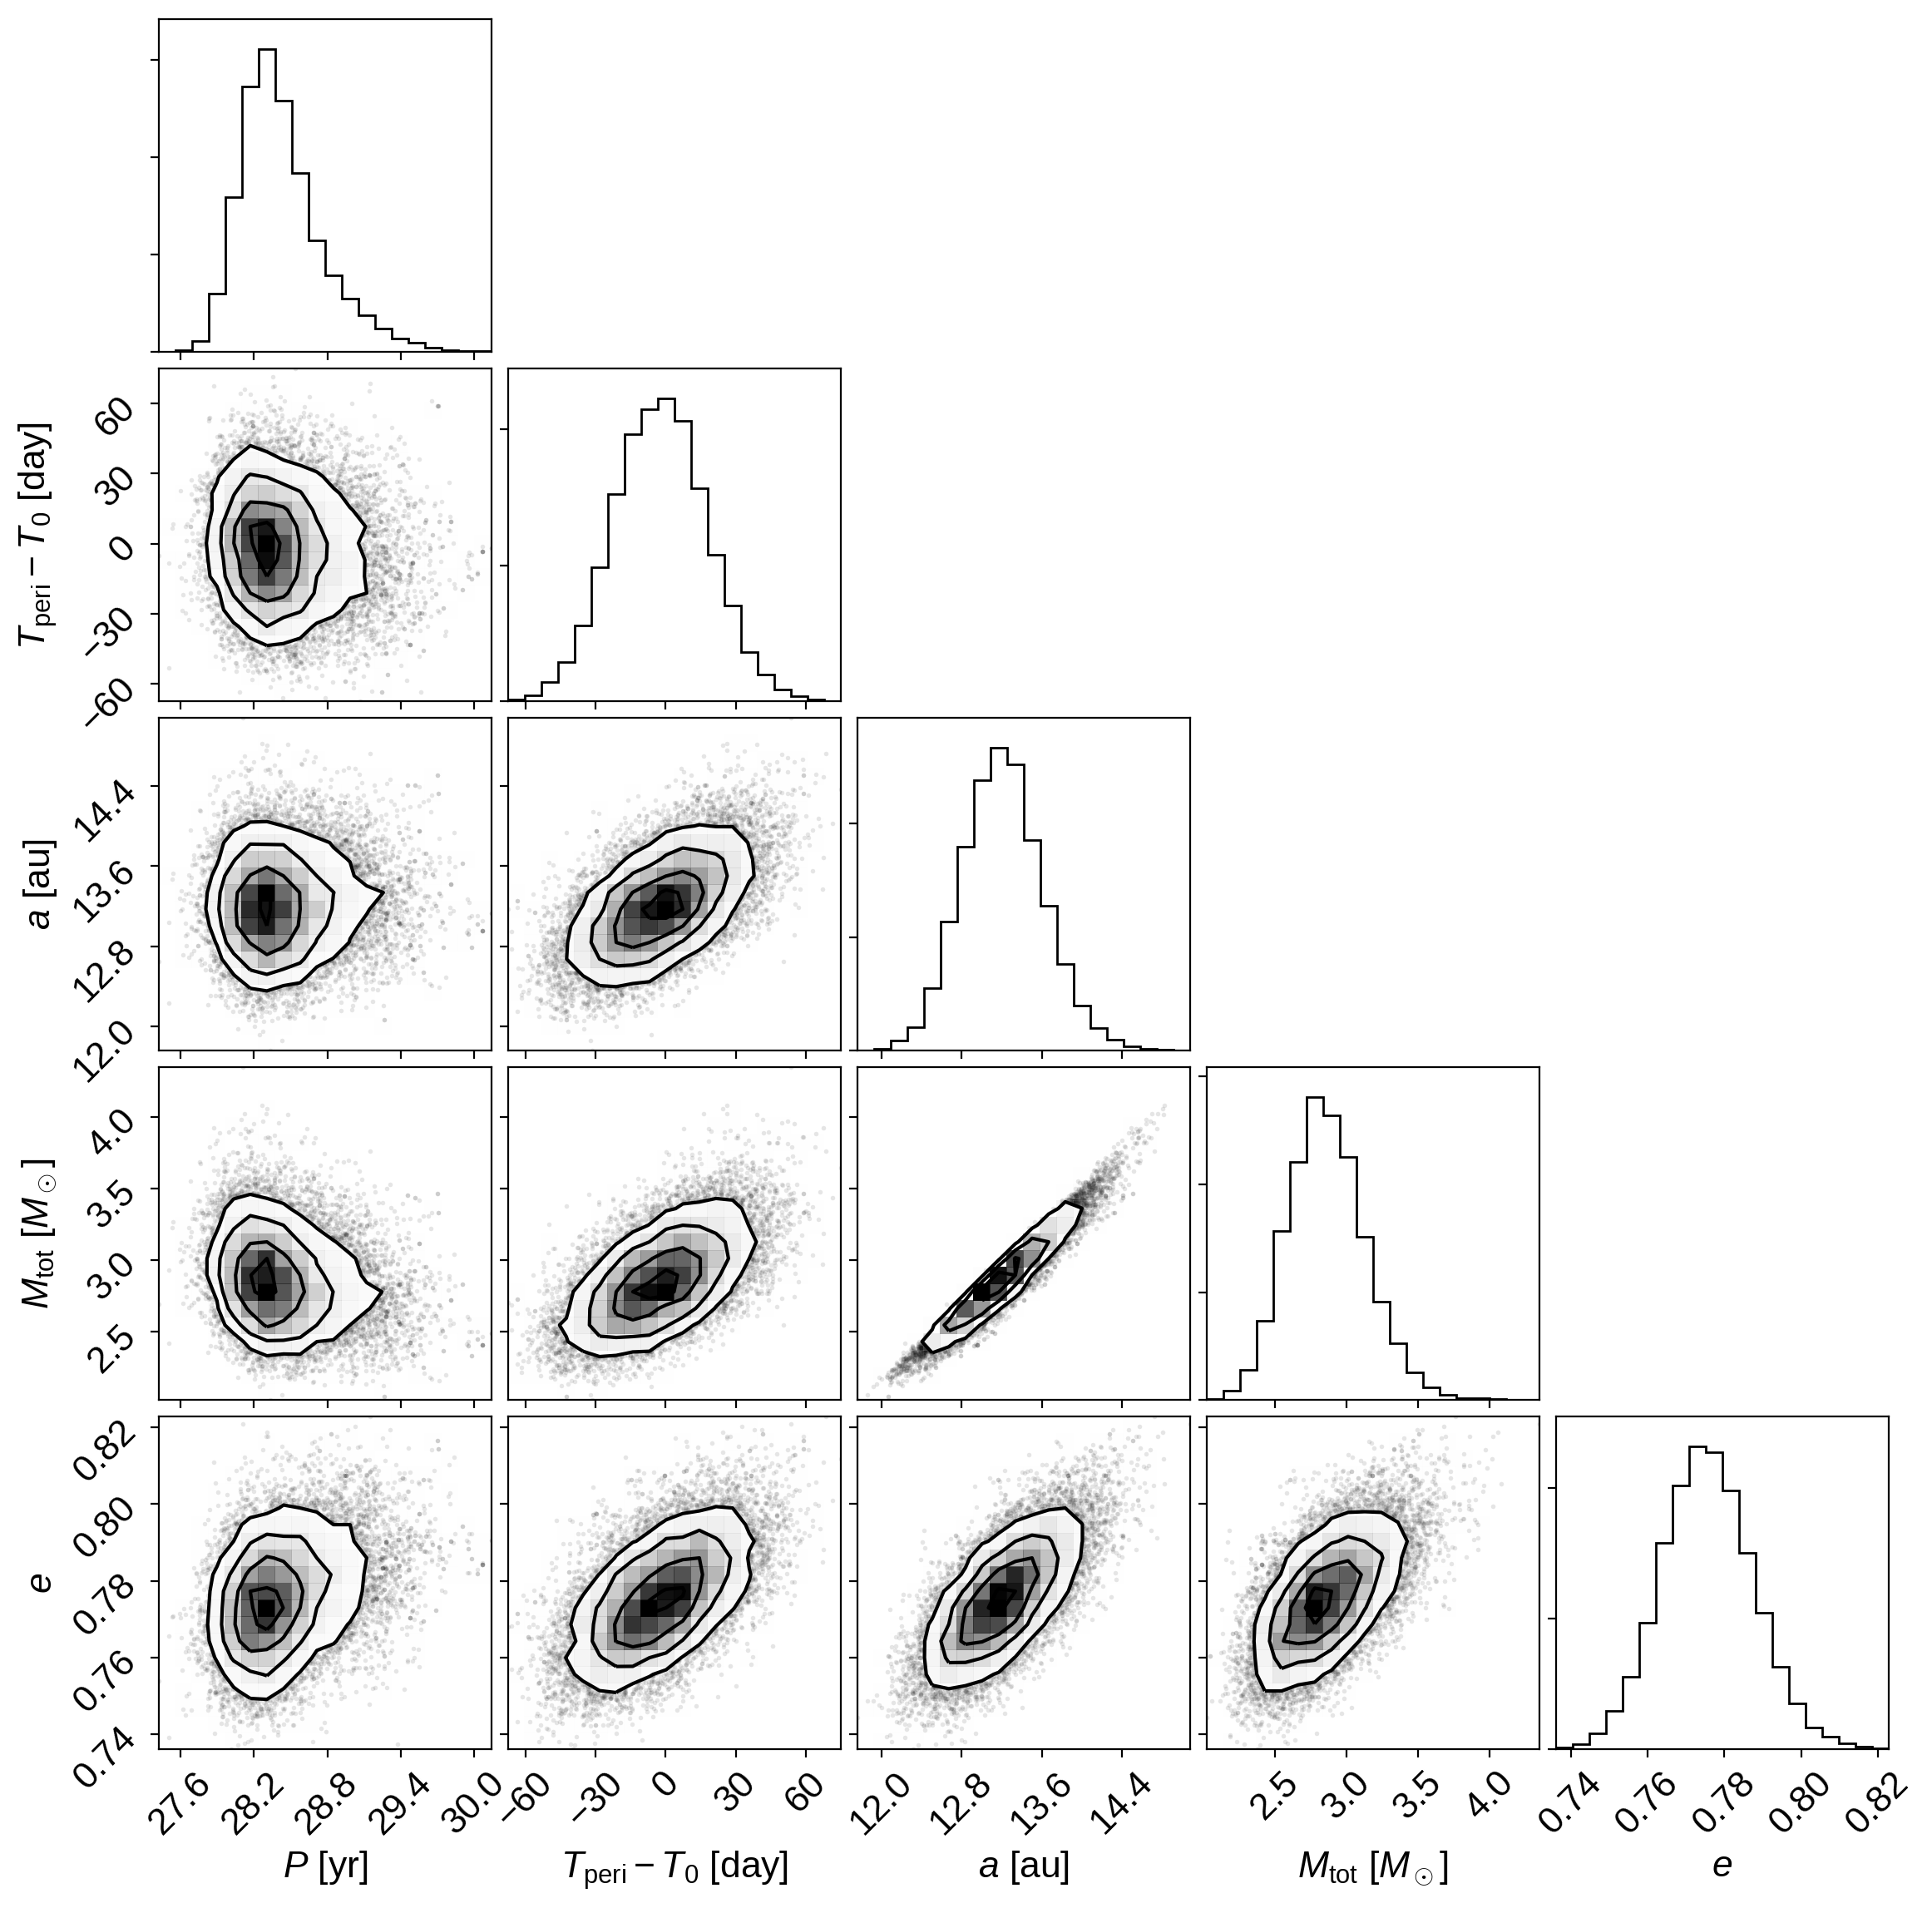

In [17]:
samples = pm.trace_to_dataframe(plx_trace, varnames=["ecc"])
samples["$P$ [yr]"] = plx_trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = plx_trace["tperi"] - T0
samples["$a$ [au]"] = plx_trace["a"]
samples["$M_\mathrm{tot}$ [$M_\odot$]"] = plx_trace["M_tot"]
samples["$e$"] = plx_trace["ecc"]
del samples["ecc"]
corner.corner(samples);

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [18]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [19]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.2.1},
   month = sep,
    year = 2019,
     doi = {10.5281/zenodo.3462740},
     url = {https://doi.org/10.5281/zenodo.3462740}
}
...
